<a href="https://colab.research.google.com/github/Giovo17/cardio_disease-disease-analysis/blob/main/cardio_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cardio disease analysis

In [65]:
# colab related
!pip install matplotlib --upgrade
!pip install sklearn --upgrade

In [66]:
# Importing main libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay


plt.rcParams.update({'figure.figsize': (10.0, 10.0)})
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'figure.dpi': 300})

In [67]:
data_source = "https://raw.githubusercontent.com/Giovo17/cardio-disease-analysis/main/cardio_train.csv"
df = pd.read_csv(data_source, sep=";", index_col="id")
df = df.rename(columns={"ap_hi": "systolic_bp", "ap_lo": "diastolic_bp",
                        "gluc": "glucose", "alco": "alcool_intake",
                        "active": "physical_activity", "cardio": "cardio_disease"})

In [68]:
df.head()

age  gender  height  weight  systolic_bp  diastolic_bp  cholesterol  \
id                                                                          
0   18393       2     168    62.0          110            80            1   
1   20228       1     156    85.0          140            90            3   
2   18857       1     165    64.0          130            70            3   
3   17623       2     169    82.0          150           100            1   
4   17474       1     156    56.0          100            60            1   

    glucose  smoke  alcool_intake  physical_activity  cardio_disease  
id                                                                    
0         1      0              0                  1               0  
1         1      0              0                  1               1  
2         1      0              0                  0               1  
3         1      0              0                  1               1  
4         1      0              0                  0               0

#### Data description reported by authors

There are 3 types of input features:

1. Objective: factual information;
2. Examination: results of medical examination;
3. Subjective: information given by the patient.


| Feature | Feature type | Name in dataset | Data type
| :---: | :-------------------: | :-----: | :-----------: |
|Age | Objective Feature | age | int (days)|
|Gender | Objective Feature | gender | categorical code (1: female, 2: male) |
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Systolic blood pressure | Examination Feature | systolic_bp | int |
|Diastolic blood pressure | Examination Feature | diastolic_bp | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | glucose | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alcool | binary |
|Physical activity | Subjective Feature | physical_activity | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio_disease | binary |

All of the dataset values were collected at the moment of medical examination. 

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                70000 non-null  int64  
 1   gender             70000 non-null  int64  
 2   height             70000 non-null  int64  
 3   weight             70000 non-null  float64
 4   systolic_bp        70000 non-null  int64  
 5   diastolic_bp       70000 non-null  int64  
 6   cholesterol        70000 non-null  int64  
 7   glucose            70000 non-null  int64  
 8   smoke              70000 non-null  int64  
 9   alcool_intake      70000 non-null  int64  
 10  physical_activity  70000 non-null  int64  
 11  cardio_disease     70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


There are no missing values

In [70]:
df["gender"] = df["gender"].map({1: 0, 2: 1})

Add the BMI feature from height and weight

In [71]:
BMI = df["weight"] / (df["height"] / 100)**2
df.insert (4, "BMI", BMI)

Convert age in years

In [72]:
df["age"] = (df["age"]/365).astype(int)

In [73]:
df.head()

age  gender  height  weight        BMI  systolic_bp  diastolic_bp  \
id                                                                      
0    50       1     168    62.0  21.967120          110            80   
1    55       0     156    85.0  34.927679          140            90   
2    51       0     165    64.0  23.507805          130            70   
3    48       1     169    82.0  28.710479          150           100   
4    47       0     156    56.0  23.011177          100            60   

    cholesterol  glucose  smoke  alcool_intake  physical_activity  \
id                                                                  
0             1        1      0              0                  1   
1             3        1      0              0                  1   
2             3        1      0              0                  0   
3             1        1      0              0                  1   
4             1        1      0              0                  0   

    cardio_disease  
id                  
0                0  
1                1  
2                1  
3                1  
4                0

Search for duplicated rows

In [74]:
print("Duplicate rows: {}".format(df.duplicated().sum()))
df = df.drop_duplicates()

Duplicate rows: 3208


In [75]:
df.shape

(66792, 13)

There are no missing values.

## Data exploration and cleaning

In [76]:
def map_values(dataframe, to_numeric=False):
    if to_numeric:
        dataframe["gender"] = dataframe["gender"].map({"female": 0, "male": 1})
        dataframe["cholesterol"] = dataframe["cholesterol"].map({"normal": 1, "above normal": 2, "well above normal": 3})
        dataframe["glucose"] = dataframe["glucose"].map({"normal": 1, "above normal": 2, "well above normal": 3})
        dataframe["smoke"] = dataframe["smoke"].map({"no": 0, "yes": 1})
        dataframe["alcool_intake"] = dataframe["alcool_intake"].map({"no": 0, "yes": 1})
        dataframe["physical_activity"] = dataframe["physical_activity"].map({"inactive": 0, "active": 1})
        dataframe["cardio_disease"] = dataframe["cardio_disease"].map({"healthy": 0, "sick": 1})

    else:
        dataframe["gender"] = dataframe["gender"].map({0: "female", 1: "male"})
        dataframe["cholesterol"] = dataframe["cholesterol"].map({1: "normal", 2: "above normal", 3: "well above normal"})
        dataframe["glucose"] = dataframe["glucose"].map({1: "normal", 2: "above normal", 3: "well above normal"})
        dataframe["smoke"] = dataframe["smoke"].map({0: "no", 1: "yes"})
        dataframe["alcool_intake"] = dataframe["alcool_intake"].map({0: "no", 1: "yes"})
        dataframe["physical_activity"] = dataframe["physical_activity"].map({0: "inactive", 1: "active"})
        dataframe["cardio_disease"] = dataframe["cardio_disease"].map({0: "healthy", 1: "sick"})


    return dataframe


In [77]:
df = map_values(df, to_numeric=False)

### Categorical data

In [78]:
def get_percentages(ax_container):
    perc = []
    sum = 0
    for k in ax_container:
        sum += k.get_height()
    
    for k in ax_container:
        lab = str(k.get_height()) + "  (" + str(round(k.get_height() / sum * 100, 1)) + " %)"
        perc.append(lab)

    return perc

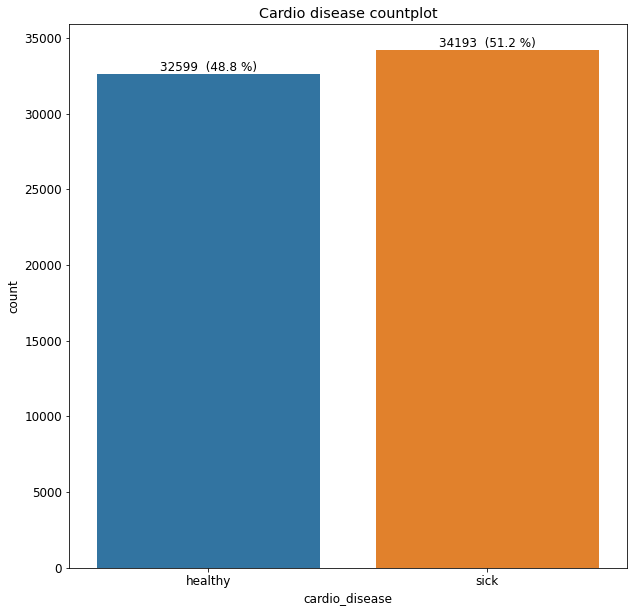

In [79]:
ax = sns.countplot(data=df, x="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.set_title("Cardio disease countplot")

plt.show()

The target variable cardio_disease is balanced

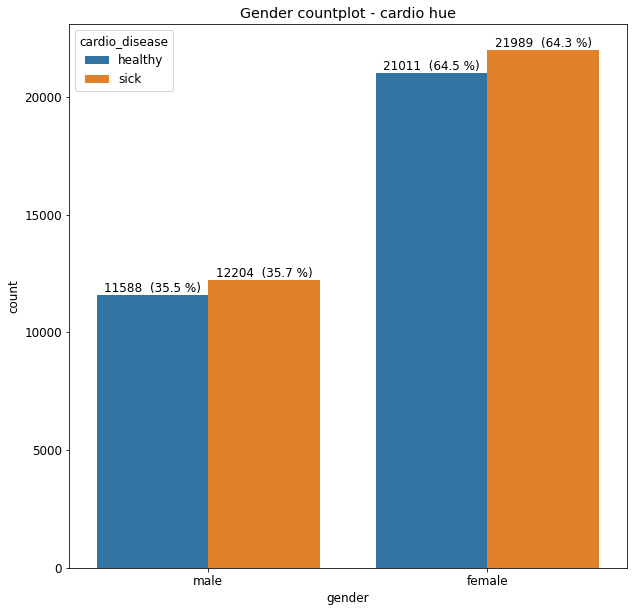

In [80]:
ax = sns.countplot(data=df, x="gender", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Gender countplot - cardio hue")
plt.show()

The gender of the patient doesn't seem to have a noticeable correlation with the target variable

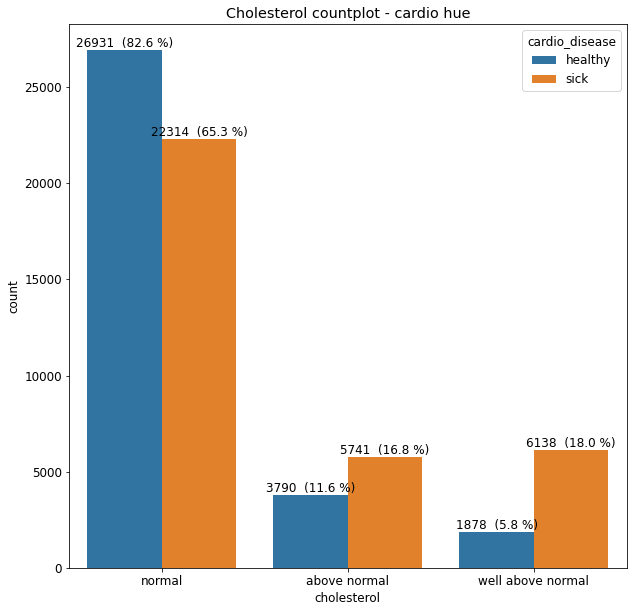

In [81]:
ax = sns.countplot(data=df, x="cholesterol", hue="cardio_disease", order=["normal", "above normal", "well above normal"])
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Cholesterol countplot - cardio hue")
plt.show()

As it can be seen on the graph the cholesterol has an impact on the target variable. 

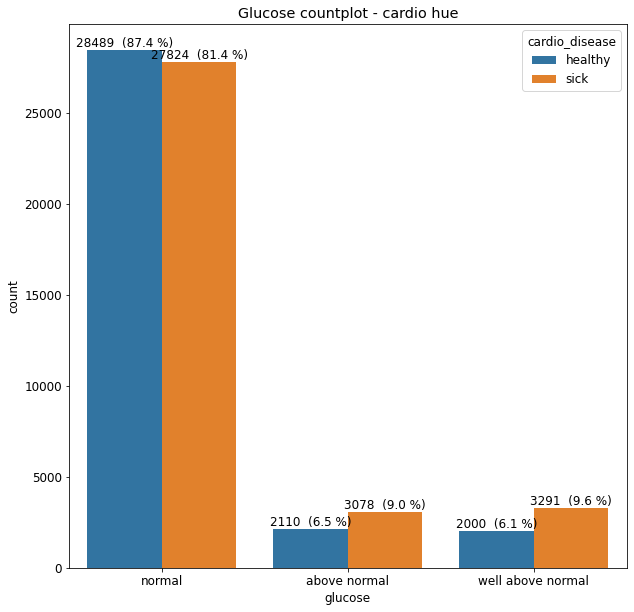

In [82]:
ax = sns.countplot(data=df, x="glucose", hue="cardio_disease", order=["normal", "above normal", "well above normal"])
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Glucose countplot - cardio hue")
plt.show()

The trend for the glucose variable is the same of the cholesterol one, but the differences between healthy and sick patients are more subtle.

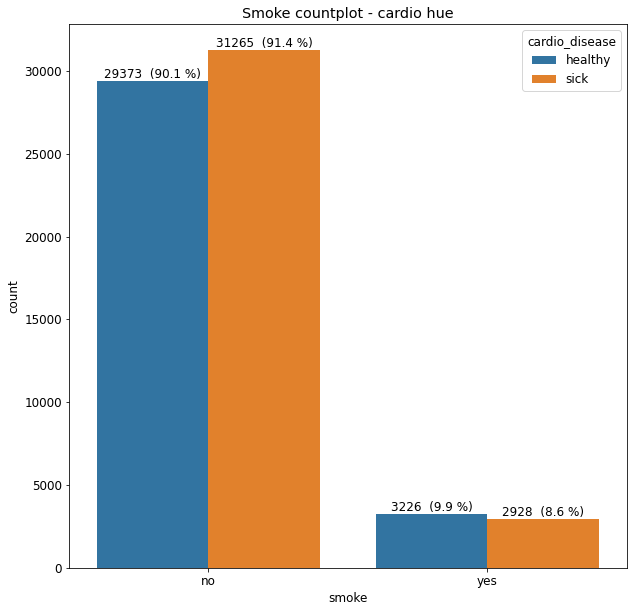

In [83]:
ax = sns.countplot(data=df, x="smoke", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Smoke countplot - cardio hue")
plt.show()

The smoke feature looks like it's uncorrelated with the health of the patient

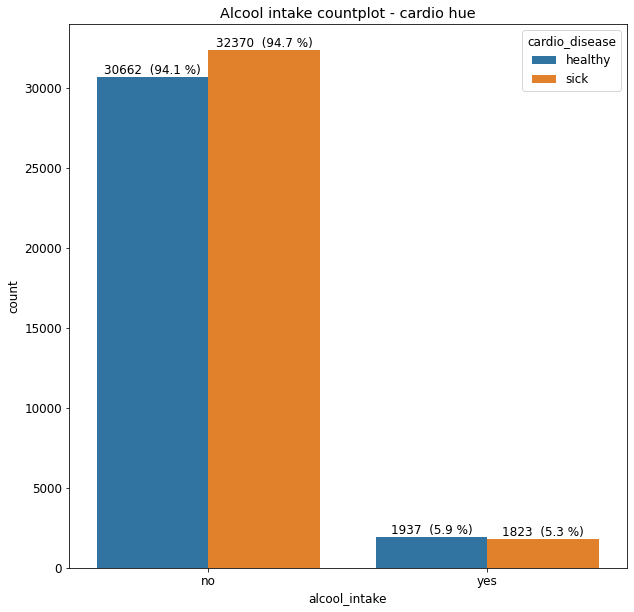

In [84]:
ax = sns.countplot(data=df, x="alcool_intake", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Alcool intake countplot - cardio hue")
plt.show()

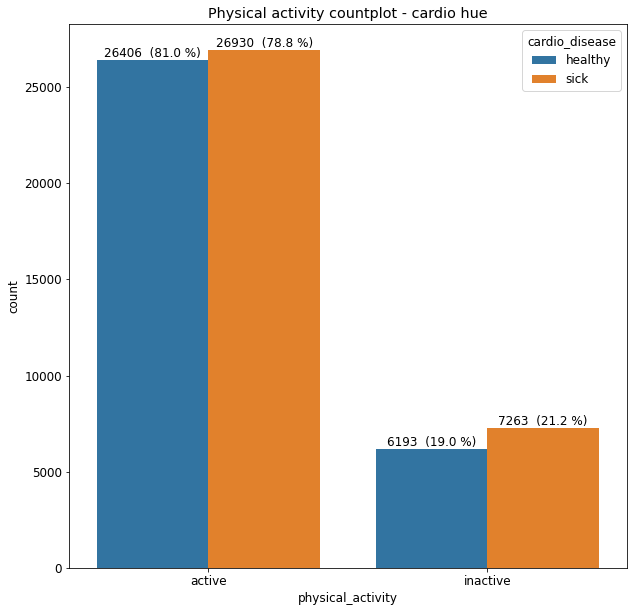

In [85]:
ax = sns.countplot(data=df, x="physical_activity", hue="cardio_disease")
ax.bar_label(ax.containers[0], get_percentages(ax.containers[0]))
ax.bar_label(ax.containers[1], get_percentages(ax.containers[1]))
ax.set_title("Physical activity countplot - cardio hue")
plt.show()

Alcool intake and physical activity follow the same path of the smoke feature

### Numerical data

**Age**

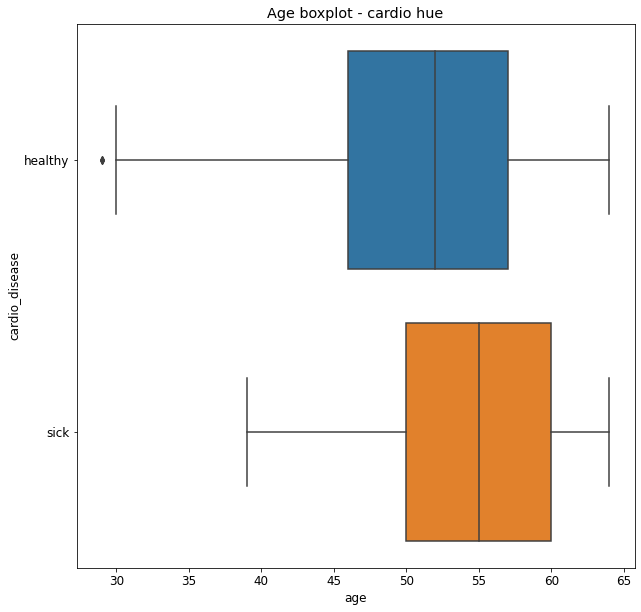

count       mean       std   min   25%   50%   75%   max
cardio_disease                                                            
healthy         32599.0  51.220191  6.847514  29.0  46.0  52.0  57.0  64.0
sick            34193.0  54.422835  6.380788  39.0  50.0  55.0  60.0  64.0

In [86]:
ax = sns.boxplot(data=df, x="age", y="cardio_disease", orient="h")
ax.set_title("Age boxplot - cardio hue")
plt.show()

df.groupby("cardio_disease")["age"].describe()

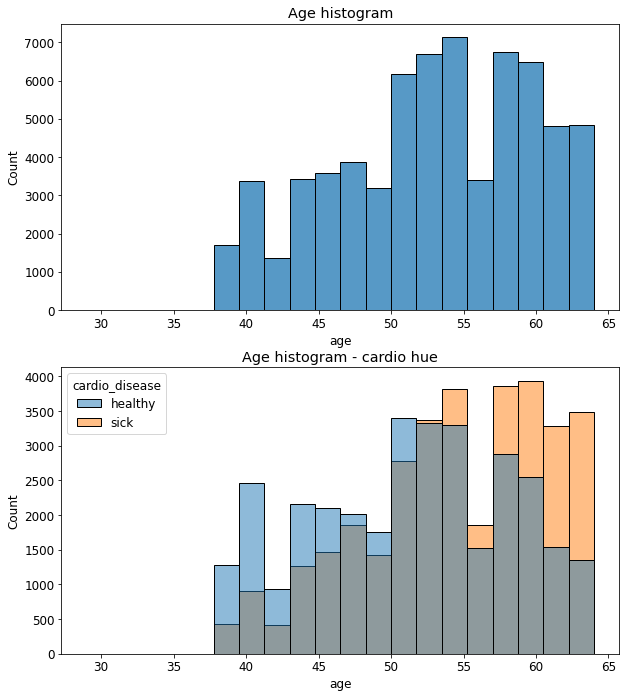

In [87]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="age", bins=20)
ax.set_title("Age histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="age", bins=20, hue="cardio_disease")
ax.set_title("Age histogram - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

The patients age ranges from 29 to 64, so there are only adults.

The distribution seems to be bimodal with modes around 55 and 58.

Taking into consideration the conditional boxplot this feature is slightly related to the target variable, in fact the "cardio_disease affected" patients box is has higher minimum, 1° quartile, median and 3° quartile with respect to healthy patients. Observing the conditional histplot this trend is confirmed: there's an higher concentration of unhealthy patients as the age increases. Though in both there's a considerable overlap between the two classes.

**Height, weight and BMI**

The BMI is the Body Mass Index and it's defined as $ BMI = \frac{w}{h^2} $ where $w$ is the weight in *kilograms* and $h$ is the height in *meters*

A reference table from [Ministero della salute](https://www.salute.gov.it/portale/nutrizione/dettaglioIMCNutrizione.jsp?lingua=italianoid=5479area=nut):

|Condition|BMI|
|---------|:-:|
| Severe thinness | BMI < 16 |
| Underweight | 16 < BMI < 18.49 |
| Normal weight | 18.5 < BMI < 24.99 |
| Overweight | 25 < BMI < 29.99 |
| Obese class 1 | 30 < BMI < 34.99 |
| Obese class 2 | 35 < BMI < 39.99 |
| Obese class 3 | BMI > 40 |

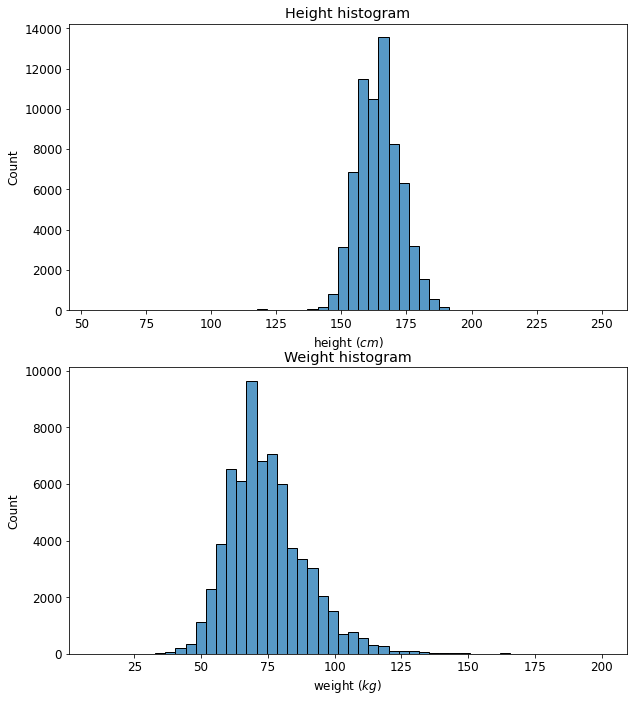

In [88]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="height", bins=50)
ax.set_xlabel("height ($cm$)")
ax.set_title("Height histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="weight", bins=50)
ax.set_xlabel("weight ($kg$)")
ax.set_title("Weight histogram")

plt.subplots_adjust(top=1)
plt.show()

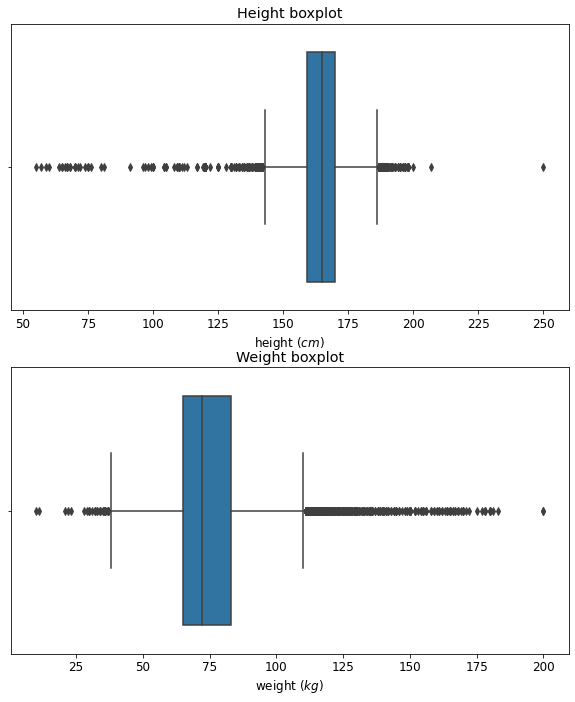

In [89]:
plt.subplot(2, 1, 1)
ax = sns.boxplot(data=df, x="height")
ax.set_xlabel("height ($cm$)")
ax.set_title("Height boxplot")

plt.subplot(2, 1, 2)
ax = sns.boxplot(data=df, x="weight")
ax.set_xlabel("weight ($kg$)")
ax.set_title("Weight boxplot")

plt.subplots_adjust(top=1)
plt.show()

In [90]:
pd.DataFrame(df["height"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

count        mean       std   min     1%    25%    50%    75%  \
height  66792.0  164.341748  8.333904  55.0  146.0  159.0  165.0  170.0   

        99.9%    max  
height  190.0  250.0

In [91]:
pd.DataFrame(df["weight"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

count      mean        std   min    1%   25%   50%   75%  99.9%  \
weight  66792.0  74.52116  14.580675  10.0  48.0  65.0  72.0  83.0  150.0   

          max  
weight  200.0

Both height and weight are unimodal distributions with modes around 165 (cm) and 65 (kg) respectively.

The height distribution looks like it isn't skewed. The weight distribution seems to be slightly positive skewed as it's right tail it's a bit longer than the left one.

These features present outliers as it can be seen from the boxplot and the correspondig statistics table.

Checking weight skeweness:

In [92]:
print("Mode: {}, median: {}, mean: {}".format(stats.mode(df["weight"])[0][0], np.median(df["weight"]), round(np.mean(df["weight"]), 2)))
print("Fisher-Pearson coefficient of skewness: {}".format(round(stats.skew(df["weight"]), 2)))


Mode: 70.0, median: 72.0, mean: 74.52
Fisher-Pearson coefficient of skewness: 0.97


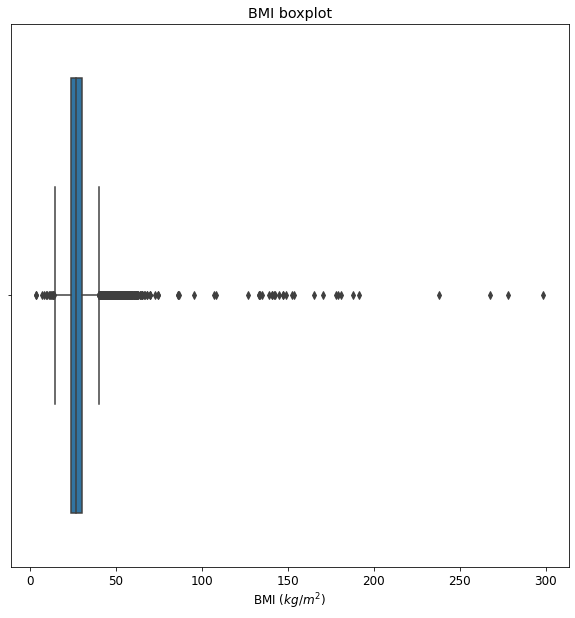

count       mean       std       min        25%        50%       75%  \
BMI  66792.0  27.682565  6.184422  3.471784  23.875115  26.573129  30.46875   

         99.9%         max  
BMI  59.623333  298.666667

In [93]:
ax = sns.boxplot(data=df, x="BMI")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI boxplot")
plt.show()

pd.DataFrame(df["BMI"].describe(percentiles=[0.25, 0.5, 0.75, 0.999])).T

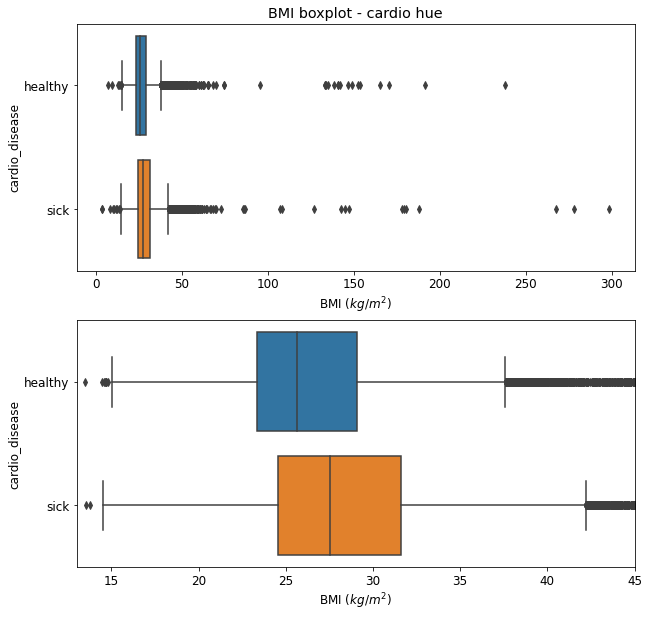

count       mean       std       min        25%        50%  \
cardio_disease                                                                 
healthy         32599.0  26.674952  5.755386  7.022248  23.372576  25.636917   
sick            34193.0  28.643205  6.421927  3.471784  24.560326  27.548209   

                      75%      99.9%         max  
cardio_disease                                    
healthy         29.060607  60.089236  237.768633  
sick            31.615793  59.458581  298.666667

In [94]:
plt.subplot(2, 1, 1)
ax = sns.boxplot(data=df, x="BMI", y="cardio_disease", orient="h")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI boxplot - cardio hue")

plt.subplot(2, 1, 2)
ax = sns.boxplot(data=df, x="BMI", y="cardio_disease", orient="h")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_xlim(13, 45)

plt.show()

df.groupby("cardio_disease")["BMI"].describe(percentiles=[0.25, 0.5, 0.75, 0.999])

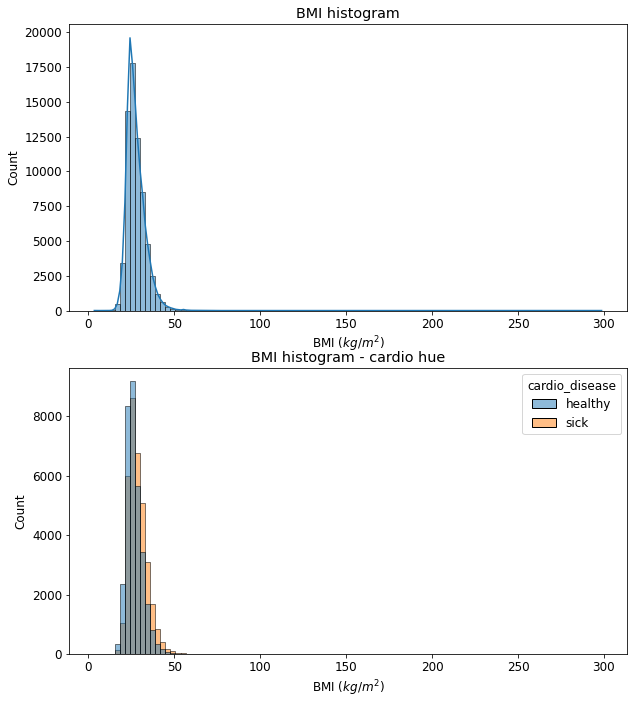

In [95]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="BMI", bins=100, kde=True)
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="BMI", bins=100, hue="cardio_disease")
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI histogram - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

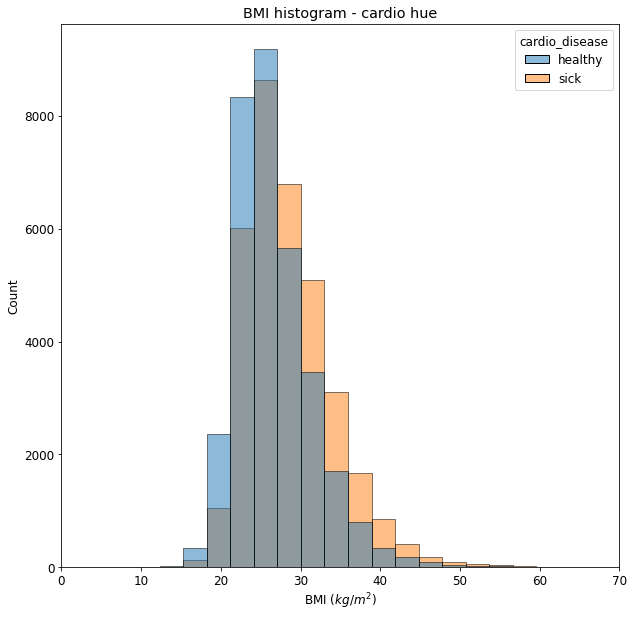

In [96]:
ax = sns.histplot(data=df, x="BMI", bins=100, hue="cardio_disease")
ax.set_xlim(0, 70)
ax.set_xlabel("BMI ($kg/m^2$)")
ax.set_title("BMI histogram - cardio hue")

plt.show()

In [97]:
print("Mode: {}, median: {}, mean: {}".format(round(stats.mode(df["BMI"])[0][0], 2), round(np.median(df["BMI"]), 2), round(np.mean(df["BMI"]), 2)))
print("Fisher-Pearson coefficient of skewness: {}".format(round(stats.skew(df["BMI"]), 2)))

Mode: 23.88, median: 26.57, mean: 27.68
Fisher-Pearson coefficient of skewness: 7.69


The BMI feature is unimodal (mode in 23.88) and positively skewed as shown by the Fisher-Pearson coefficient.

There are a lot of outliers in this features.

**Systolic blood pressure and diastolic blood pressure**

These features measures the pressure in arteries respectively when the heart beats and in a period between two heatbeats.

A reference table from [heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings):

|Blood pressure category|Systolic blood pressure (mm Hg)|and/or|Diastolic blood pressure (mm Hg)|
|-----------------------|:-----------------------------:|:------:|:------------------------------:|
|Normal| systolic_bp < 120 | and| diastolic_bp < 80 |
|Elevated| 120 < systolic_bp < 129 | and | diastolic_bp < 80 |
|High blood pressure (Hypertension stage 1)| 130 < systolic_bp < 139 | or | 80 < diastolic_bp < 89 |
|High blood pressure (Hypertension stage 2)| systolic_bp > 140 | or | diastolic_bp > 90
|Hypertensive crisis| systolic_bp > 180 | and/or | diastolic_bp > 120 |


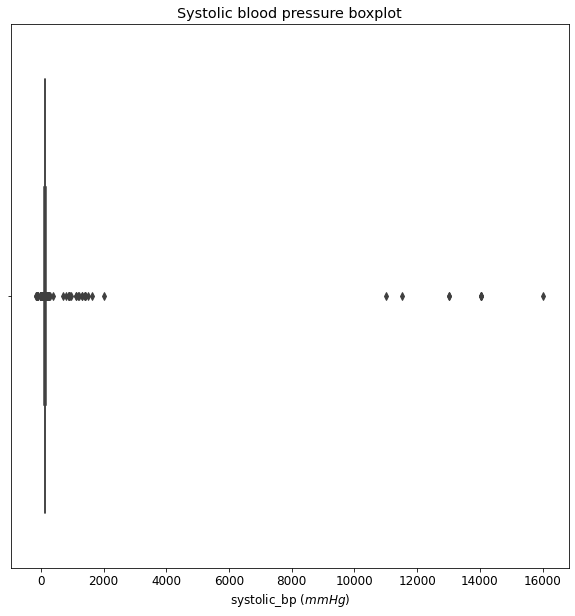

count        mean         std    min    1%    25%    50%  \
systolic_bp  66792.0  129.231585  157.649354 -150.0  90.0  120.0  120.0   

               75%  99.9%      max  
systolic_bp  140.0  220.0  16020.0

In [98]:
ax = sns.boxplot(data=df, x="systolic_bp")
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure boxplot")
plt.show()

pd.DataFrame(df["systolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

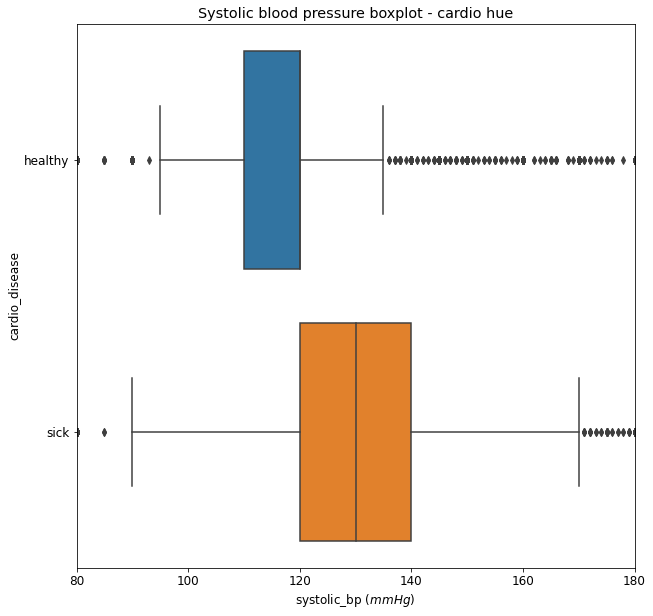

count        mean         std    min     1%    25%    50%  \
cardio_disease                                                                
healthy         32599.0  120.528728  107.320611 -120.0   90.0  110.0  120.0   
sick            34193.0  137.528734  193.460336 -150.0  100.0  120.0  130.0   

                  75%    99%      max  
cardio_disease                         
healthy         120.0  160.0  14020.0  
sick            140.0  180.0  16020.0

In [99]:
ax = sns.boxplot(data=df, x="systolic_bp", y="cardio_disease", orient="h")
ax.set_xlim(80, 180)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure boxplot - cardio hue")

plt.show()

df.groupby("cardio_disease")["systolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

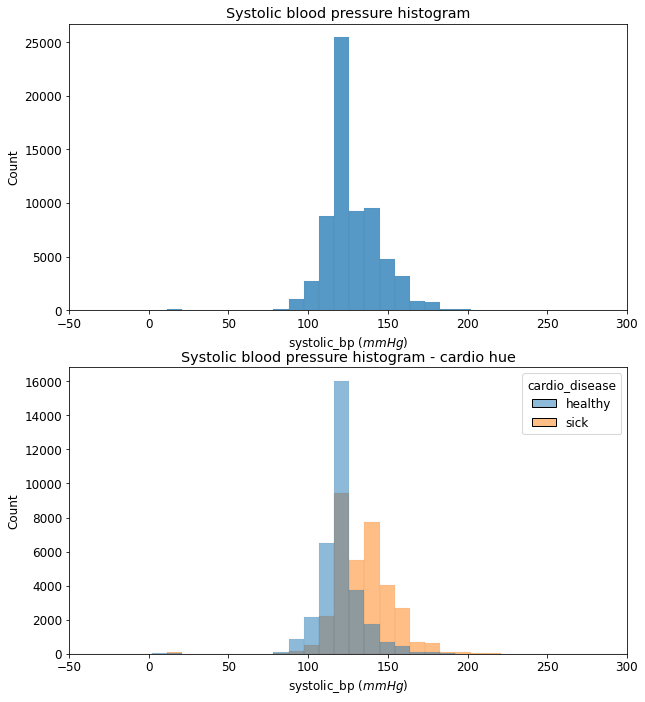

In [100]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="systolic_bp", bins=1700)
ax.set_xlim(-50, 300)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure histogram")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="systolic_bp", bins=1700, hue="cardio_disease")
ax.set_xlim(-50, 300)
ax.set_xlabel("systolic_bp ($mm Hg$)")
ax.set_title("Systolic blood pressure histogram - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

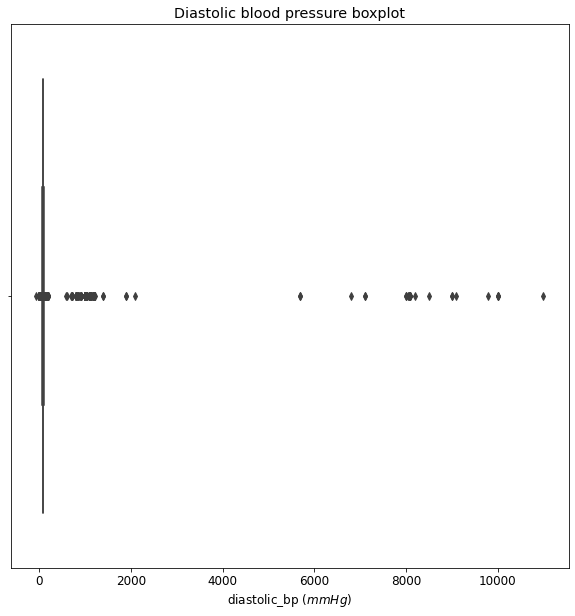

count       mean         std   min    1%   25%   50%   75%  \
diastolic_bp  66792.0  97.446221  192.906434 -70.0  60.0  80.0  80.0  90.0   

               99.9%      max  
diastolic_bp  1110.0  11000.0

In [101]:
ax = sns.boxplot(data=df, x="diastolic_bp")
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure boxplot")

plt.show()

pd.DataFrame(df["diastolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.999])).T

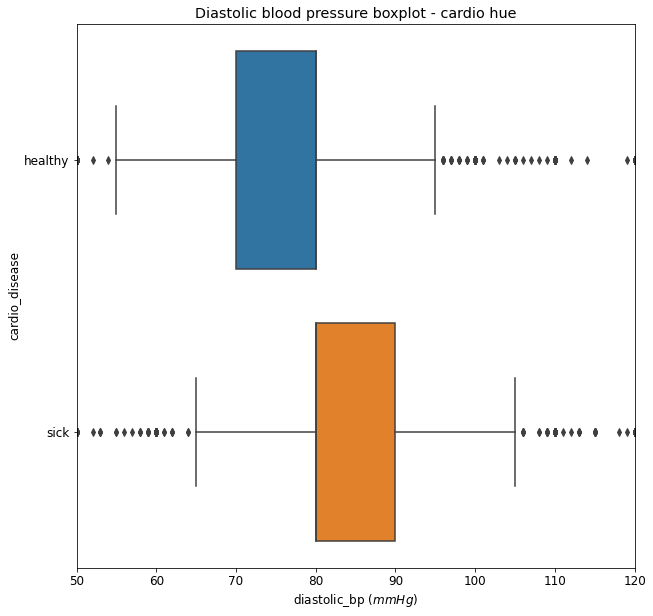

count        mean         std   min    1%   25%   50%   75%  \
cardio_disease                                                                  
healthy         32599.0   84.634743  158.248448   0.0  60.0  70.0  80.0  80.0   
sick            34193.0  109.660457  220.252704 -70.0  60.0  80.0  80.0  90.0   

                   99%      max  
cardio_disease                   
healthy          100.0   9800.0  
sick            1000.0  11000.0

In [102]:
ax = sns.boxplot(data=df, x="diastolic_bp", y="cardio_disease", orient="h")
ax.set_xlim(50, 120)
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure boxplot - cardio hue")

plt.show()

df.groupby("cardio_disease")["diastolic_bp"].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

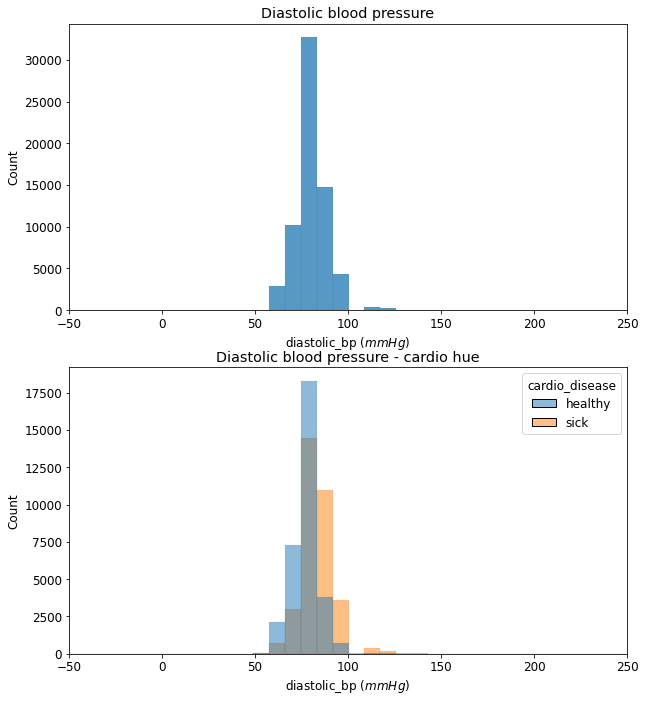

In [103]:
plt.subplot(2, 1, 1)
ax = sns.histplot(data=df, x="diastolic_bp", bins=1300)
ax.set_xlim(-50, 250)
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure")

plt.subplot(2, 1, 2)
ax = sns.histplot(data=df, x="diastolic_bp", bins=1300, hue="cardio_disease")
ax.set_xlim(-50, 250)
ax.set_xlabel("diastolic_bp ($mm Hg$)")
ax.set_title("Diastolic blood pressure - cardio hue")

plt.subplots_adjust(top=1)
plt.show()

These features have a similar behaviour. Both of them present outliers as it can be seen from the boxplots.

When not considering outliers, they are unimodal (mode around 120 mmHg and 80 mmHg respectively) and approximatevely simmetric. They are related to the cardio_disease feature as it can be seen from the boxplot and the histogram, though there's overlap between healthy and unhealthy patients.

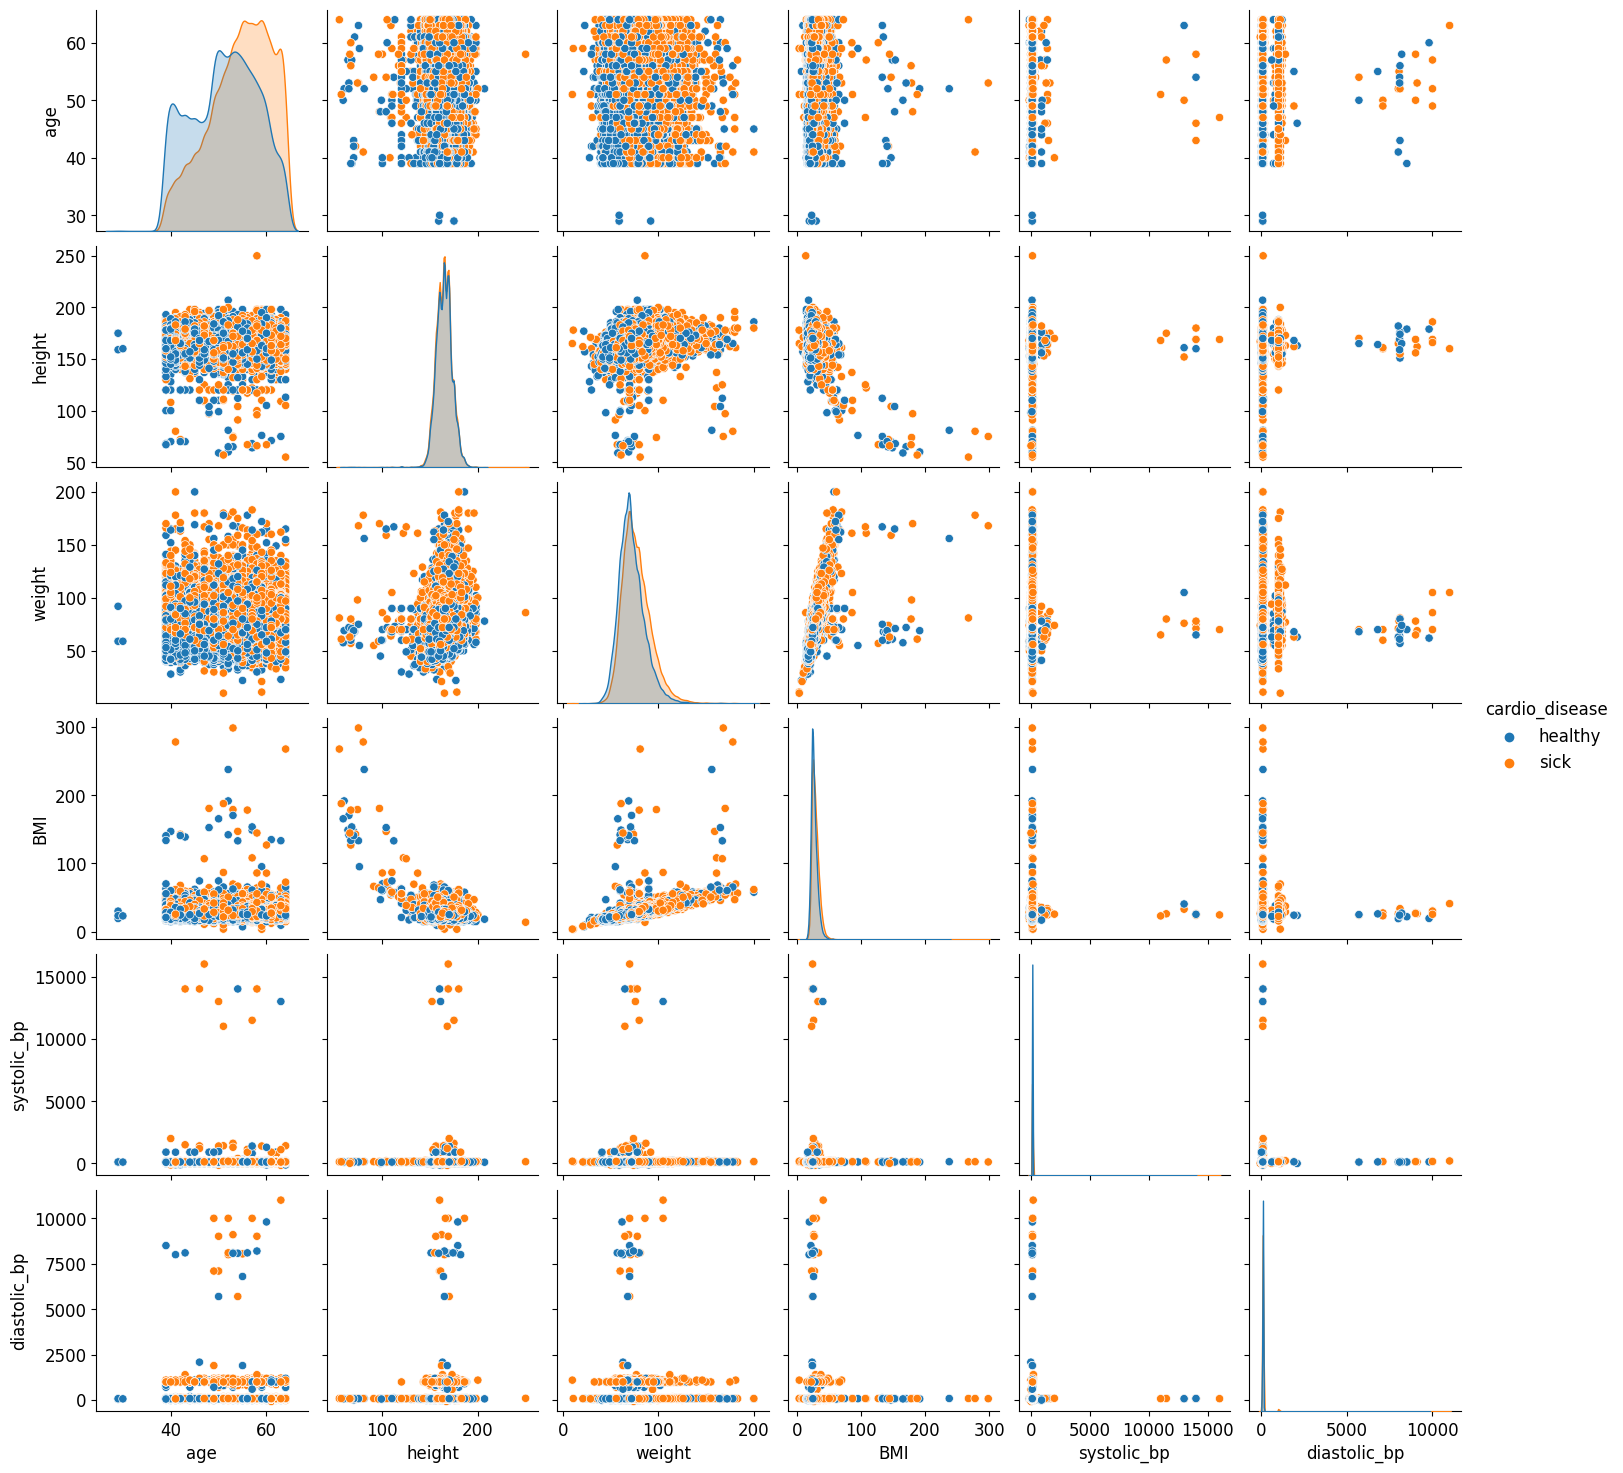

In [ ]:
sns.pairplot(data=df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cardio_disease"]], hue='cardio_disease')
plt.show()

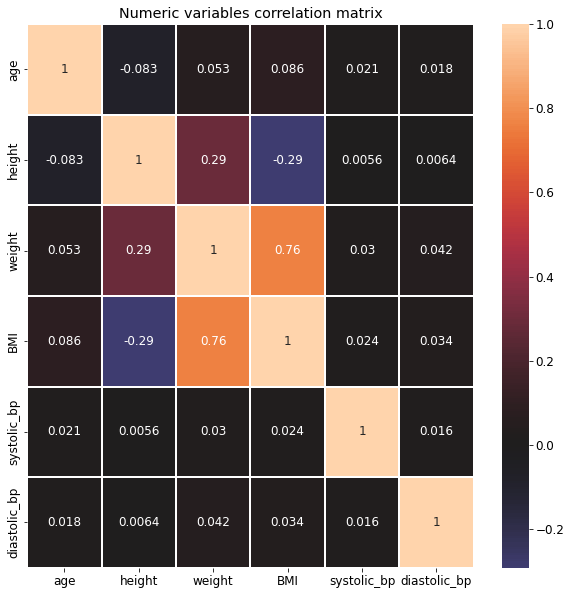

In [104]:
ax = sns.heatmap(df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]].corr(), annot=True, fmt=".2g", linewidths=.1, center=0)
ax.set_title("Numeric variables correlation matrix")

plt.show()

**Analizing relationship between ap_hi and ap_lo**

In [105]:
# removing systolic_bp and diastolic_bp outliers
df_cleaned = df.copy()
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["systolic_bp"])) < 1.5)]
df_cleaned = df_cleaned[df_cleaned.systolic_bp > 0]
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["diastolic_bp"])) < 1.5)]
df_cleaned = df_cleaned[df_cleaned.diastolic_bp > 0]

print("Original dataset: {}".format(round(np.corrcoef(df["systolic_bp"], df["diastolic_bp"])[0][1], 3)))
print("Dataset without outliers: {}".format(round(np.corrcoef(df_cleaned["systolic_bp"], df_cleaned["diastolic_bp"])[0][1], 3)))

display(df.shape)
display(df_cleaned.shape)


Original dataset: 0.016
Dataset without outliers: 0.649


(66792, 13)

(65777, 13)

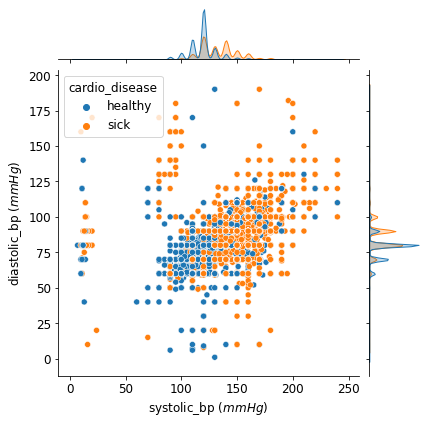

In [106]:
ax = sns.jointplot(data=df_cleaned, x="systolic_bp", y="diastolic_bp", hue="cardio_disease")
ax.set_axis_labels(xlabel="systolic_bp ($mm Hg$)", ylabel="diastolic_bp ($mm Hg$)")
#ax.set_title("Systolic vs diastolic blood pressure scatterplot")

plt.show()

As it can be seen from the scatterplot the two variables that represent the patient blood pressure are very correlated, but this correlation is hidden in the original data due to outliers presence.

**Analizing relationship between BMI, weight and height**

In [107]:
# removing height and weight outliers
display(df_cleaned.shape)

df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["height"])) < 4)]
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned["weight"])) < 4)]

display(df_cleaned.shape)

(65777, 13)

(65493, 13)

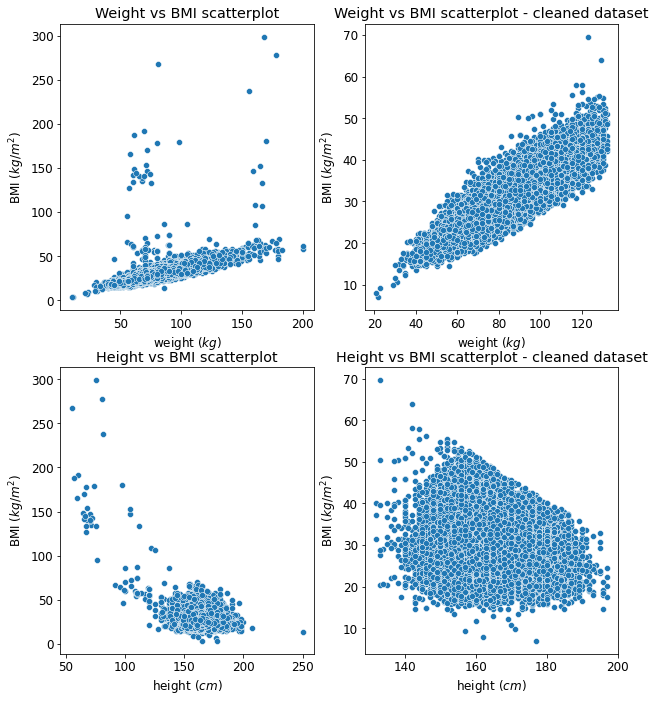

In [108]:
plt.subplot(2, 2, 1)
ax = sns.scatterplot(data=df, x="weight", y="BMI")
ax.set_xlabel("weight ($kg$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Weight vs BMI scatterplot")

plt.subplot(2, 2, 2)
ax = sns.scatterplot(data=df_cleaned, x="weight", y="BMI")
ax.set_xlabel("weight ($kg$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Weight vs BMI scatterplot - cleaned dataset")

plt.subplot(2, 2, 3)
ax = sns.scatterplot(data=df, x="height", y="BMI")
ax.set_xlabel("height ($cm$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Height vs BMI scatterplot")

plt.subplot(2, 2, 4)
ax = sns.scatterplot(data=df_cleaned, x="height", y="BMI")
ax.set_xlabel("height ($cm$)")
ax.set_ylabel("BMI ($kg/m^2$)")
ax.set_title("Height vs BMI scatterplot - cleaned dataset")

plt.subplots_adjust(top=1)
plt.show()

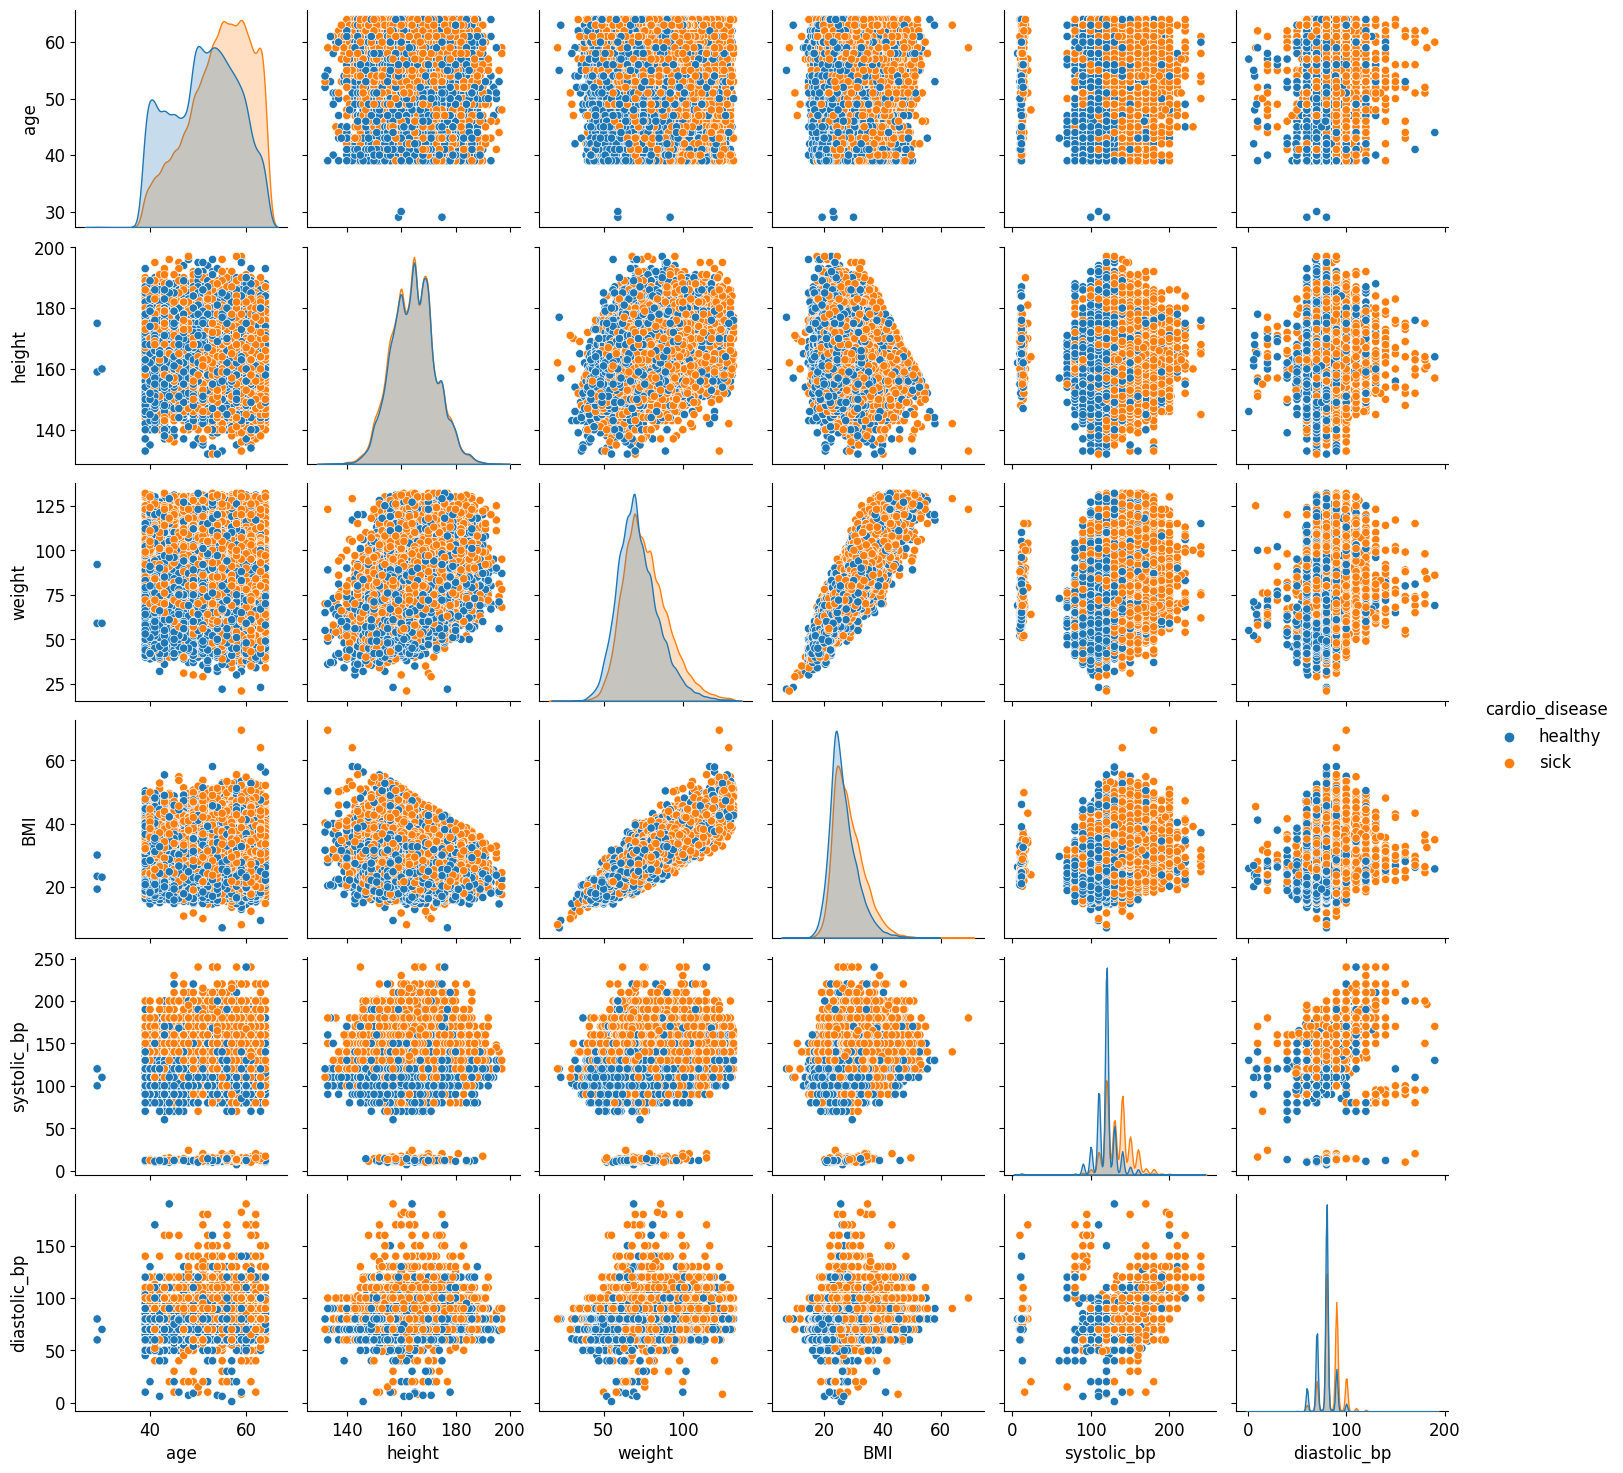

In [ ]:
sns.pairplot(data=df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cardio_disease"]], hue='cardio_disease')
plt.show()

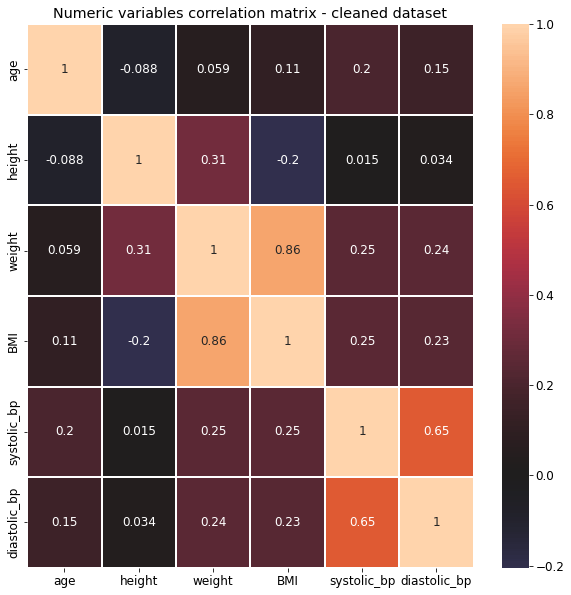

In [109]:
ax = sns.heatmap(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]].corr(), annot=True, fmt=".2g", linewidths=.1, center=0)
ax.set_title("Numeric variables correlation matrix - cleaned dataset")

plt.show()

In [110]:
df = map_values(df, to_numeric=True)
df_cleaned = map_values(df_cleaned, to_numeric=True)

## Dimensionality reduction

PCA

In [111]:
df.head()

age  gender  height  weight        BMI  systolic_bp  diastolic_bp  \
id                                                                      
0    50       1     168    62.0  21.967120          110            80   
1    55       0     156    85.0  34.927679          140            90   
2    51       0     165    64.0  23.507805          130            70   
3    48       1     169    82.0  28.710479          150           100   
4    47       0     156    56.0  23.011177          100            60   

    cholesterol  glucose  smoke  alcool_intake  physical_activity  \
id                                                                  
0             1        1      0              0                  1   
1             3        1      0              0                  1   
2             3        1      0              0                  0   
3             1        1      0              0                  1   
4             1        1      0              0                  0   

    cardio_disease  
id                  
0                0  
1                1  
2                1  
3                1  
4                0

In [112]:
scaler = StandardScaler()
scaler.fit(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_1 = scaler.transform(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])

pca = PCA()
df_1_reduced = pca.fit_transform(df_1)

def biplot(score, coeff, labels=["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley) # Display data points
    
    # Diplay arrows and labels
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var" + tr(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    # Plot settings
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title("Biplot - 2 components")
    plt.grid()


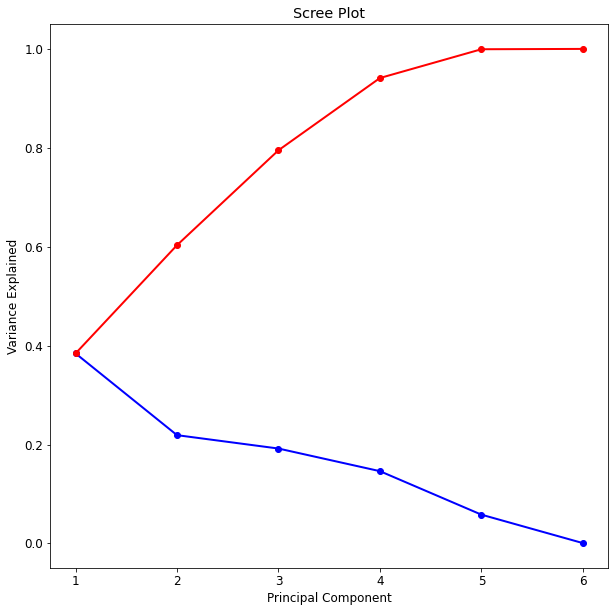

In [113]:
PCs = np.arange(pca.n_components_) + 1
cumulative_explained_variance = []
sum = 0
for i in pca.explained_variance_ratio_:
    sum += i
    cumulative_explained_variance.append(sum)

plt.plot(PCs, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.plot(PCs, cumulative_explained_variance, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.show()

The elbow on the scree plot occurs when choosing 4 PCs, but I will proceed with 2 and 3 PCs for data visualization's sake

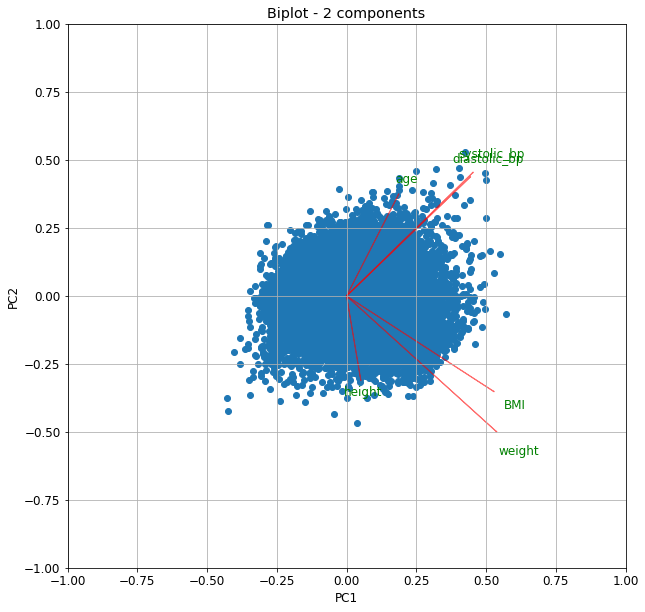

In [114]:
biplot(df_1_reduced[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

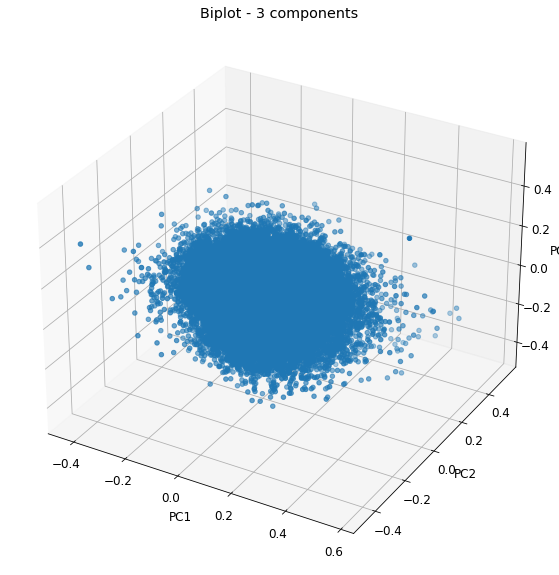

In [115]:
def threeD_biplot(score, coeff, labels=["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]):
    xs = score[:,0]
    ys = score[:,1]
    zs = score[:,2]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scalez = 1.0/(zs.max() - zs.min())
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs * scalex, ys * scaley, zs * scalez)
    '''
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff[i,2] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, coeff[i,2] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    
    ax.xlim(-1,1)
    ax.ylim(-1,1)
    ax.zlim(-1,1)
    '''
    
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    ax.set_zlabel("PC{}".format(3))
    ax.grid()
    ax.set_title("Biplot - 3 components")


threeD_biplot(df_1_reduced[:,0:3], np.transpose(pca.components_[0:3, :]))
plt.show()

## Data preprocessing

In [116]:
# Checking features' variance
print("Plain dataset: ")
for col in df.columns:
    if col != "cardio_disease":
        print("Variance of {}: {}".format(col, np.var(df[col])))

print("\nCleaned dataset: ")
for col in df_cleaned.columns:
    if col != "cardio_disease":
        print("Variance of {}: {}".format(col, np.var(df_cleaned[col])))

Plain dataset: 
Variance of age: 46.28923820644424
Variance of gender: 0.2293245292452307
Variance of height: 69.45291758340318
Variance of weight: 212.5928983675844
Variance of BMI: 38.24650091214697
Variance of systolic_bp: 24852.946817725206
Variance of diastolic_bp: 37212.33532198001
Variance of cholesterol: 0.4762754320026322
Variance of glucose: 0.33879216792161587
Variance of smoke: 0.08364759609464609
Variance of alcool_intake: 0.05312513373166648
Variance of physical_activity: 0.1608746164471119

Cleaned dataset: 
Variance of age: 46.31840813812409
Variance of gender: 0.22901034234915327
Variance of height: 62.82067588311537
Variance of weight: 196.39850624083203
Variance of BMI: 26.280408307490667
Variance of systolic_bp: 323.72448902938896
Variance of diastolic_bp: 99.73946236686292
Variance of cholesterol: 0.47417200501049195
Variance of glucose: 0.33787305379243265
Variance of smoke: 0.08338201671782781
Variance of alcool_intake: 0.05286931497488795
Variance of physical_ac

Smoke and alcool_intake have a very low variance, it can be considered to remove these features

In [117]:
# Onehot encoding cholesterol and glucose features

encoder = OneHotEncoder()
onehotarray = encoder.fit_transform(df_cleaned[["cholesterol"]]).toarray()
items = [f'{"cholesterol"}_{item}' for item in encoder.categories_[0]]
df_cleaned[items] = onehotarray

onehotarray = encoder.fit_transform(df_cleaned[["glucose"]]).toarray()
items = [f'{"glucose"}_{item}' for item in encoder.categories_[0]]
df_cleaned[items] = onehotarray

df_cleaned = df_cleaned.drop(columns=["cholesterol", "glucose"])


onehotarray = encoder.fit_transform(df[["cholesterol"]]).toarray()
items = [f'{"cholesterol"}_{item}' for item in encoder.categories_[0]]
df[items] = onehotarray

onehotarray = encoder.fit_transform(df[["glucose"]]).toarray()
items = [f'{"glucose"}_{item}' for item in encoder.categories_[0]]
df[items] = onehotarray

df = df.drop(columns=["cholesterol", "glucose"])

In [118]:
df_obese = df.loc[BMI >= 30]
df_obese_cleaned = df_cleaned.loc[BMI >= 30]

df_obese.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18332 entries, 1 to 99996
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                18332 non-null  int32  
 1   gender             18332 non-null  int64  
 2   height             18332 non-null  int64  
 3   weight             18332 non-null  float64
 4   BMI                18332 non-null  float64
 5   systolic_bp        18332 non-null  int64  
 6   diastolic_bp       18332 non-null  int64  
 7   smoke              18332 non-null  int64  
 8   alcool_intake      18332 non-null  int64  
 9   physical_activity  18332 non-null  int64  
 10  cardio_disease     18332 non-null  int64  
 11  cholesterol_1      18332 non-null  float64
 12  cholesterol_2      18332 non-null  float64
 13  cholesterol_3      18332 non-null  float64
 14  glucose_1          18332 non-null  float64
 15  glucose_2          18332 non-null  float64
 16  glucose_3          183

Scaling datasets

In [119]:
scaler = StandardScaler()

df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.fit_transform(df[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.fit_transform(df_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_obese[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.fit_transform(df_obese[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
df_obese_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.fit_transform(df_obese_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])


C:\Users\Giovanni\AppData\Local\Temp\ipykernel_7620\97472056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obese[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.fit_transform(df_obese[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]])
C:\Users\Giovanni\AppData\Local\Temp\ipykernel_7620\97472056.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obese_cleaned[["age", "height", "weight", "BMI", "systolic_bp", "diastolic_bp"]] = scaler.fit_transform(df_

In [120]:
df.head()

age  gender    height    weight       BMI  systolic_bp  diastolic_bp  \
id                                                                              
0  -0.420325       1  0.438964 -0.858757 -0.924175    -0.121991     -0.090439   
1   0.314578       0 -1.000949  0.718685  1.171519     0.068307     -0.038600   
2  -0.273344       0  0.078985 -0.721588 -0.675049     0.004874     -0.142278   
3  -0.714286       1  0.558956  0.512932  0.166212     0.131739      0.013239   
4  -0.861266       0 -1.000949 -1.270263 -0.755353    -0.185423     -0.194117   

    smoke  alcool_intake  physical_activity  cardio_disease  cholesterol_1  \
id                                                                           
0       0              0                  1               0            1.0   
1       0              0                  1               1            0.0   
2       0              0                  0               1            0.0   
3       0              0                  1               1            1.0   
4       0              0                  0               0            1.0   

    cholesterol_2  cholesterol_3  glucose_1  glucose_2  glucose_3  
id                                                                 
0             0.0            0.0        1.0        0.0        0.0  
1             0.0            1.0        1.0        0.0        0.0  
2             0.0            1.0        1.0        0.0        0.0  
3             0.0            0.0        1.0        0.0        0.0  
4             0.0            0.0        1.0        0.0        0.0

### Cluster analysis

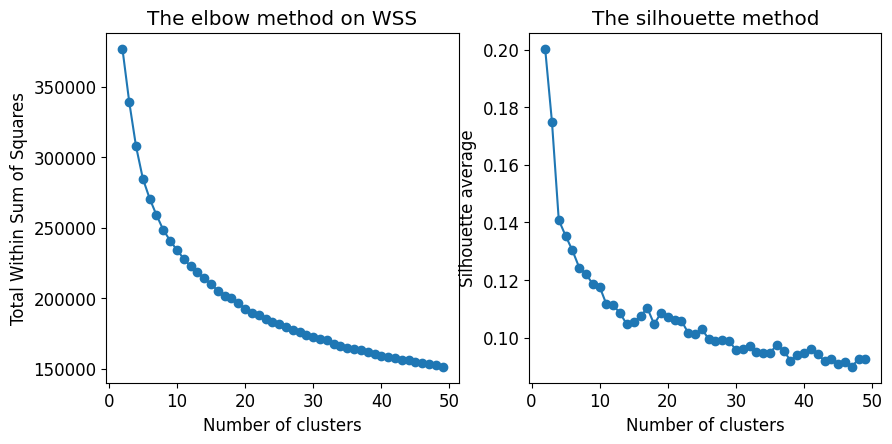

In [138]:
total_WSS = []
silhouette_avgs = []
K = range(2, 50)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeans.fit_predict(df_cleaned.loc[:, df_cleaned.columns != "cardio_disease"])

    # Elbow method on WSS
    total_WSS.append(kmeans.inertia_)

    # Silhouette method
    silhouette_avgs.append(silhouette_score(df_cleaned.loc[:, df_cleaned.columns != "cardio_disease"], cluster_labels))


plt.subplot(2, 2, 1)
plt.plot(K, total_WSS, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Total Within Sum of Squares')
plt.title('The elbow method on WSS')

plt.subplot(2, 2, 2)
plt.plot(K, silhouette_avgs, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette average')
plt.title('The silhouette method')

plt.show()

The dataset doesn't present clusters

## Predictive analysis

In [121]:
#dividing the dataset into two sets: train set and test set
def tt_split(dataframe):
  x = dataframe.loc[:, dataframe.columns!='cardio_disease']
  y = dataframe['cardio_disease']
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

  return X_train, X_test, y_train, y_test

In [122]:
classifiers = {
    "Decision Tree": (DecisionTreeClassifier(), {"predict_proba": True}, {'criterion': ("gini", "entropy"),
                                                                          'splitter': ("best", "random"),
                                                                          'class_weight': ["balanced"],
                                                                          'random_state': [1] }),

    "Random Forest": (RandomForestClassifier(), {"predict_proba": True},  {'n_estimators': [100],
                                                                           'criterion': ("gini", "entropy"),
                                                                           'class_weight': ["balanced"],
                                                                           'max_features': ("sqrt", "log2"),
                                                                           'random_state': [1] }),

    "XGBClassifier": (XGBClassifier(), {"predict_proba": True}, {'n_estimators': [100],
                                                                 'learning_rate': (0.01, 0.05, 0.1, 0.2, 0.3),
                                                                 'tree_method': ("exact", "approx", "hist"),
                                                                 'random_state': [1] }),

    "Nearest Neighbors": (KNeighborsClassifier(), {"predict_proba": True}, {'n_neighbors': (5, 7, 9), 
                                                                            'weights': ("uniform", "distance"),
                                                                            'algorithm': ("ball_tree", "kd_tree"),
                                                                            'p': (1, 2, 3),
                                                                            'n_jobs': [-1] }),

    "Logistic Regression": (LogisticRegression(), {"predict_proba": True}, {'C': (0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10),
                                                                            'solver': ('lbfgs', 'sag', 'saga'),
                                                                            'max_iter': [400],
                                                                            'n_jobs': [-1],
                                                                            'random_state': [1] }),

    #"SVC": (SVC(), {"predict_proba": True}, {'kernel': ("linear", "poly", "rbf", "sigmoid"),
    #                                         'C': (0.01, 0.1, 1, 5, 10),
    #                                         'probability': [True],
    #                                         'max_iter': [3000],
    #                                         'random_state': [1] }),

    "LinearSVC": (LinearSVC(), {"predict_proba": False}, {'C': (0.001, 0.01, 0.1, 1, 2, 5, 10),
                                                          'max_iter': [3000], 
                                                          'random_state': [1] }),

    "MLPClassifier": (MLPClassifier(), {"predict_proba": True}, {'hidden_layer_sizes': ((8, 4), (8, 4, 4)), 
                                                                 'activation': ["relu"],
                                                                 'learning_rate': ("constant", "adaptive"),
                                                                 'learning_rate_init': (0.001, 0.005, 0.01, 0.1, 0.15, 0.2),
                                                                 'max_iter': [400],
                                                                 'random_state': [1] })
}

In [123]:
result_matrixes = dict()


def classification(classifiers, X_train, y_train, X_test, y_test, n_iter=5):
  result_matrix = pd.DataFrame(columns=["Classifier", "Accuracy", "Accuracy (train)",  "Precision", "Precision (train)", 
                                        "Recall", "Recall (train)", "F1-Score", "F1-Score (train)", "ROC AUC", "ROC AUC (train)"])

  for name, clf in classifiers.items():
    print("Classifier: ", name)

    # Hyperparameters optimization
    if clf[2] != None:
      if len(list(ParameterGrid(clf[2]))) <= n_iter: classifier = GridSearchCV(estimator=clf[0], param_grid=clf[2], n_jobs=-1)
      else: classifier = RandomizedSearchCV(estimator=clf[0], param_distributions=clf[2], n_jobs=-1, n_iter=n_iter, random_state=1)
      classifier.fit(X_train, y_train)
      print("Best hyperparameters : {}".format(classifier.best_params_))
    else:
      classifier = clf[0]
      classifier.fit(X_train, y_train)
    
    # Predicion task handled by the best estimator found by the hyperparameter cross validator
    y_pred = classifier.predict(X_test)
    y_pred_train = classifier.predict(X_train)
            
    # Getting predicted probabilities
    if clf[1]["predict_proba"] == True:
      y_score = classifier.predict_proba(X_test)[:,1]
      #display("Predicted probability: ", y_score)
      y_score_train = classifier.predict_proba(X_train)[:,1]
      #display("Predicted probability: ", y_score_train)

    # Test set metrics
    pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
    pr_train, rc_train, fs_train, sup_train = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='macro')
    result_matrix = pd.concat([result_matrix, pd.DataFrame({"Classifier": name,
                                                            "Accuracy": round(metrics.accuracy_score(y_test, y_pred), 4),
                                                            "Accuracy (train)": round(metrics.accuracy_score(y_train, y_pred_train), 4),
                                                            "Precision": round(pr, 4),
                                                            "Precision (train)": round(pr_train, 4),
                                                            "Recall": round(rc, 4),
                                                            "Recall (train)": round(rc_train, 4),
                                                            "F1-Score": round(fs, 4),
                                                            "F1-Score (train)": round(fs_train, 4),
                                                            "ROC AUC": roc_auc_score(y_test, y_score) if clf[1]["predict_proba"] else None,
                                                            "ROC AUC (train)": roc_auc_score(y_train, y_score_train) if clf[1]["predict_proba"] else None }, index=[0])])

    # Confusion matrix for test set
    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 1, 1)
    cf_plot = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
    cf_plot.set_title("Confusion matrix - test set")
    cf_plot.set_xlabel("Predicted label")
    cf_plot.set_ylabel("True label")

    # Confusion matrix for train set
    plt.subplot(2, 1, 2)
    cf_matrix = confusion_matrix(y_train, y_pred_train)
    cf_plot_train = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
    cf_plot_train.set_title("Confusion matrix - training set")
    cf_plot_train.set_xlabel("Predicted label")
    cf_plot_train.set_ylabel("True label")

    plt.subplots_adjust(top=1)
    plt.show()

    # ROC AUC curve
    if name != "Kmeans":
      RocCurveDisplay.from_estimator(classifier, X_test, y_test)  
      print("ROC curve - test set")
      plt.show()
      RocCurveDisplay.from_estimator(classifier, X_train, y_train)  
      print("ROC curve - training set")
      plt.show()


  result_matrix.set_index("Accuracy", inplace=True)
  result_matrix.sort_values(by="Accuracy", ascending=False, inplace=True)
  
  return result_matrix

### Plain dataset

Classifier:  Decision Tree
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'best'}


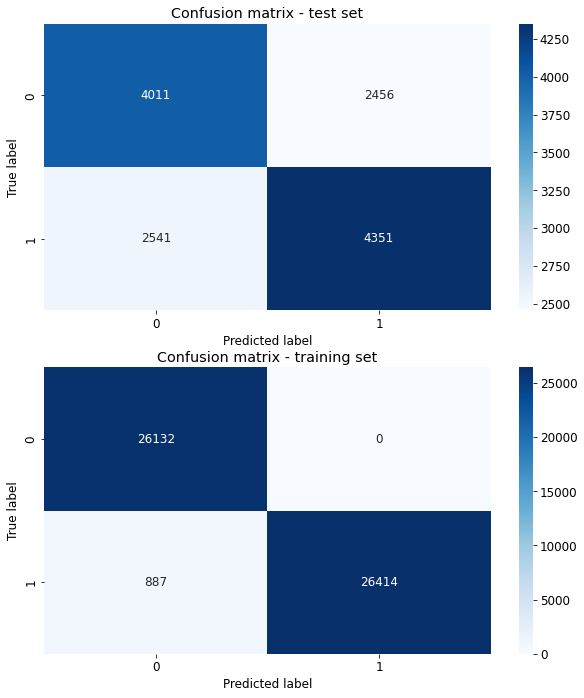

ROC curve - test set


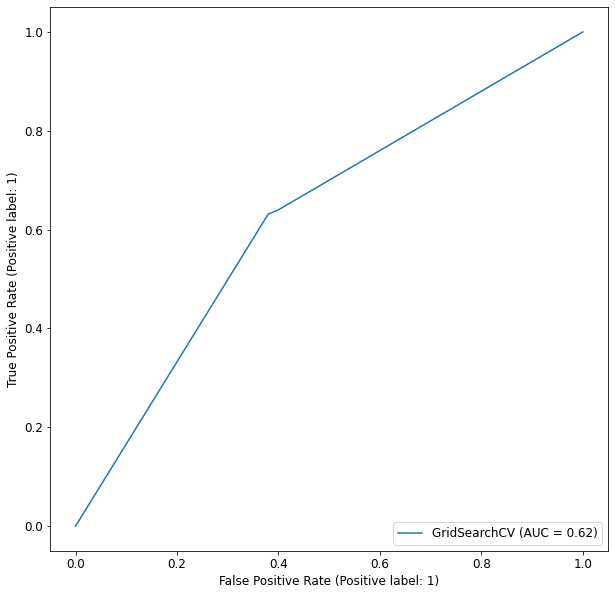

ROC curve - training set


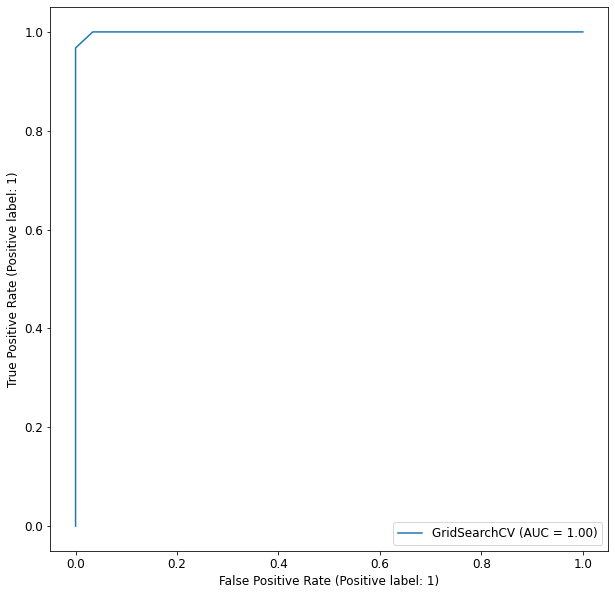

Classifier:  Random Forest
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


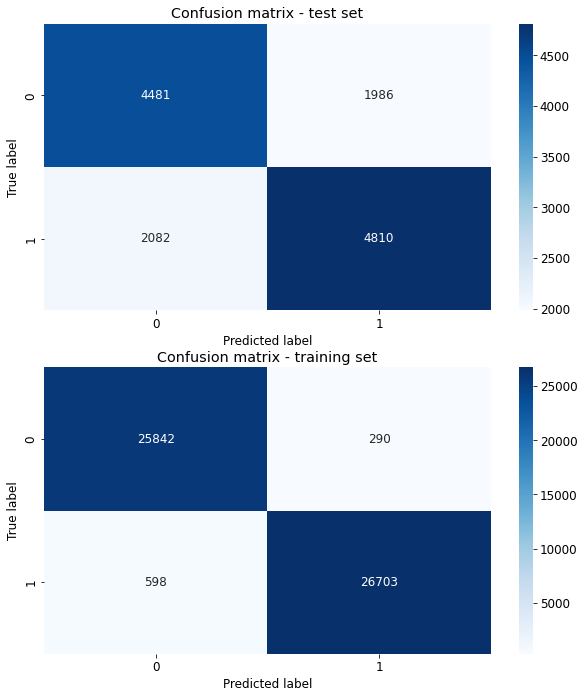

ROC curve - test set


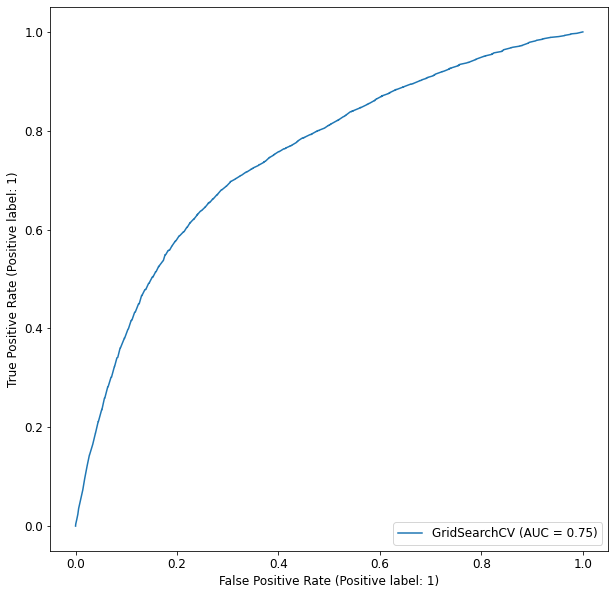

ROC curve - training set


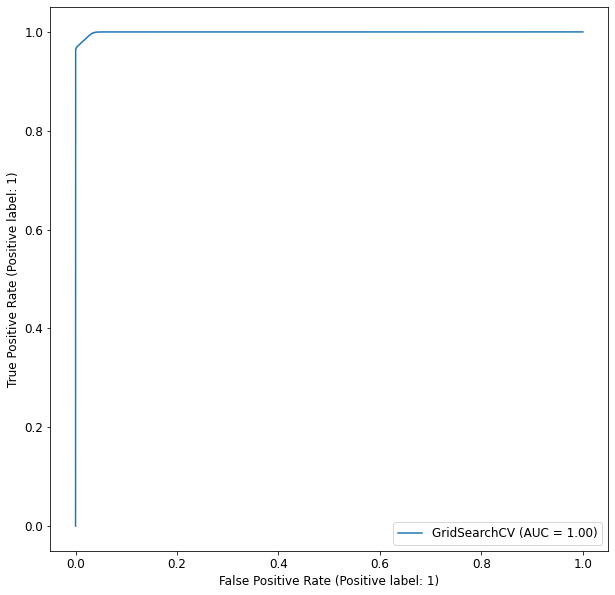

Classifier:  XGBClassifier
Best hyperparameters : {'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 1, 'tree_method': 'approx'}


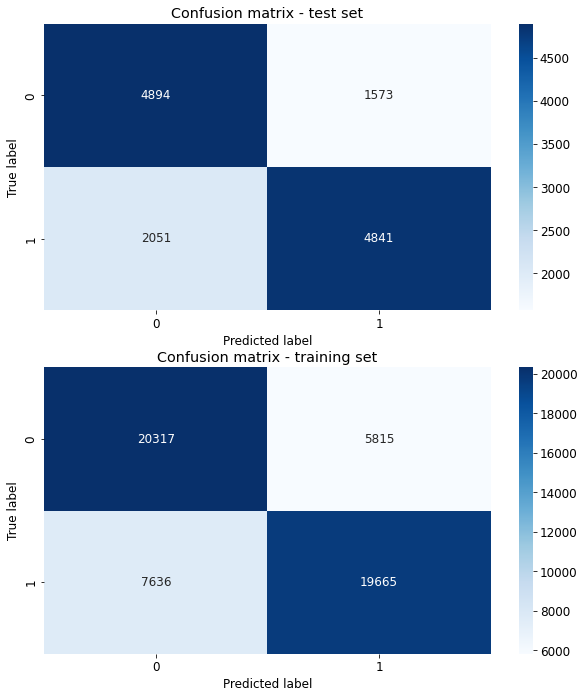

ROC curve - test set


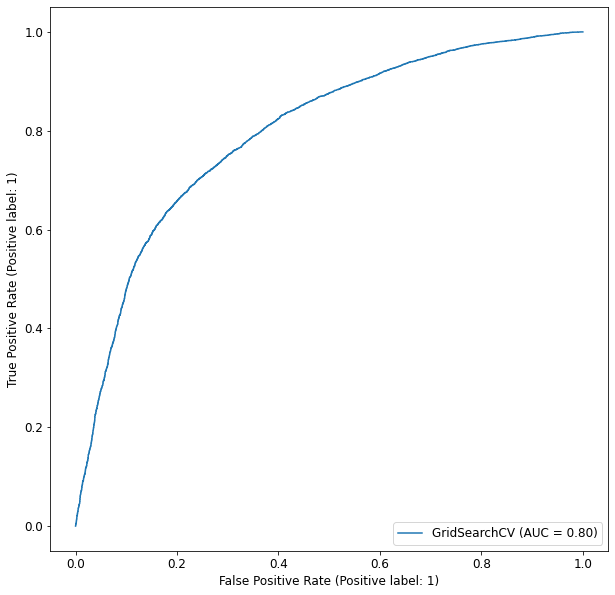

ROC curve - training set


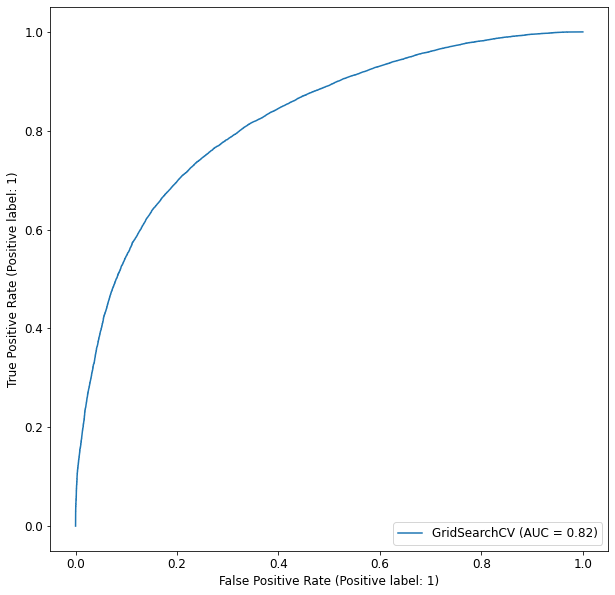

Classifier:  Nearest Neighbors
Best hyperparameters : {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


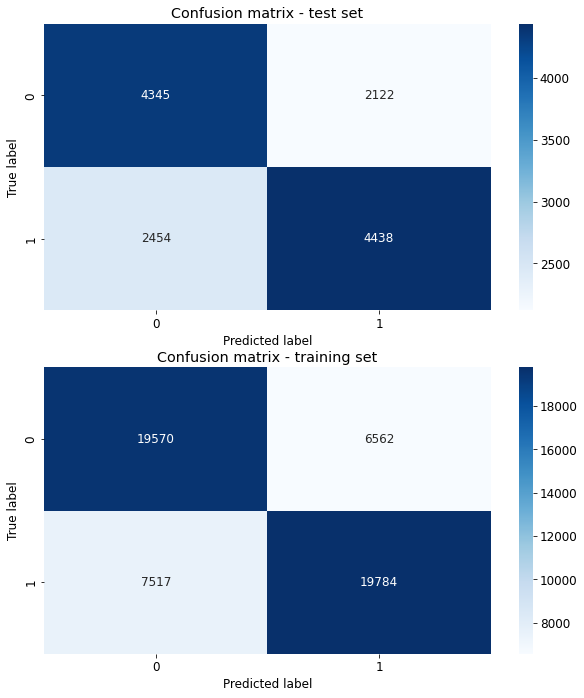

ROC curve - test set


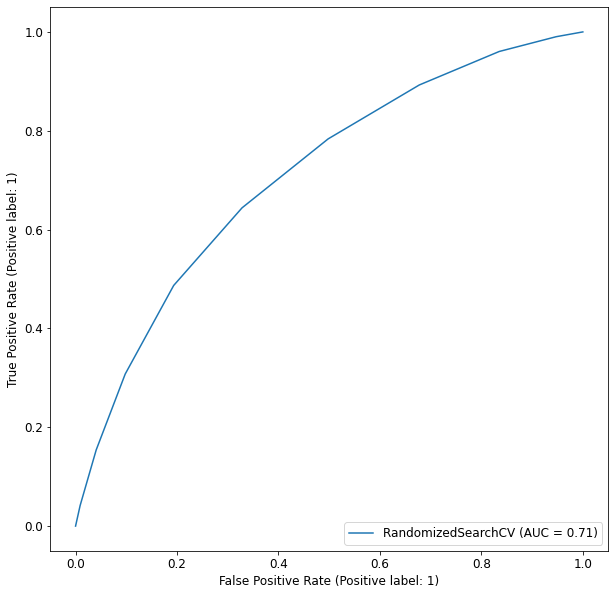

ROC curve - training set


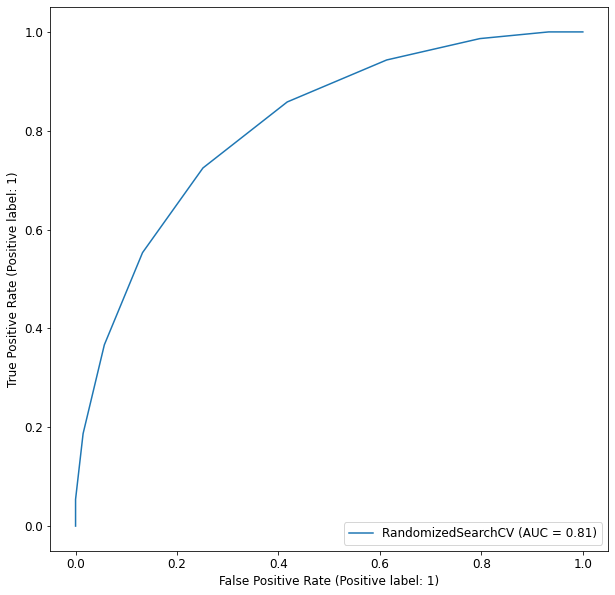

Classifier:  Logistic Regression
Best hyperparameters : {'solver': 'lbfgs', 'random_state': 1, 'n_jobs': -1, 'max_iter': 400, 'C': 10}


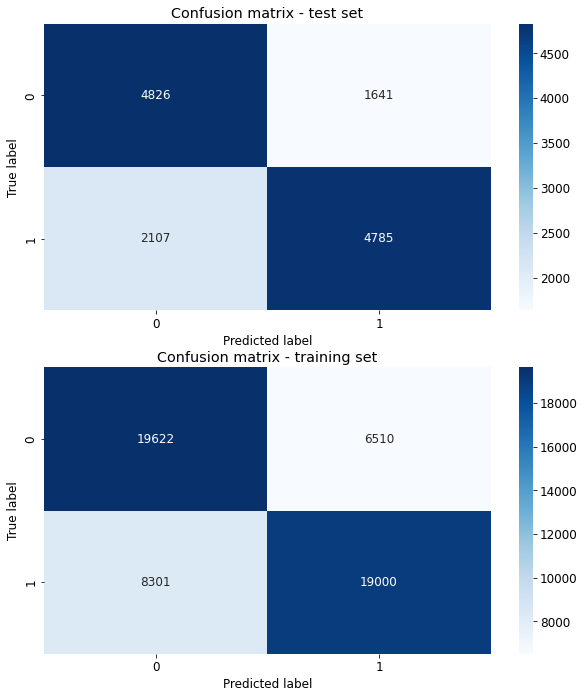

ROC curve - test set


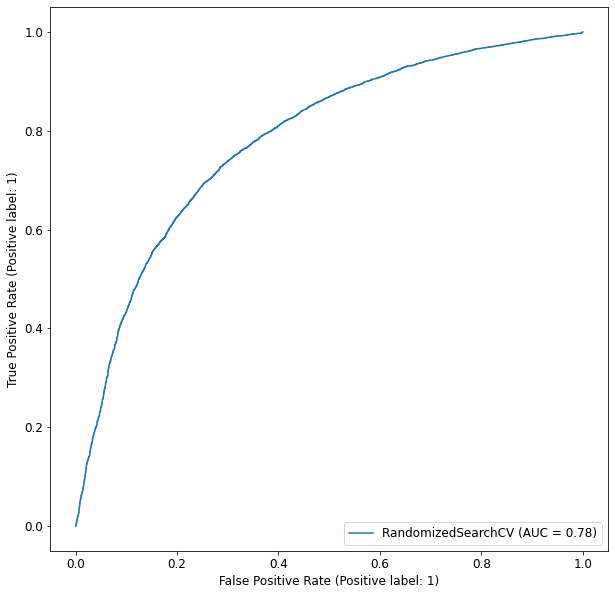

ROC curve - training set


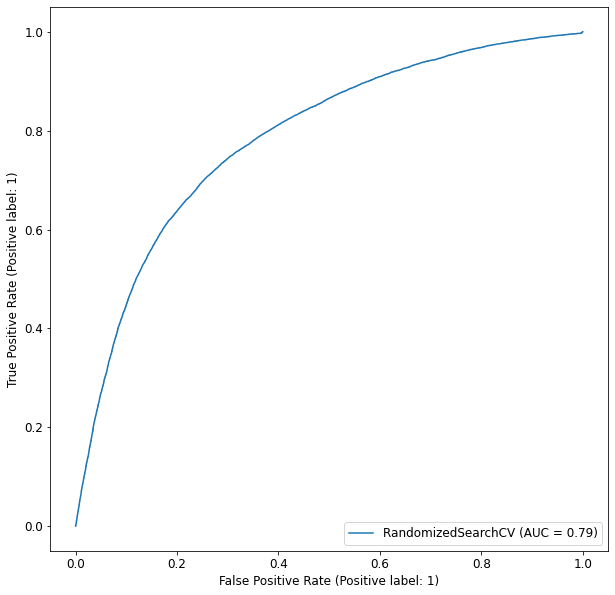

Classifier:  LinearSVC


c:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameters : {'C': 10, 'max_iter': 3000, 'random_state': 1}


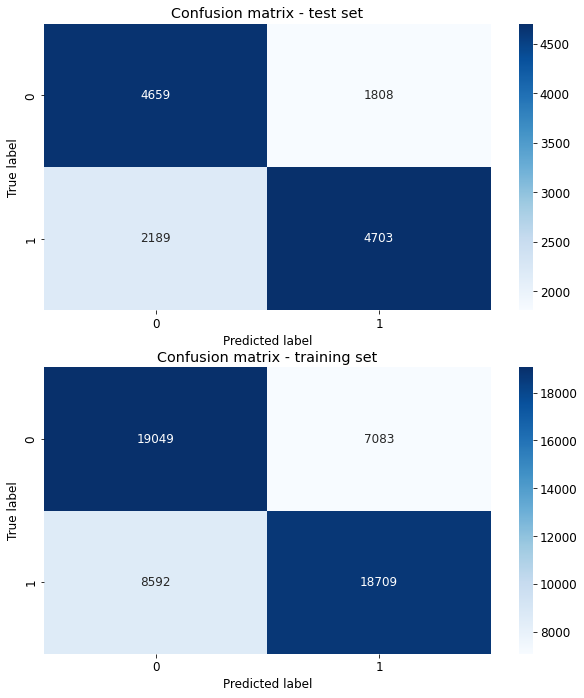

ROC curve - test set


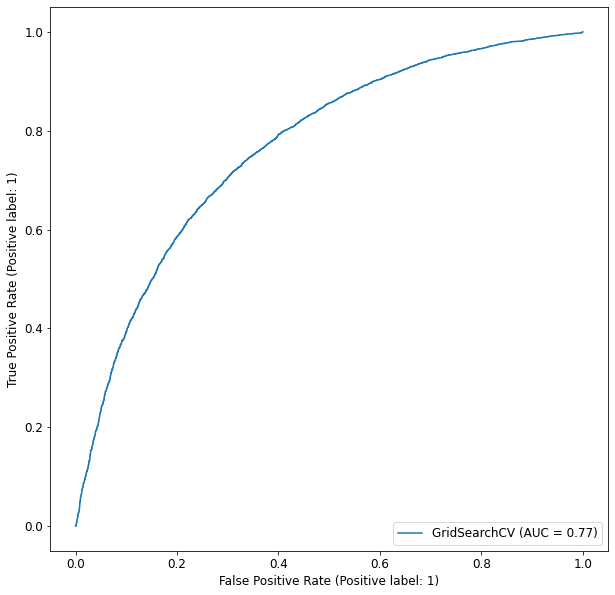

ROC curve - training set


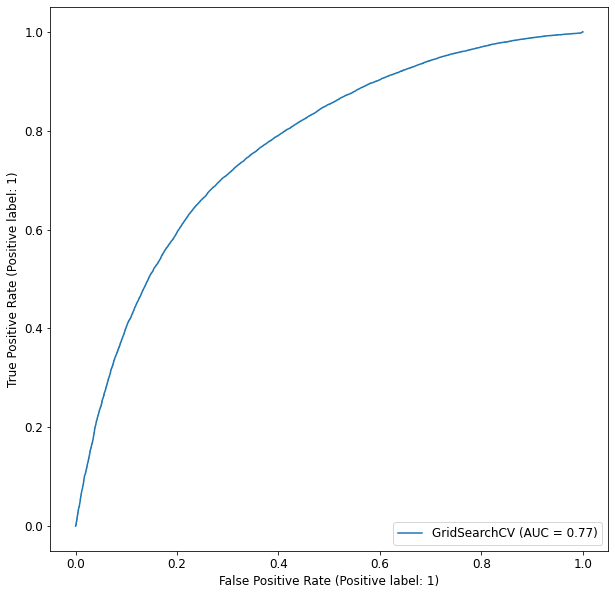

Classifier:  MLPClassifier
Best hyperparameters : {'random_state': 1, 'max_iter': 400, 'learning_rate_init': 0.005, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (8, 4), 'activation': 'relu'}


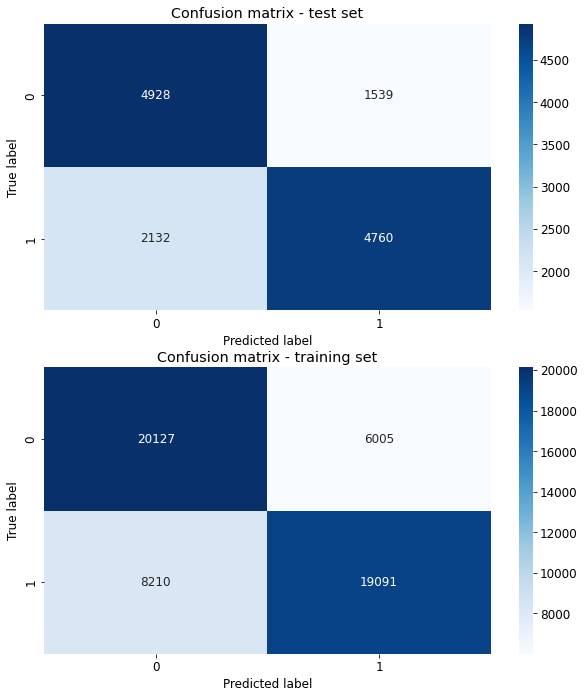

ROC curve - test set


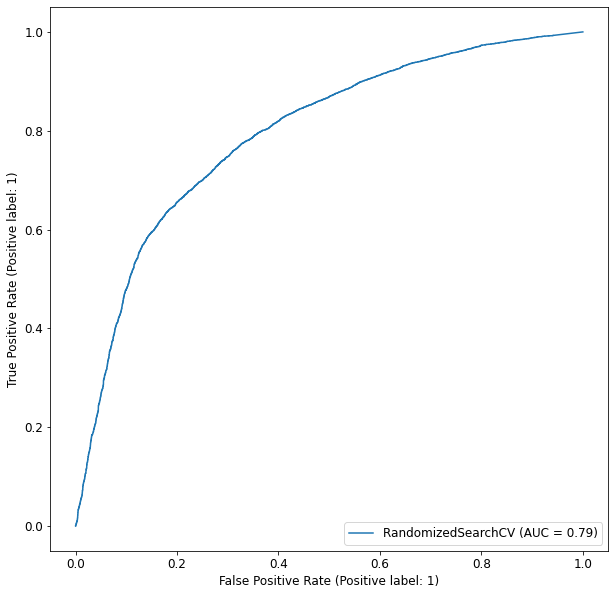

ROC curve - training set


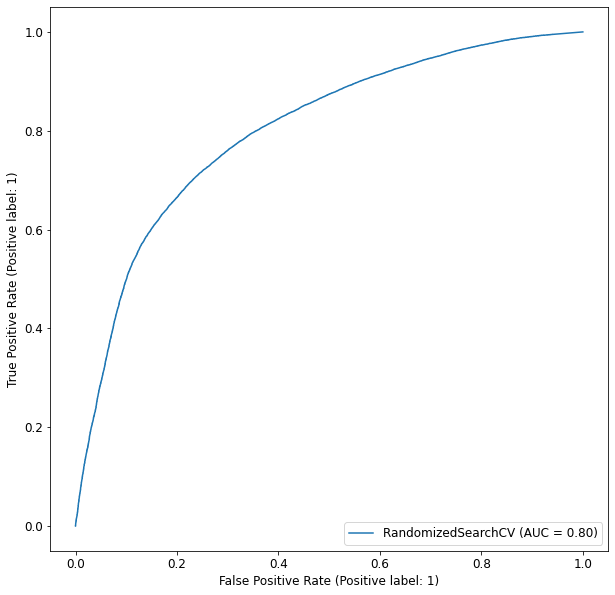

c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7287          XGBClassifier           0.7483    0.7297            0.7493   
0.7252          MLPClassifier            0.734    0.7268            0.7355   
0.7194    Logistic Regression           0.7228    0.7204            0.7238   
0.7008              LinearSVC           0.7066    0.7013            0.7073   
0.6955          Random Forest           0.9834    0.6953            0.9833   
0.6575      Nearest Neighbors           0.7365    0.6578            0.7367   
0.6259          Decision Tree           0.9834    0.6257            0.9836   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7287    0.7296         0.7489   0.7287           0.7482  0.796294   
0.7252    0.7263         0.7347   0.7252           0.7339  0.793367   
0.7194    0.7203         0.7234   0.7194           0.7228  0.782195   
0.7008    0.7014         0.7071   0.7008           0.7066      None   
0.6955    0.6954         0.9835   0.6953           0.9834  0.747861   
0.6575    0.6579         0.7368   0.6574           0.7365  0.710192   
0.6259    0.6258         0.9838   0.6257           0.9834  0.624746   

         ROC AUC (train)  
Accuracy                  
0.7287          0.824923  
0.7252          0.800333  
0.7194          0.786427  
0.7008              None  
0.6955           0.99942  
0.6575          0.811537  
0.6259          0.999449

In [124]:
X_train, X_test, y_train, y_test = tt_split(df)

result_matrixes["Plain dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=15)
display(result_matrixes["Plain dataset"])

### Cleaned dataset

Classifier:  Decision Tree
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'gini', 'random_state': 1, 'splitter': 'best'}


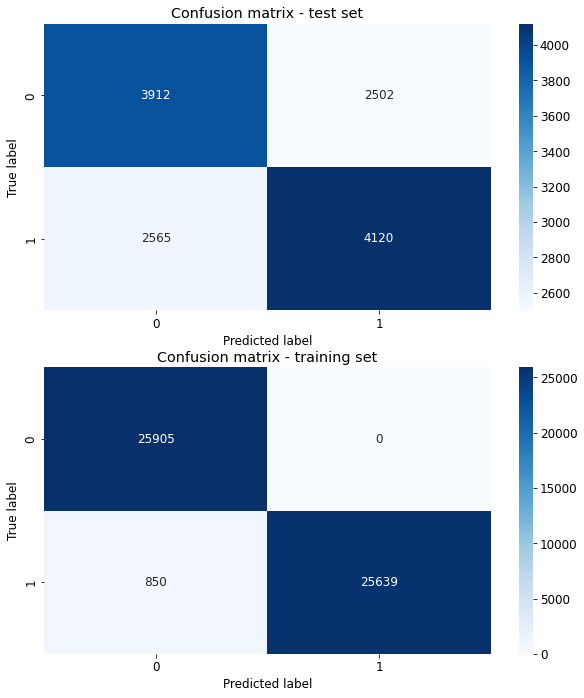

ROC curve - test set


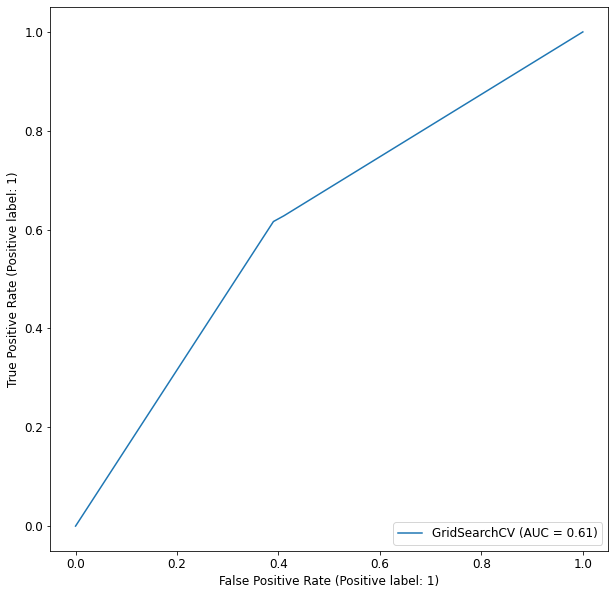

ROC curve - training set


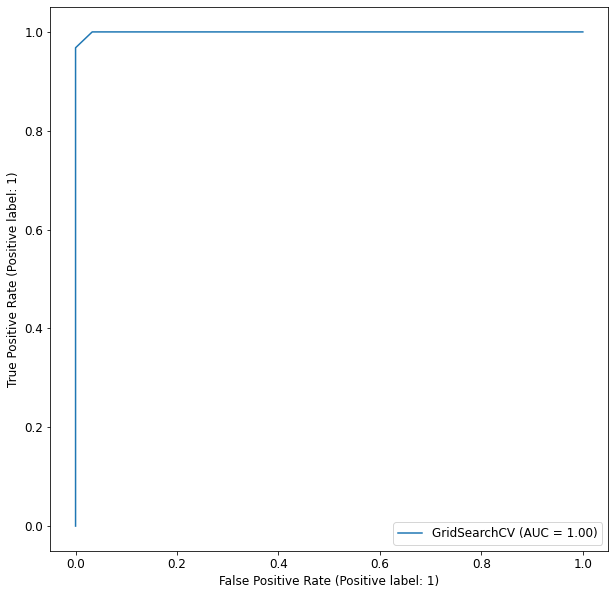

Classifier:  Random Forest
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


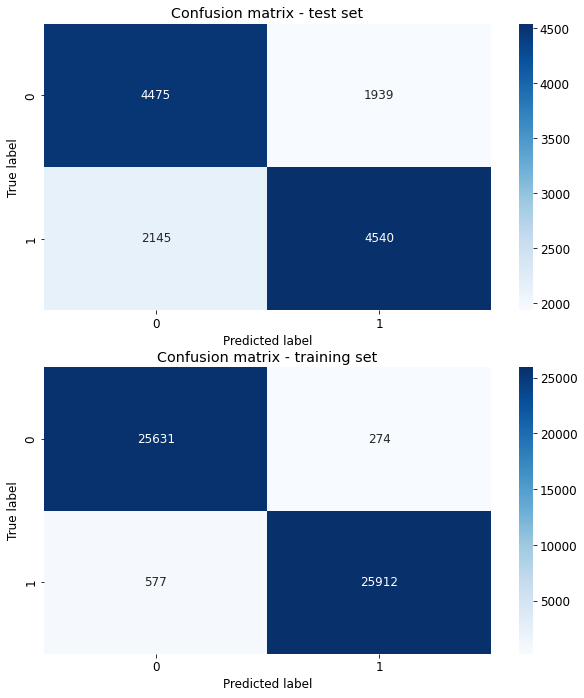

ROC curve - test set


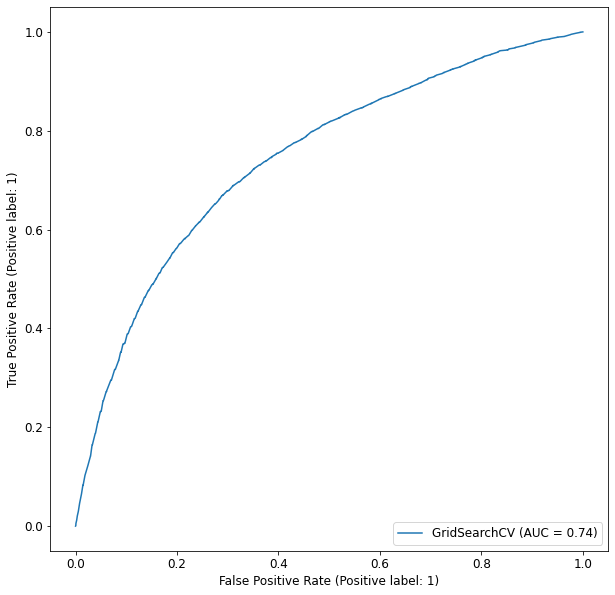

ROC curve - training set


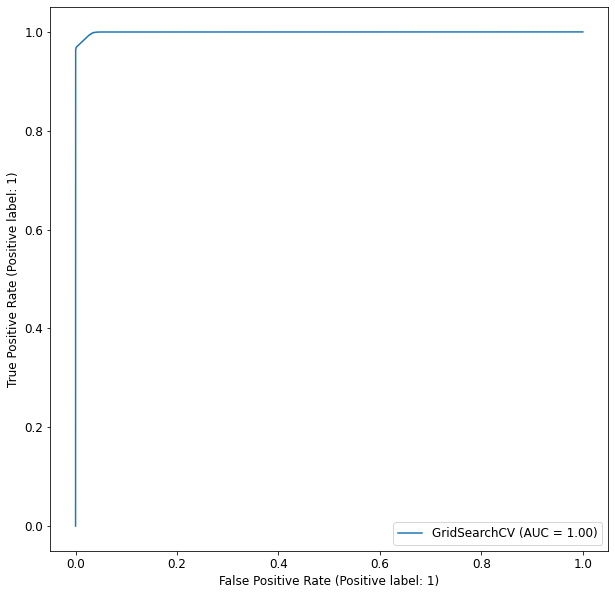

Classifier:  XGBClassifier
Best hyperparameters : {'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 1, 'tree_method': 'exact'}


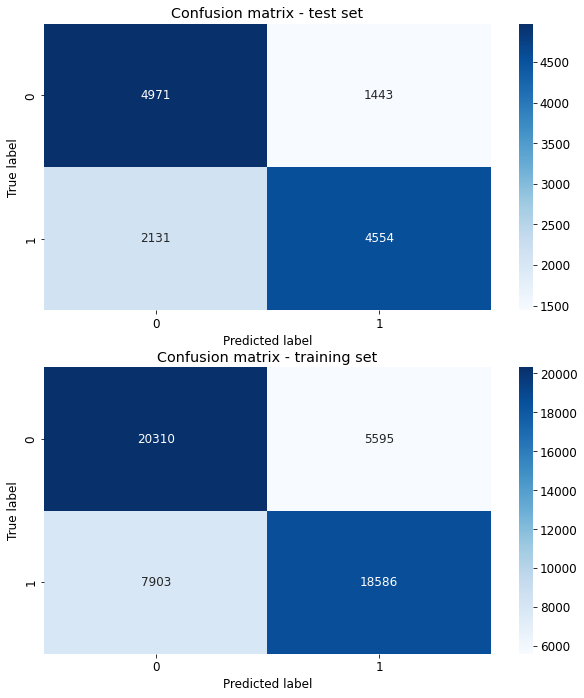

ROC curve - test set


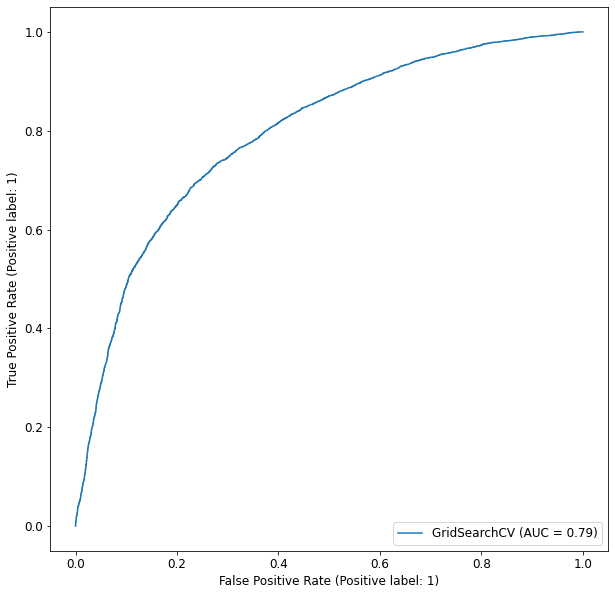

ROC curve - training set


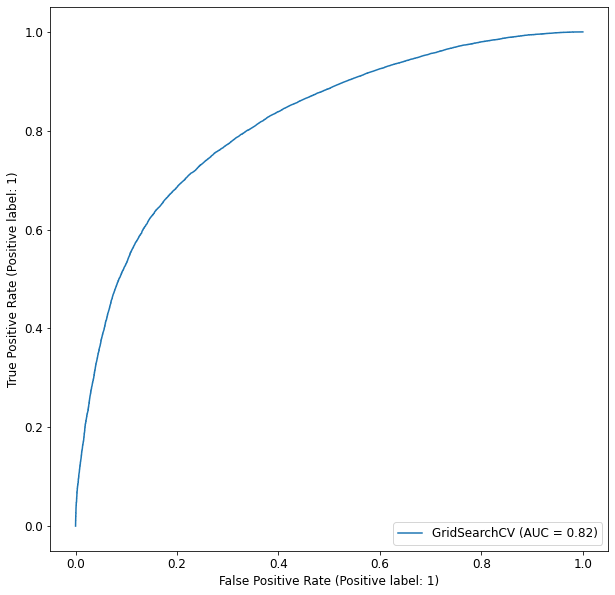

Classifier:  Nearest Neighbors
Best hyperparameters : {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


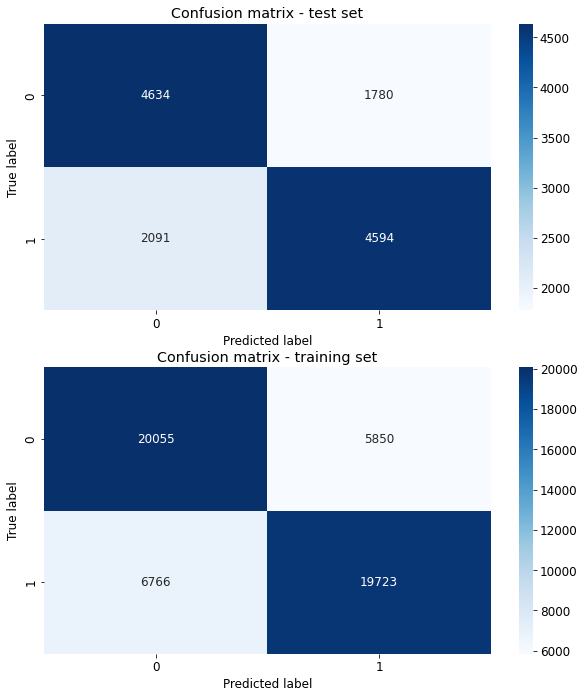

ROC curve - test set


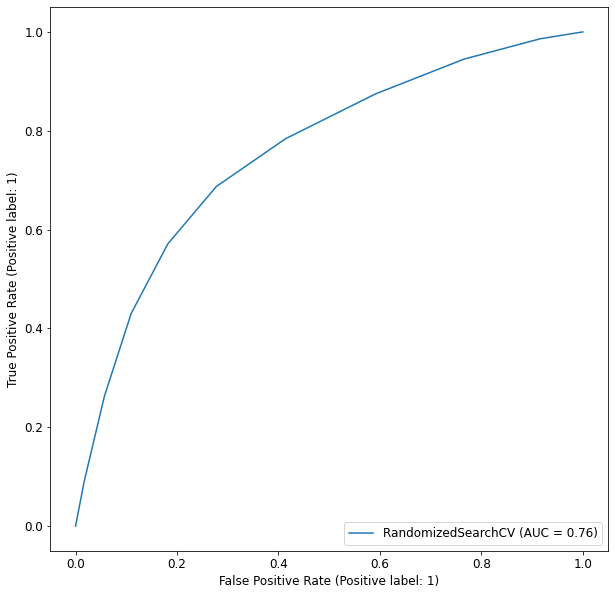

ROC curve - training set


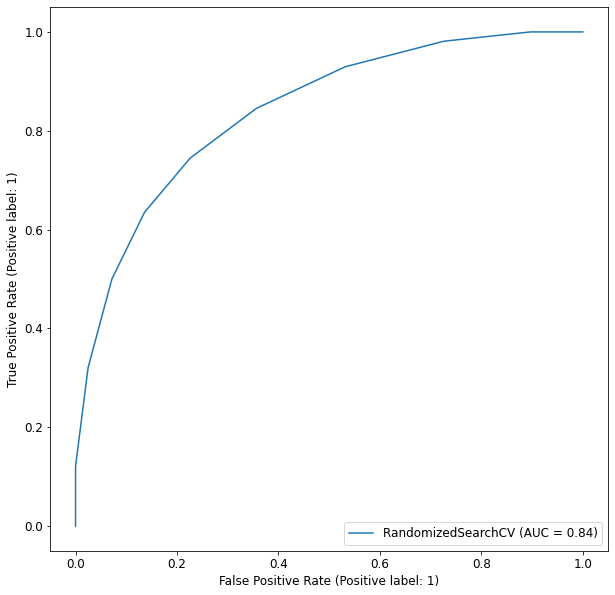

Classifier:  Logistic Regression
Best hyperparameters : {'solver': 'sag', 'random_state': 1, 'n_jobs': -1, 'max_iter': 400, 'C': 0.1}


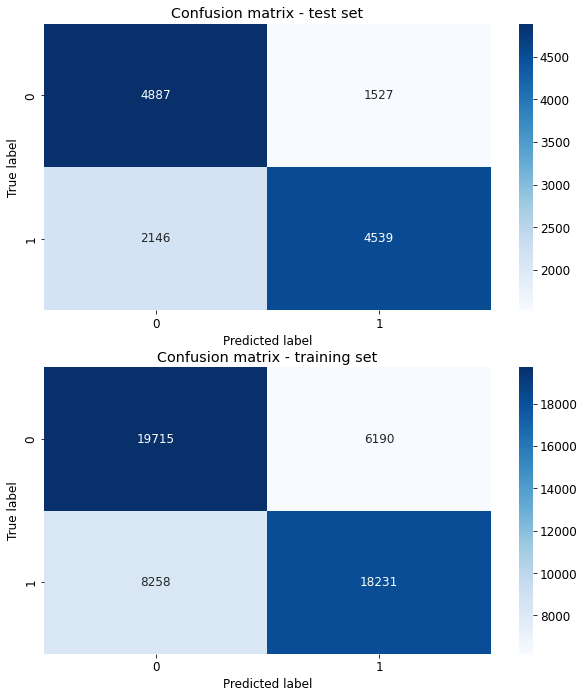

ROC curve - test set


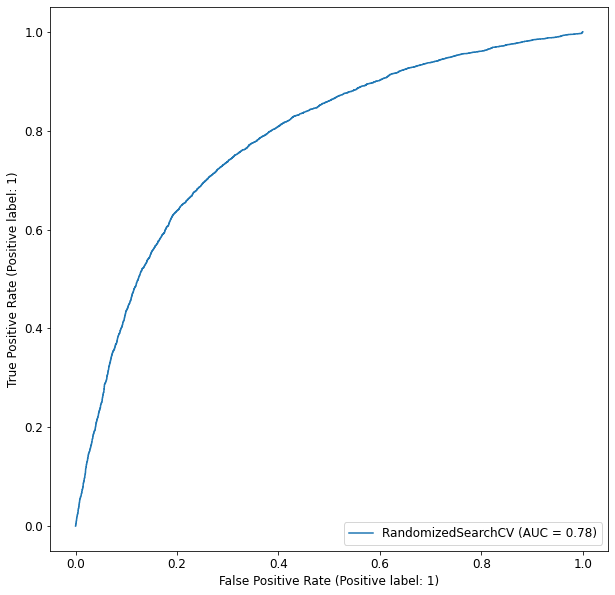

ROC curve - training set


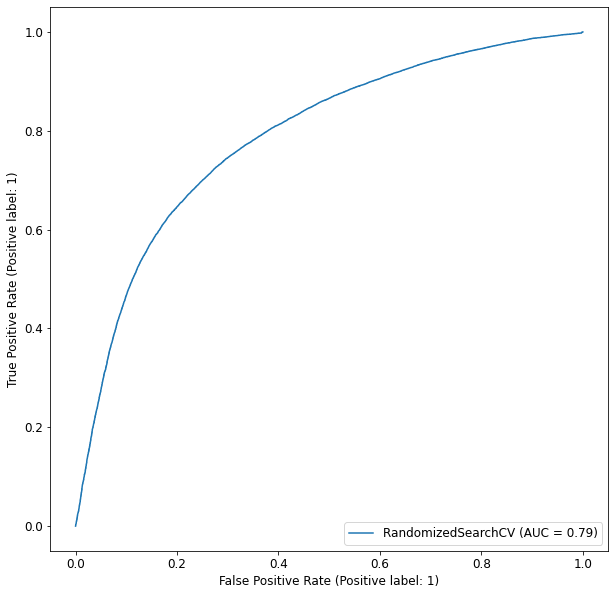

Classifier:  LinearSVC


c:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameters : {'C': 10, 'max_iter': 3000, 'random_state': 1}


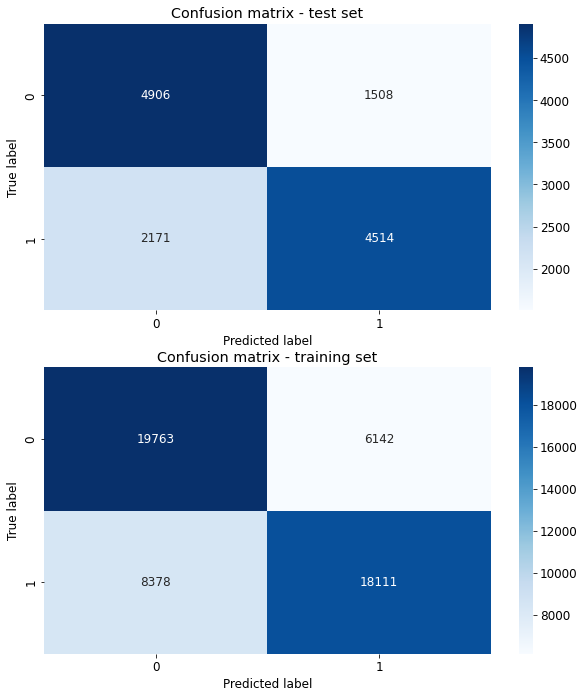

ROC curve - test set


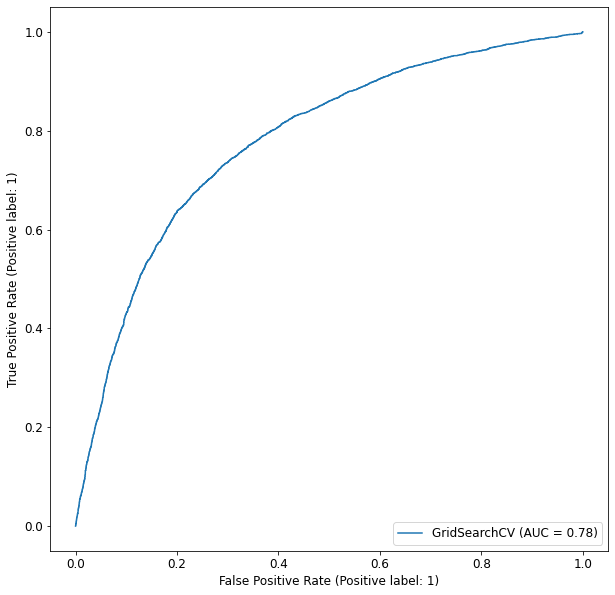

ROC curve - training set


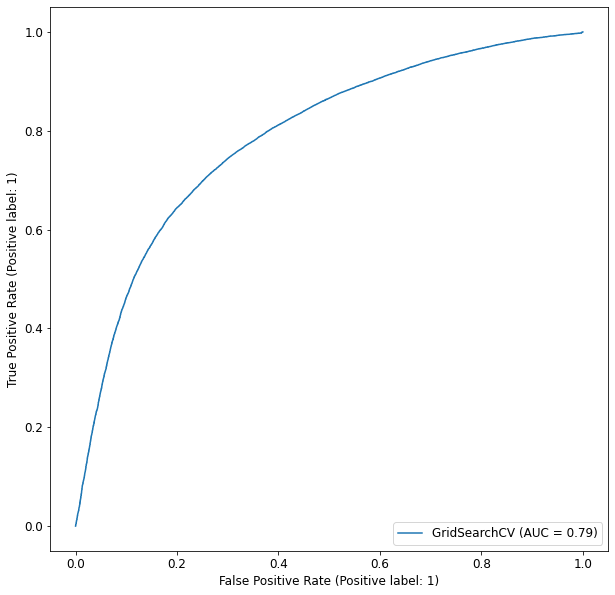

Classifier:  MLPClassifier
Best hyperparameters : {'random_state': 1, 'max_iter': 400, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (8, 4, 4), 'activation': 'relu'}


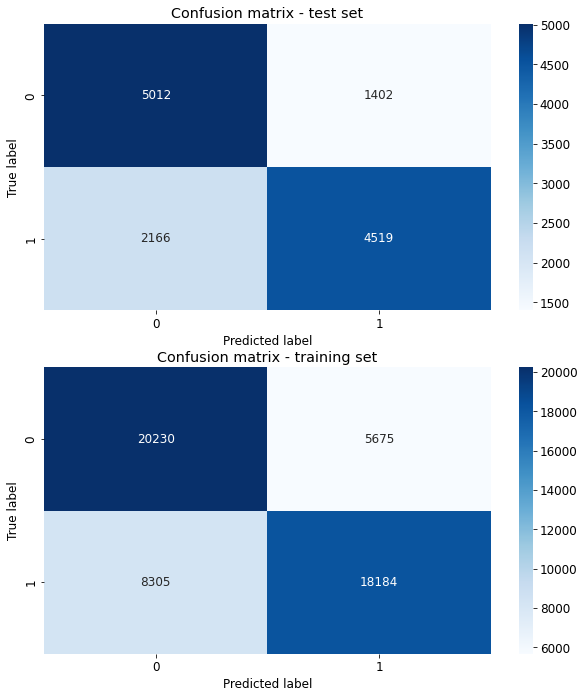

ROC curve - test set


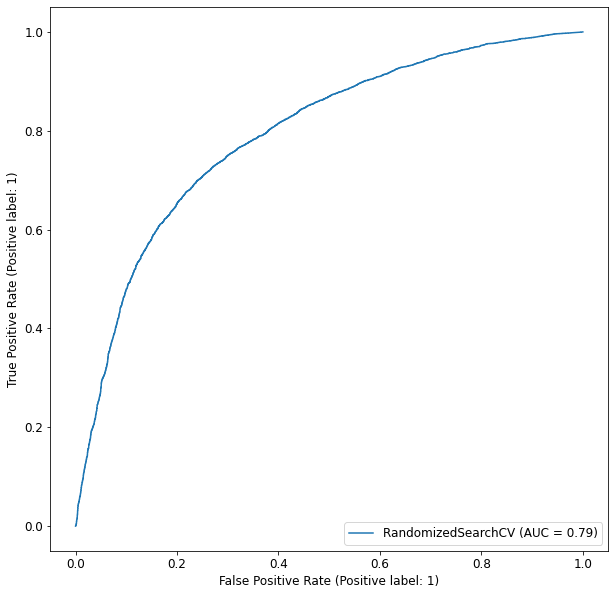

ROC curve - training set


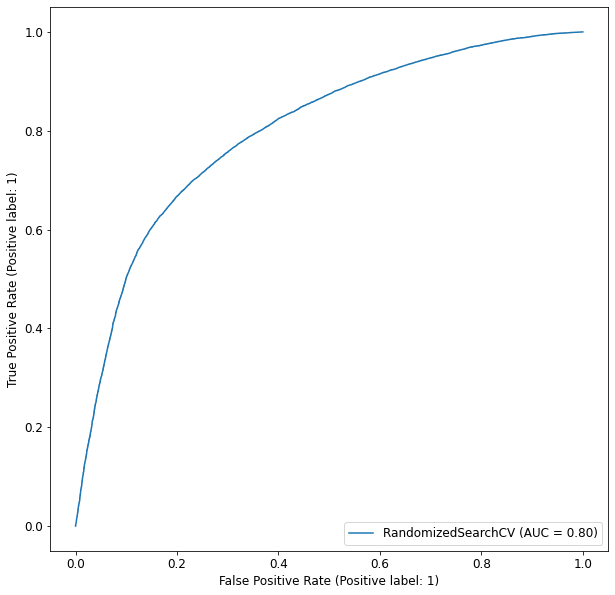

c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7276          MLPClassifier           0.7332    0.7307            0.7355   
0.7272          XGBClassifier           0.7424    0.7297            0.7443   
0.7196    Logistic Regression           0.7242    0.7216            0.7257   
0.7191              LinearSVC           0.7229    0.7214            0.7245   
0.7045      Nearest Neighbors           0.7592    0.7049            0.7595   
0.6882          Random Forest           0.9838    0.6884            0.9838   
0.6132          Decision Tree           0.9838    0.6131            0.9841   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7276    0.7287         0.7337   0.7272           0.7328   0.79295   
0.7272    0.7281         0.7428   0.7269           0.7421  0.793989   
0.7196    0.7205         0.7246   0.7194            0.724  0.781189   
0.7191    0.7201         0.7233   0.7189           0.7226      None   
0.7045    0.7048         0.7594   0.7045           0.7592  0.757036   
0.6882    0.6884         0.9838   0.6882           0.9838  0.743214   
0.6132    0.6131          0.984   0.6131           0.9838  0.612691   

         ROC AUC (train)  
Accuracy                  
0.7276          0.800408  
0.7272          0.817191  
0.7196          0.788357  
0.7191              None  
0.7045          0.840566  
0.6882          0.999439  
0.6132          0.999474

In [125]:
X_train, X_test, y_train, y_test = tt_split(df_cleaned)

result_matrixes["Cleaned dataset"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=15)
display(result_matrixes["Cleaned dataset"])

### Cleaned dataset without subjective features

Classifier:  Decision Tree
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'best'}


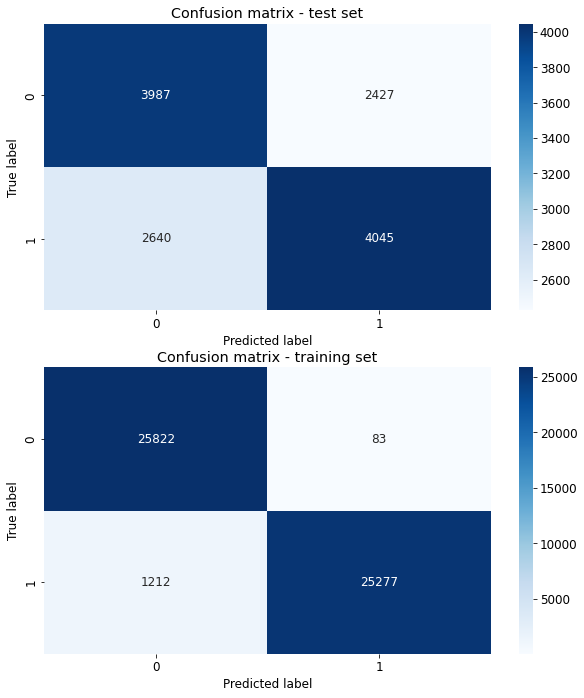

ROC curve - test set


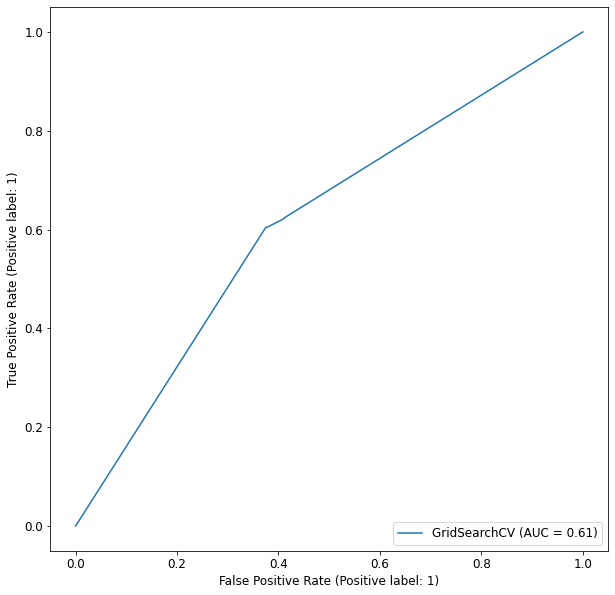

ROC curve - training set


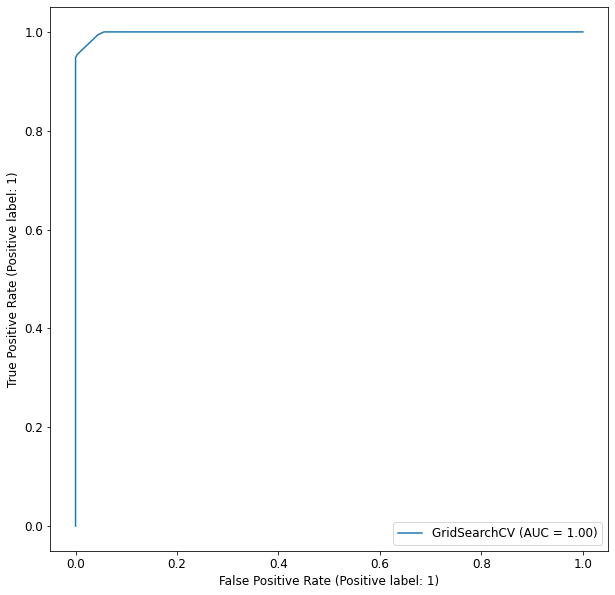

Classifier:  Random Forest
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


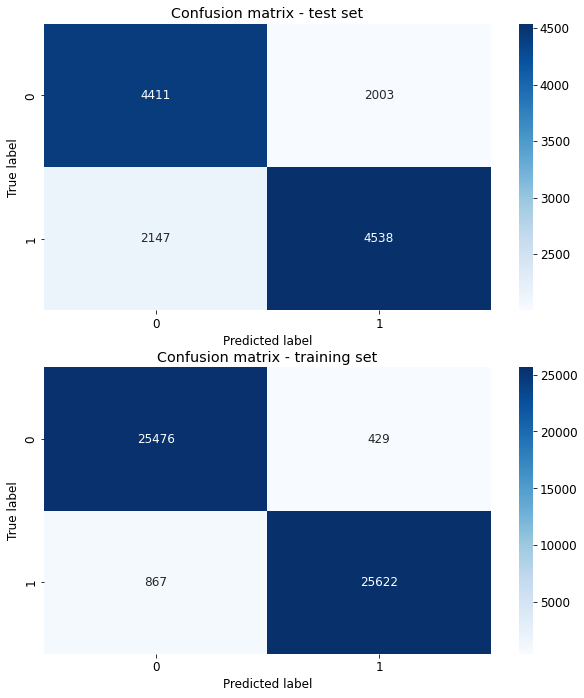

ROC curve - test set


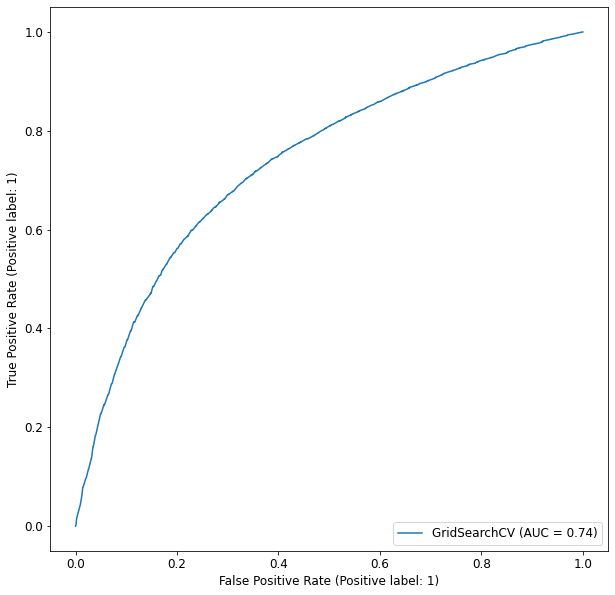

ROC curve - training set


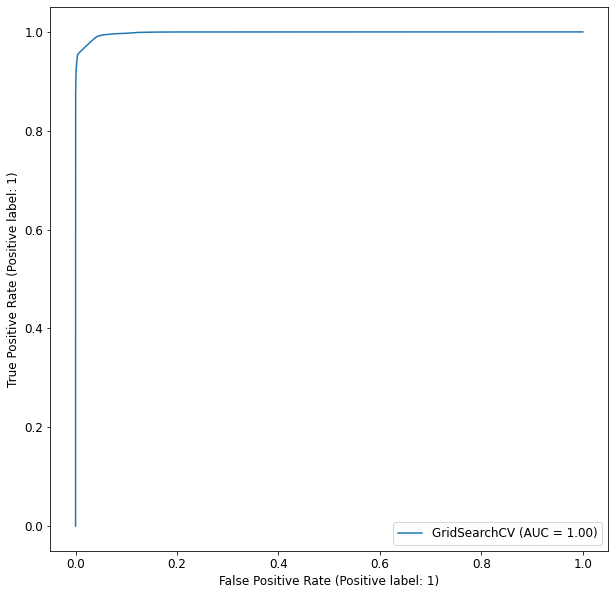

Classifier:  XGBClassifier
Best hyperparameters : {'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 1, 'tree_method': 'hist'}


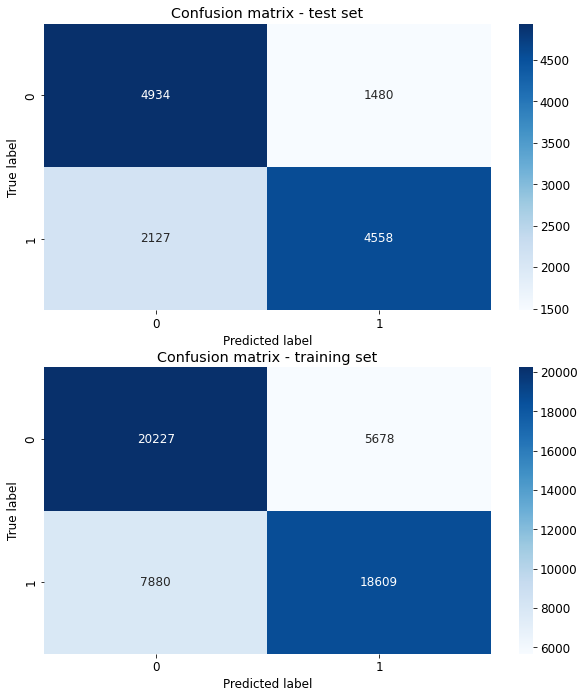

ROC curve - test set


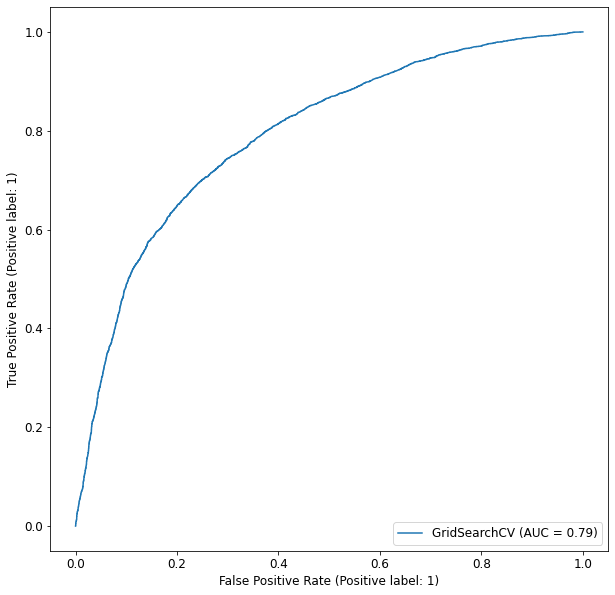

ROC curve - training set


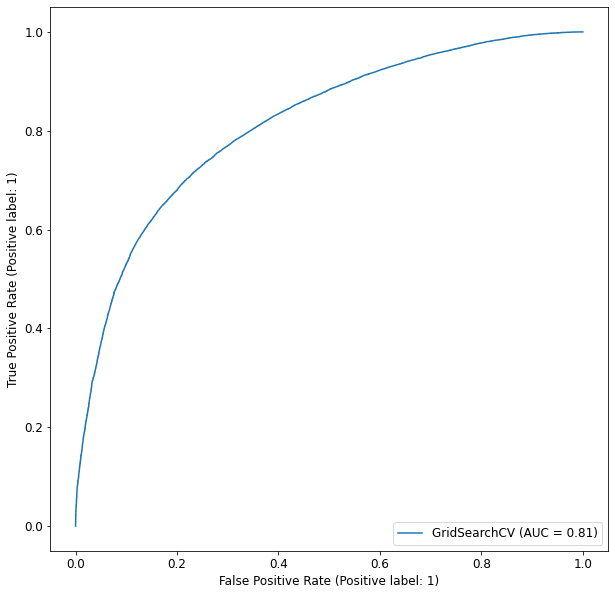

Classifier:  Nearest Neighbors
Best hyperparameters : {'weights': 'uniform', 'p': 3, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


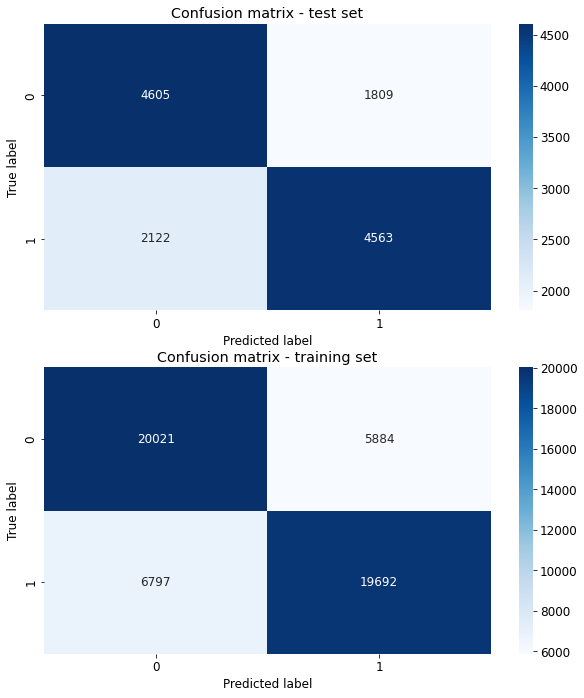

ROC curve - test set


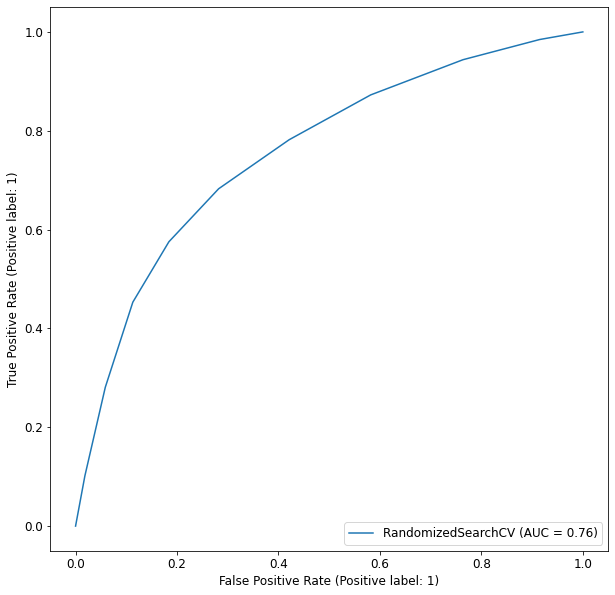

ROC curve - training set


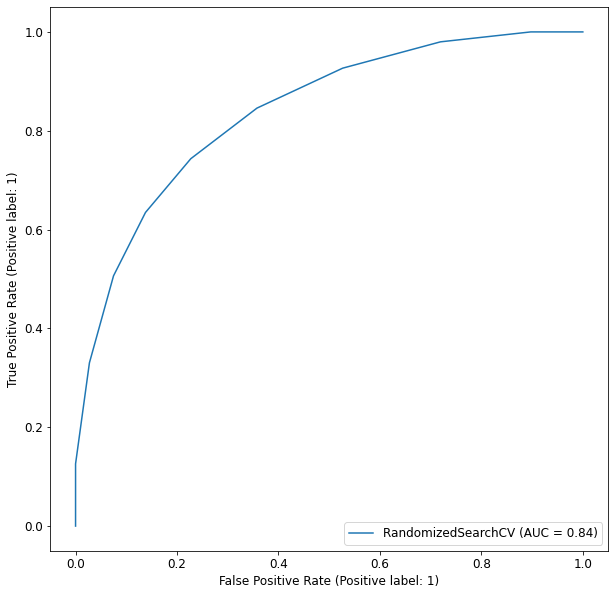

Classifier:  Logistic Regression
Best hyperparameters : {'solver': 'sag', 'random_state': 1, 'n_jobs': -1, 'max_iter': 400, 'C': 0.1}


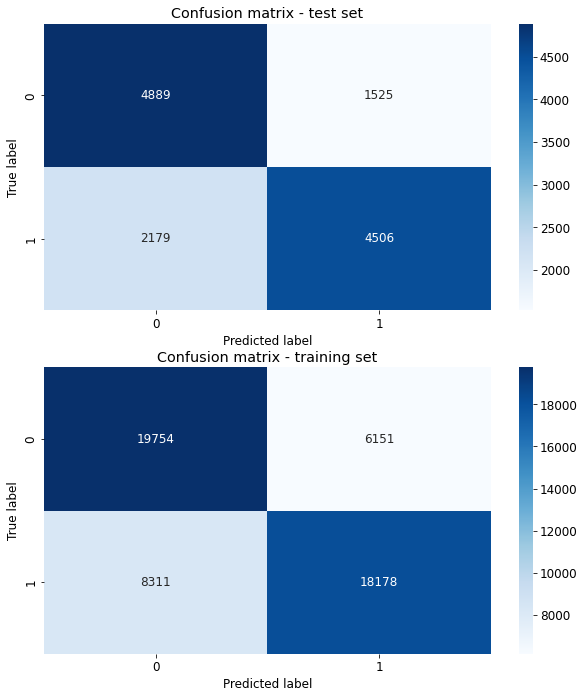

ROC curve - test set


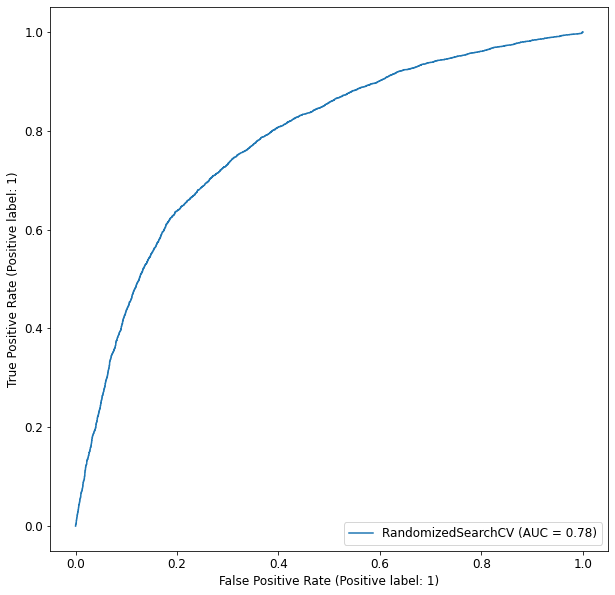

ROC curve - training set


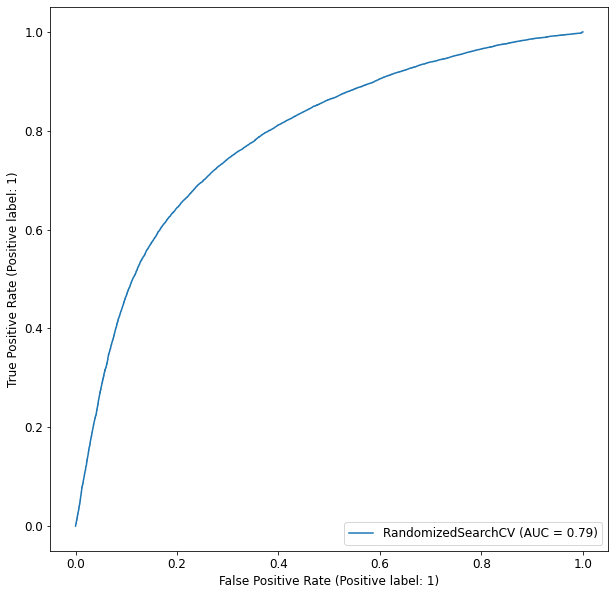

Classifier:  LinearSVC
Best hyperparameters : {'C': 0.01, 'max_iter': 3000, 'random_state': 1}


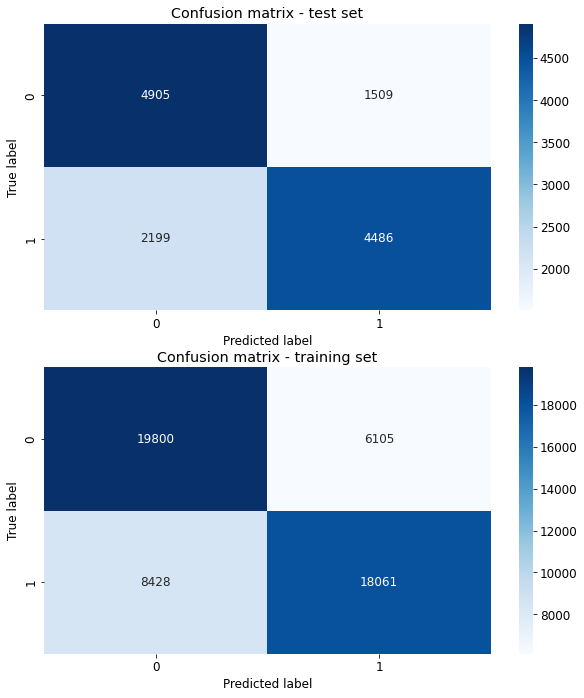

ROC curve - test set


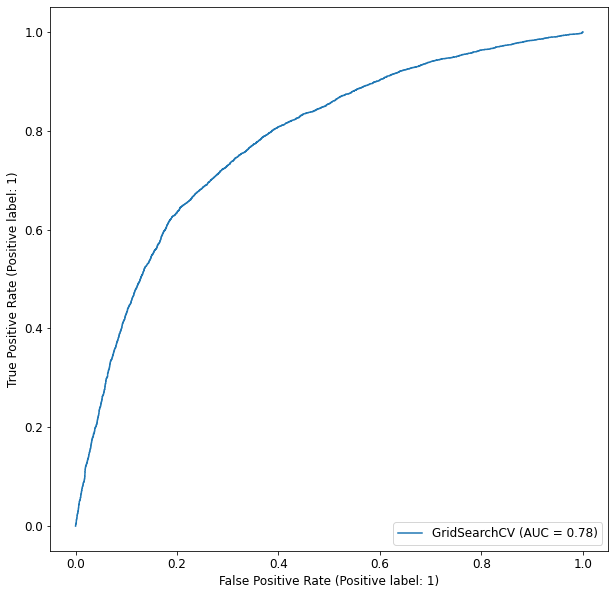

ROC curve - training set


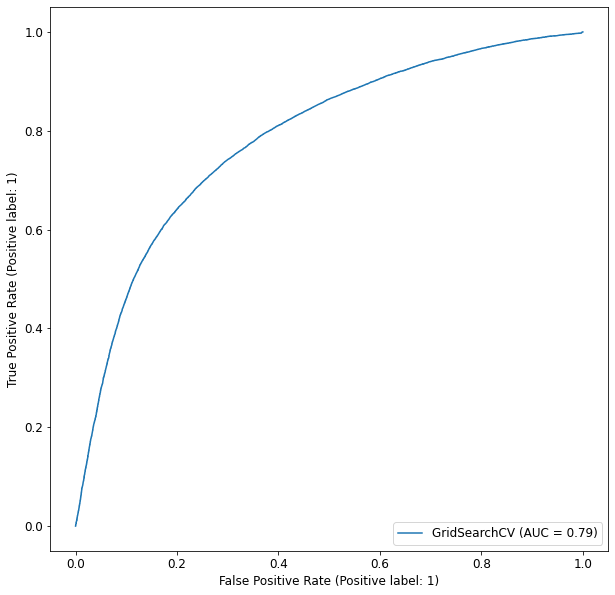

Classifier:  MLPClassifier
Best hyperparameters : {'random_state': 1, 'max_iter': 400, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (8, 4), 'activation': 'relu'}


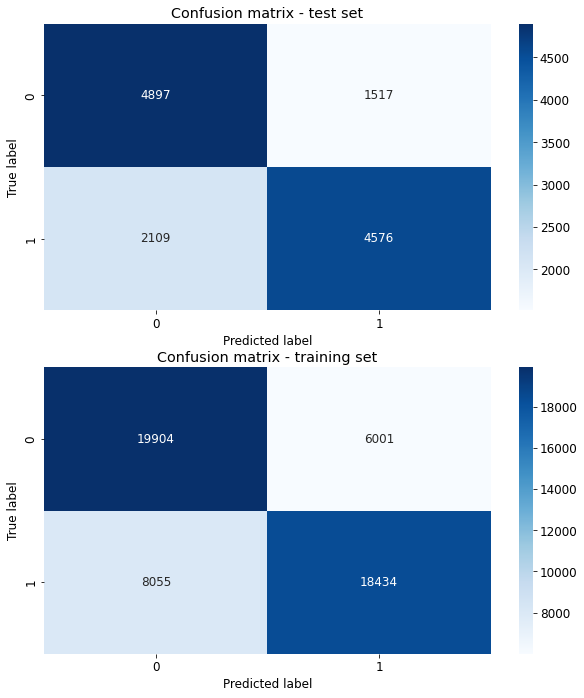

ROC curve - test set


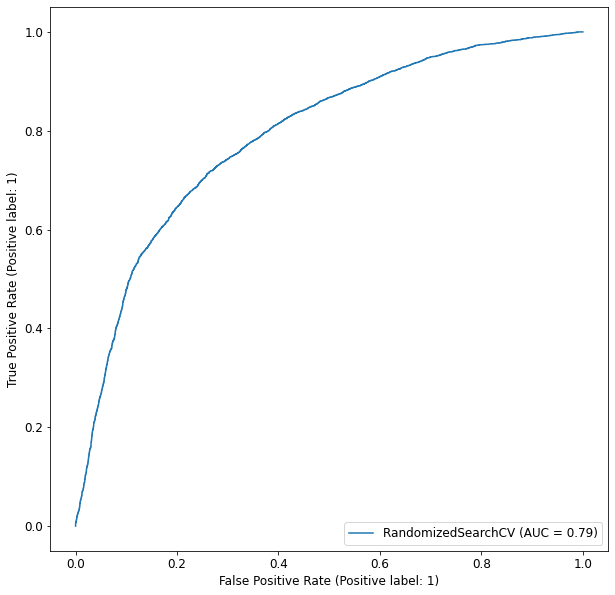

ROC curve - training set


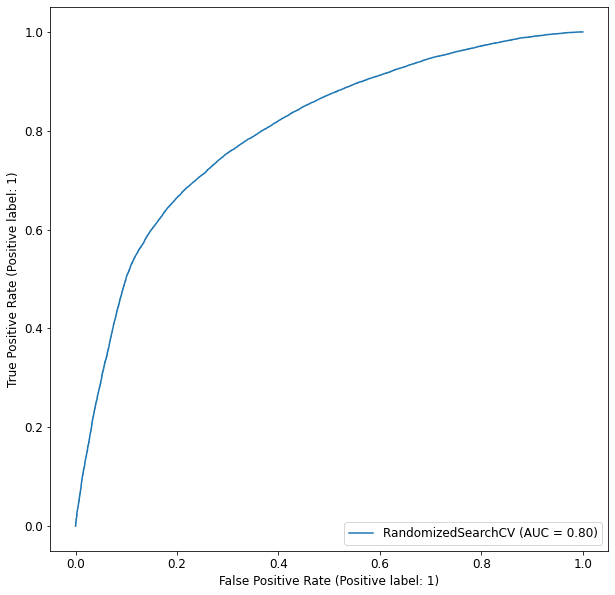

c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7246          XGBClassifier           0.7412    0.7268            0.7429   
0.7232          MLPClassifier           0.7317     0.725            0.7332   
0.7172    Logistic Regression            0.724    0.7194            0.7255   
0.7169              LinearSVC           0.7226    0.7194            0.7244   
0.6999      Nearest Neighbors            0.758    0.7003            0.7582   
0.6832          Random Forest           0.9753    0.6832            0.9753   
0.6132          Decision Tree           0.9753    0.6133            0.9759   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7246    0.7255         0.7417   0.7244            0.741  0.792146   
0.7232     0.724         0.7321    0.723           0.7315  0.790448   
0.7172    0.7181         0.7244    0.717           0.7237  0.779646   
0.7169    0.7179         0.7231   0.7166           0.7223      None   
0.6999    0.7003         0.7581   0.6999            0.758  0.756944   
0.6832    0.6833         0.9754   0.6832           0.9753  0.738267   
0.6132    0.6133         0.9755   0.6132           0.9753  0.613487   

         ROC AUC (train)  
Accuracy                  
0.7246          0.814453  
0.7232          0.798627  
0.7172          0.787066  
0.7169              None  
0.6999          0.839633  
0.6832          0.998321  
0.6132          0.998756

In [126]:
X_train, X_test, y_train, y_test = tt_split(df_cleaned[["age", "gender", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cholesterol_1", "cholesterol_2", "cholesterol_3", "glucose_1", "glucose_2", "glucose_3", "cardio_disease"]])

result_matrixes["Cleaned dataset without subjective features"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=15)
display(result_matrixes["Cleaned dataset without subjective features"])

### Plain dataset including only obese patients (without subjective features)

Classifier:  Decision Tree
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'entropy', 'random_state': 1, 'splitter': 'random'}


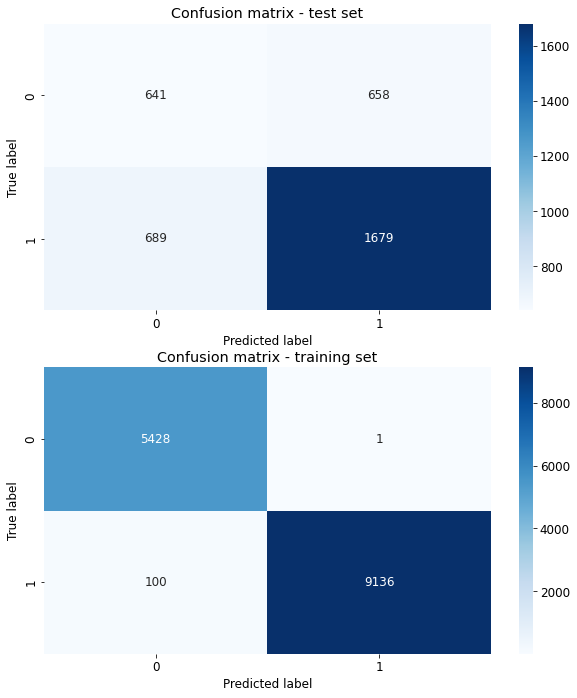

ROC curve - test set


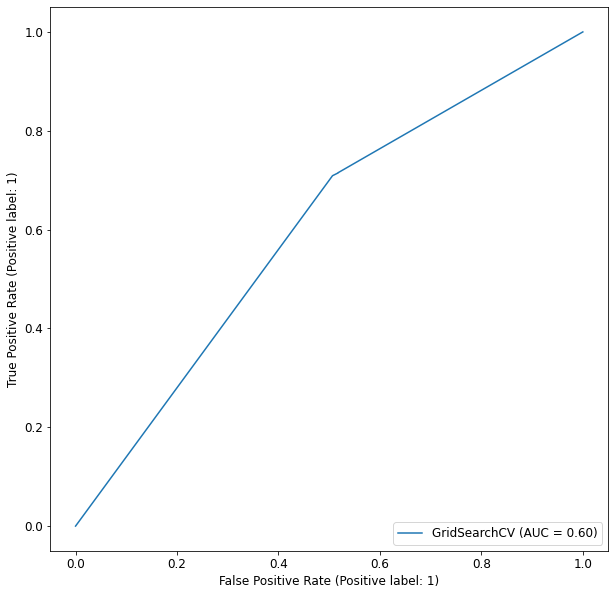

ROC curve - training set


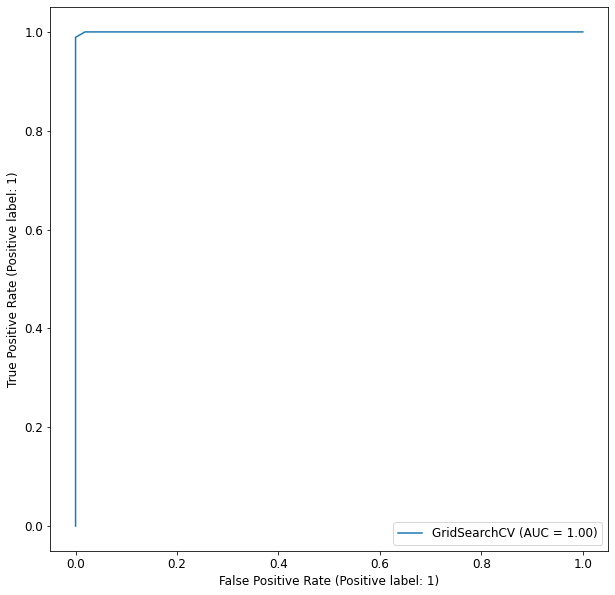

Classifier:  Random Forest
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


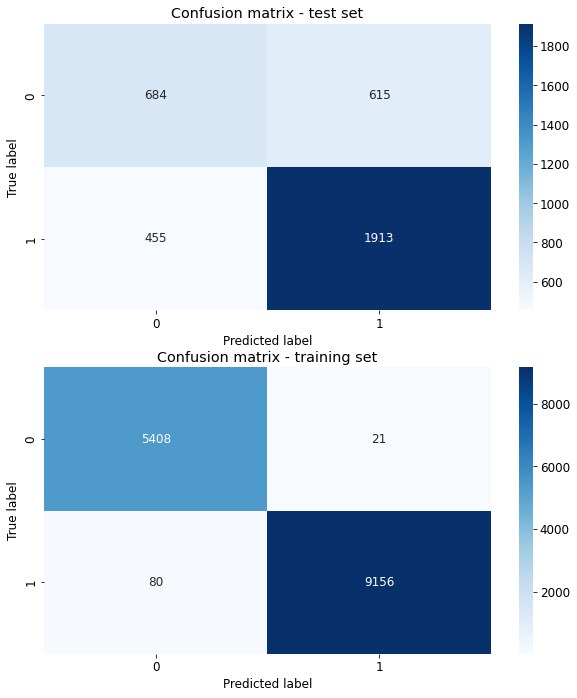

ROC curve - test set


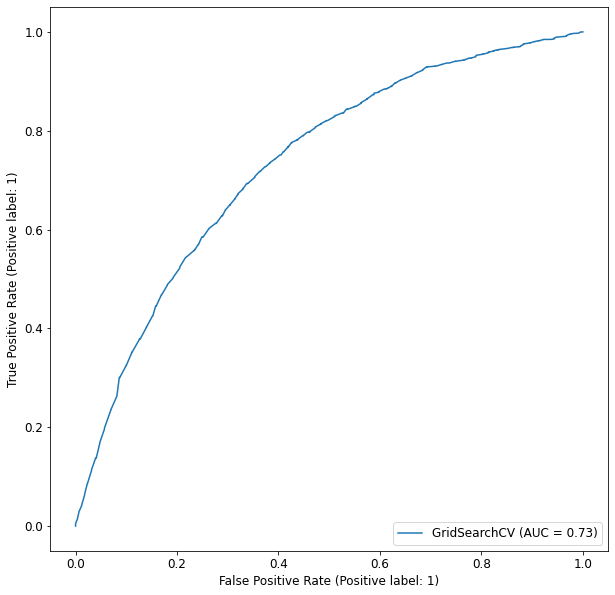

ROC curve - training set


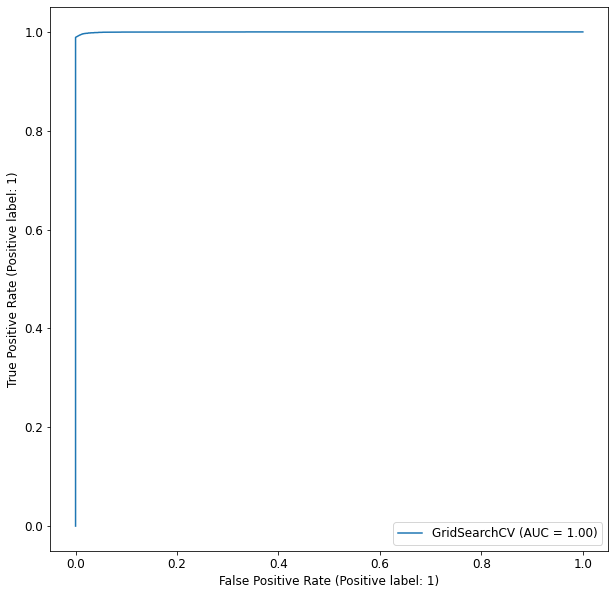

Classifier:  XGBClassifier
Best hyperparameters : {'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 1, 'tree_method': 'exact'}


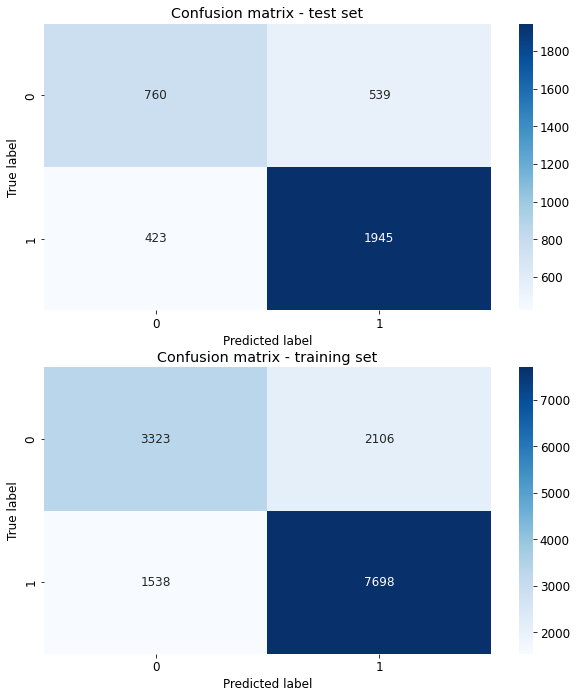

ROC curve - test set


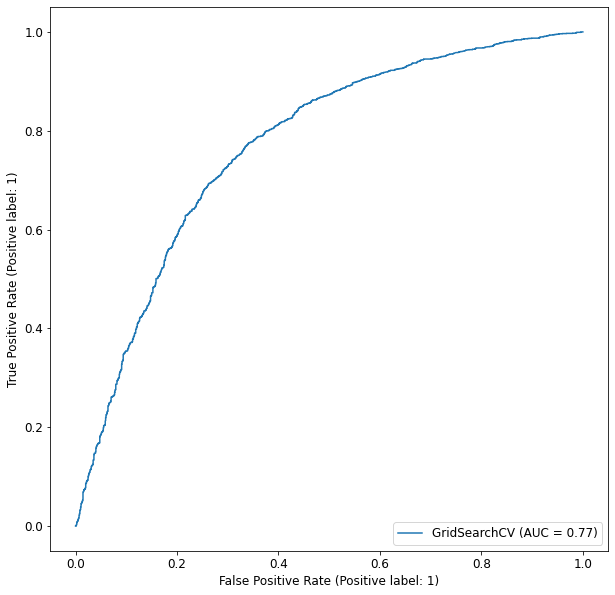

ROC curve - training set


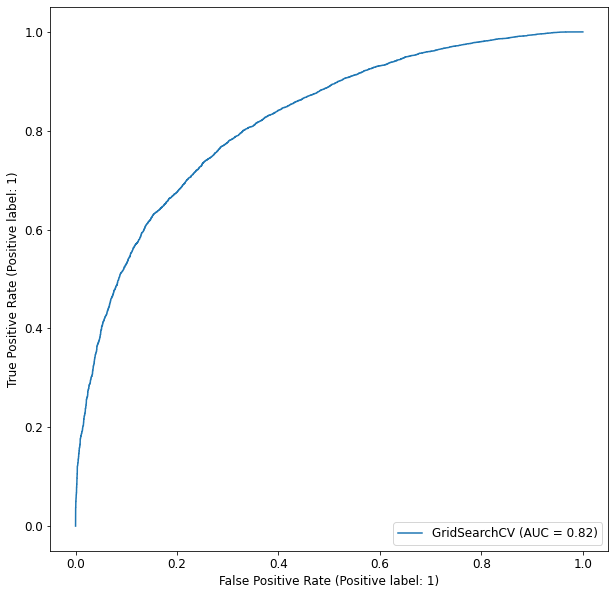

Classifier:  Nearest Neighbors
Best hyperparameters : {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


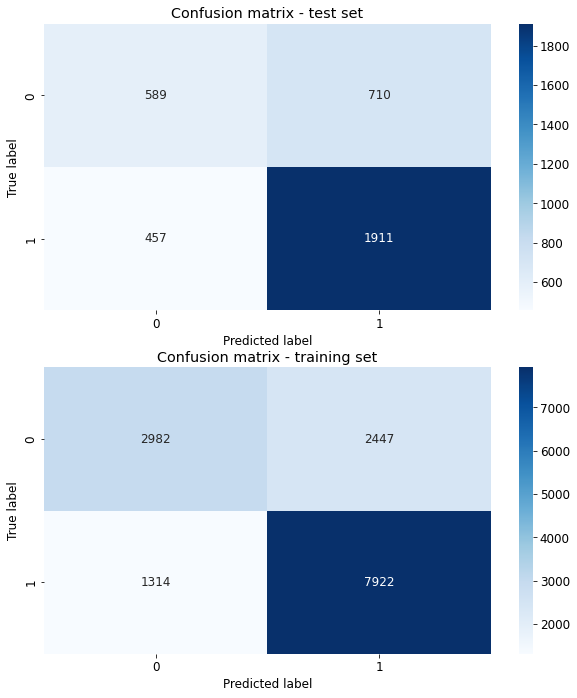

ROC curve - test set


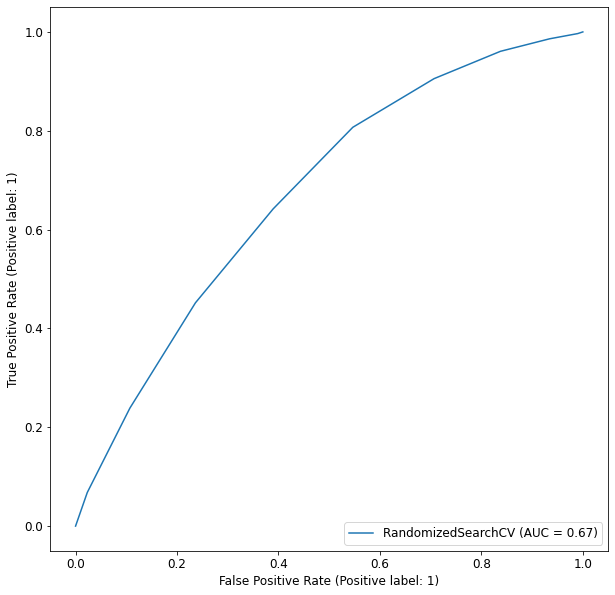

ROC curve - training set


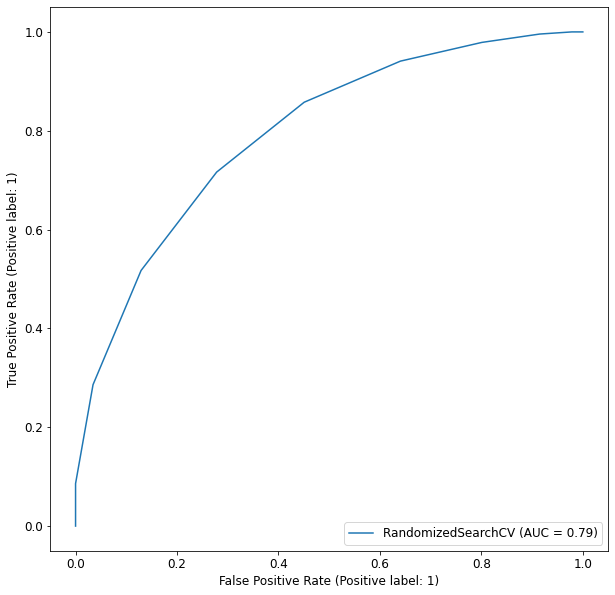

Classifier:  Logistic Regression
Best hyperparameters : {'solver': 'lbfgs', 'random_state': 1, 'n_jobs': -1, 'max_iter': 400, 'C': 10}


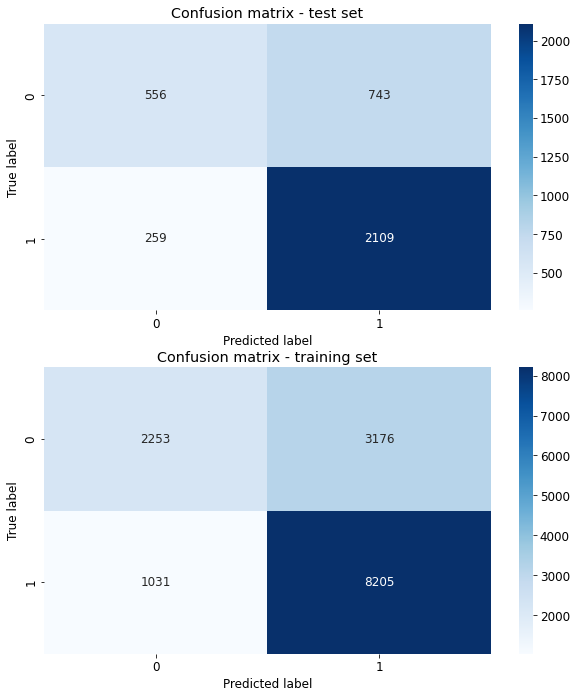

ROC curve - test set


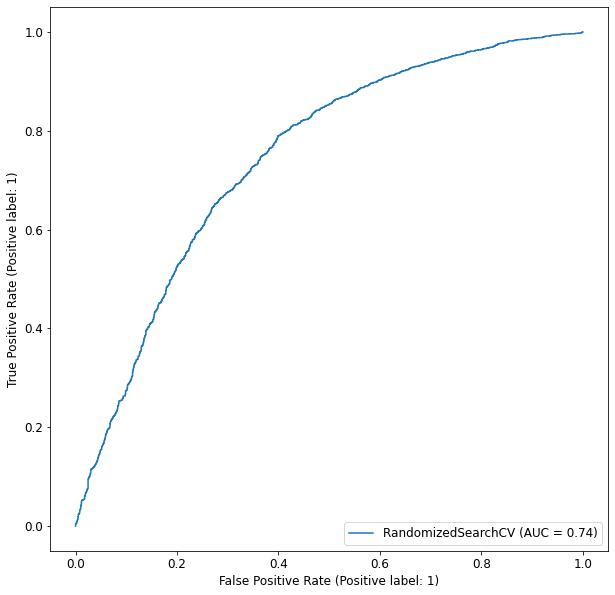

ROC curve - training set


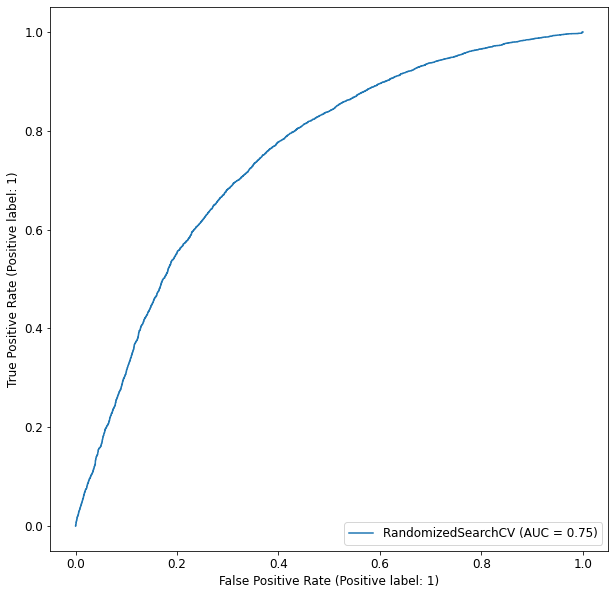

Classifier:  LinearSVC


c:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameters : {'C': 10, 'max_iter': 3000, 'random_state': 1}


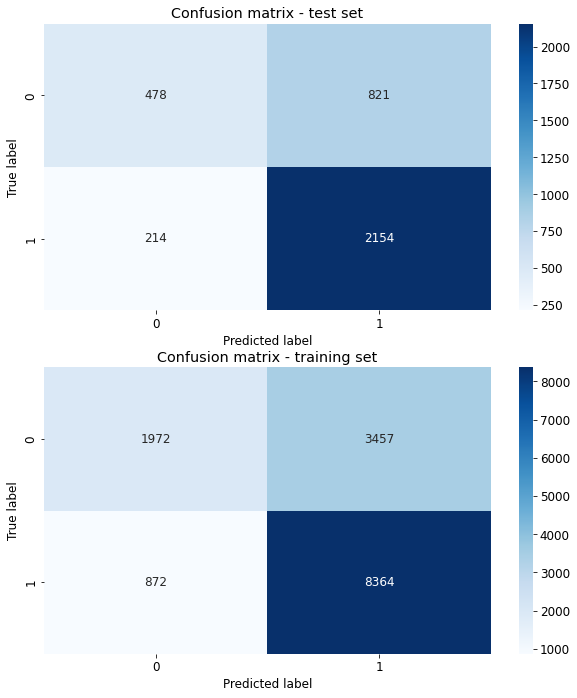

ROC curve - test set


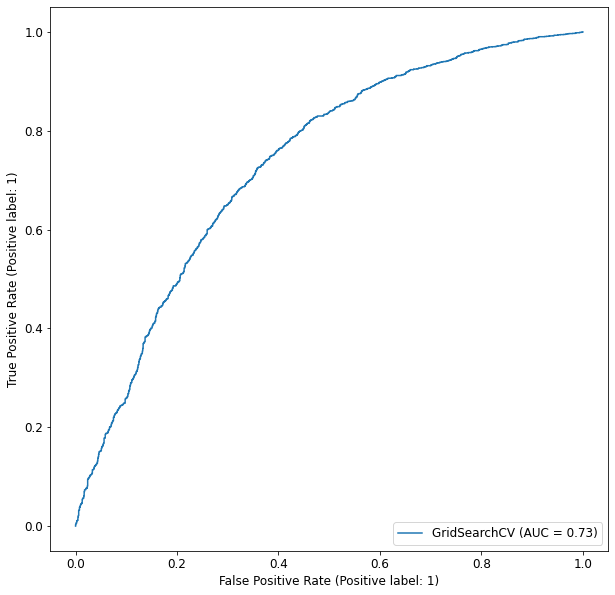

ROC curve - training set


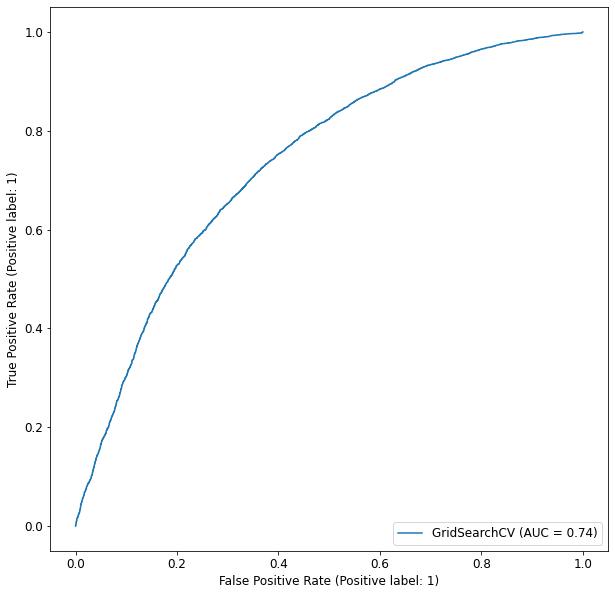

Classifier:  MLPClassifier
Best hyperparameters : {'random_state': 1, 'max_iter': 400, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (8, 4, 4), 'activation': 'relu'}


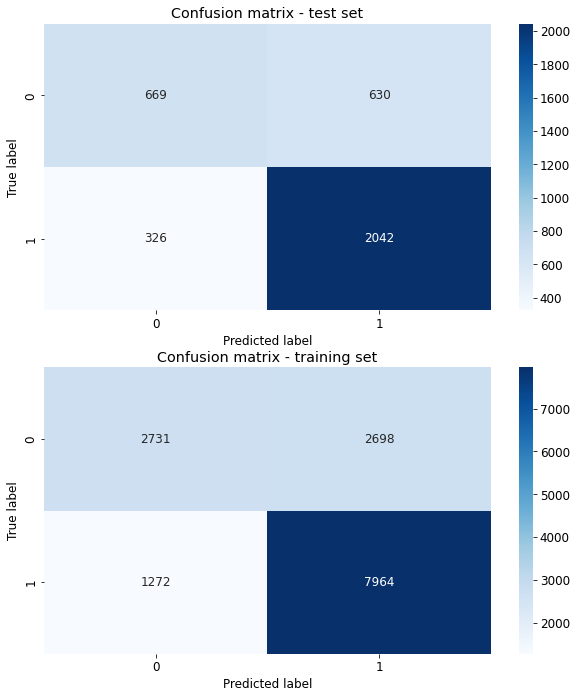

ROC curve - test set


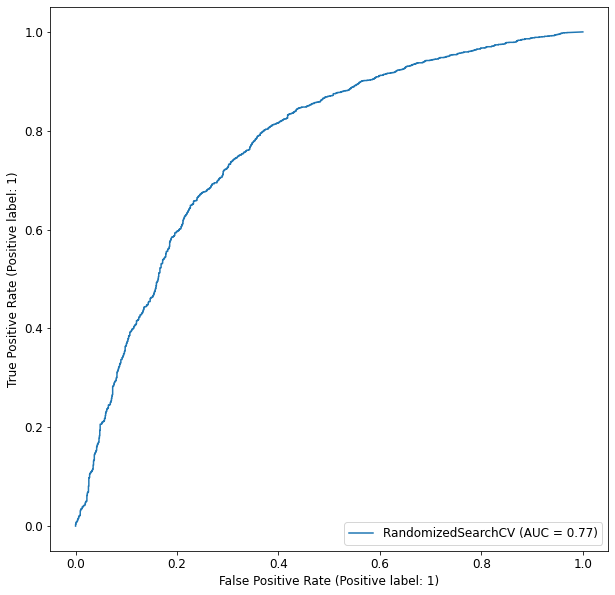

ROC curve - training set


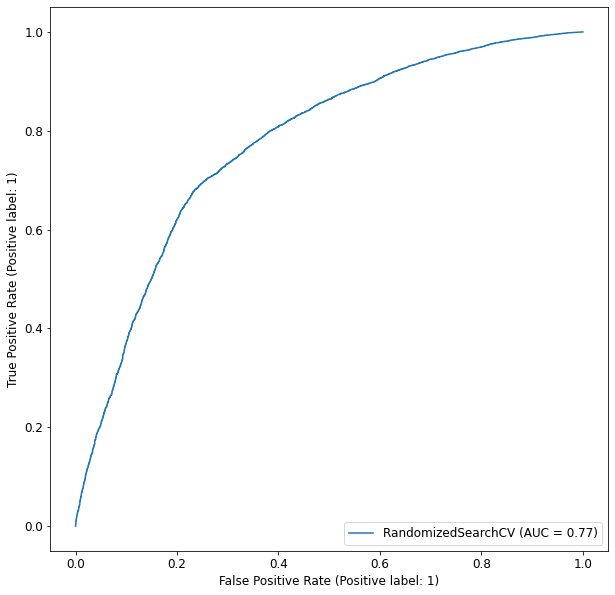

c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7393          MLPClassifier           0.7293    0.7183            0.7146   
0.7377          XGBClassifier           0.7515    0.7127            0.7344   
0.7268    Logistic Regression           0.7131    0.7108            0.7035   
0.7178              LinearSVC           0.7048    0.7074            0.7005   
0.7082          Random Forest           0.9931    0.6786            0.9916   
0.6818      Nearest Neighbors           0.7435    0.6461            0.7291   
0.6327          Decision Tree           0.9931    0.6002            0.9909   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7393    0.6887         0.6827   0.6968           0.6898  0.769615   
0.7377    0.7032         0.7228   0.7071           0.7272  0.769994   
0.7268    0.6593         0.6517    0.667           0.6566   0.74383   
0.7178    0.6388         0.6344   0.6432           0.6356      None   
0.7082    0.6672         0.9937   0.6713           0.9926  0.732136   
0.6818    0.6302         0.7035   0.6342           0.7107   0.67441   
0.6327    0.6012         0.9945   0.6007           0.9926  0.601135   

         ROC AUC (train)  
Accuracy                  
0.7393          0.774518  
0.7377          0.820306  
0.7268          0.747299  
0.7178              None  
0.7082          0.999744  
0.6818          0.794307  
0.6327          0.999898

In [127]:
df_obese = df_obese[["age", "gender", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cholesterol_1", "cholesterol_2", "cholesterol_3", "glucose_1", "glucose_2", "glucose_3", "cardio_disease"]]

X_train, X_test, y_train, y_test = tt_split(df_obese)

result_matrixes["Cleaned dataset including only obese patients"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=15)
display(result_matrixes["Cleaned dataset including only obese patients"])

### Cleaned dataset including only obese patients (without subjective features)

Classifier:  Decision Tree
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'gini', 'random_state': 1, 'splitter': 'random'}


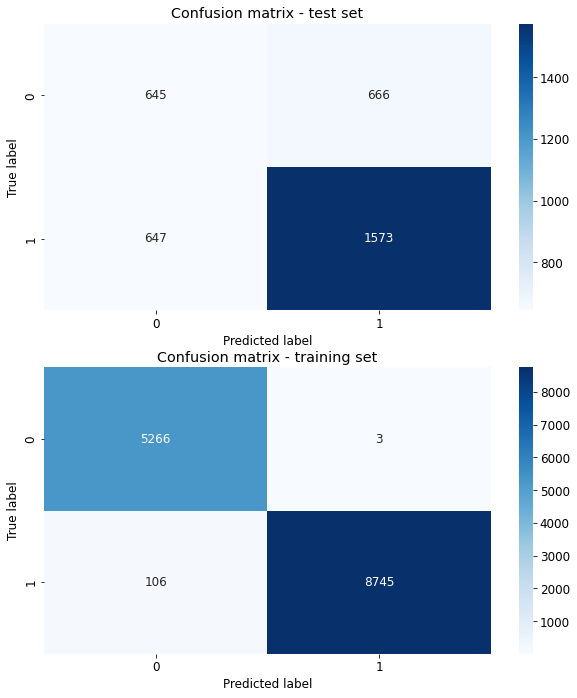

ROC curve - test set


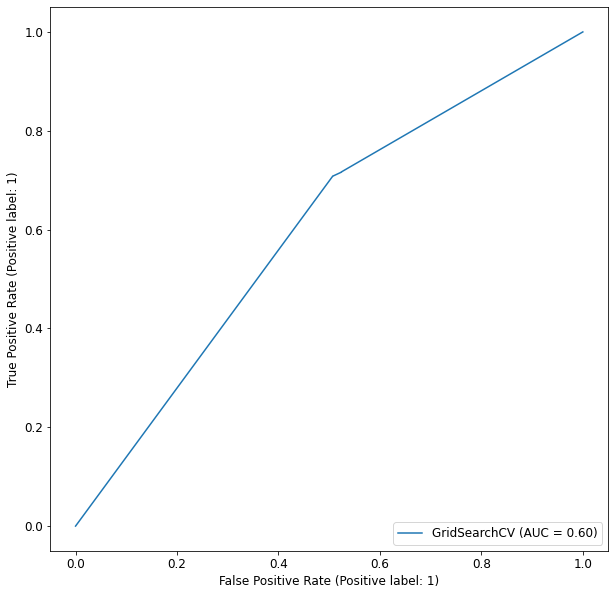

ROC curve - training set


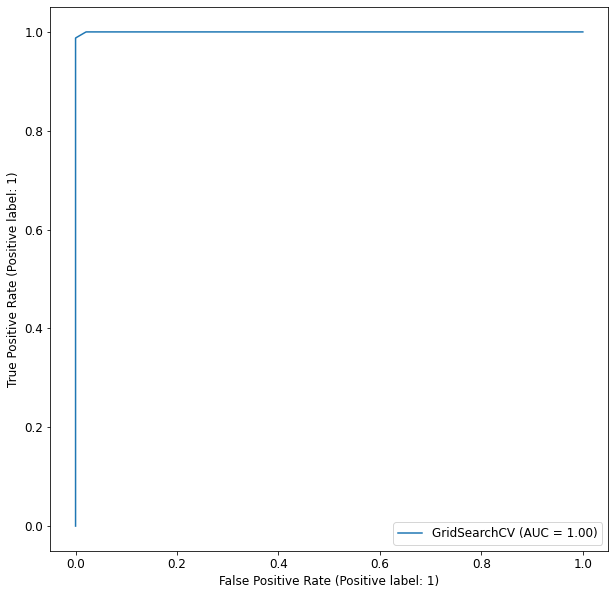

Classifier:  Random Forest
Best hyperparameters : {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 1}


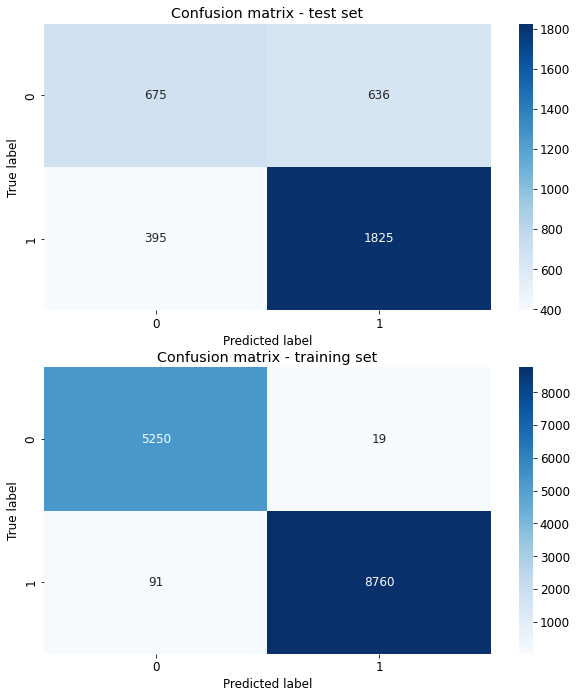

ROC curve - test set


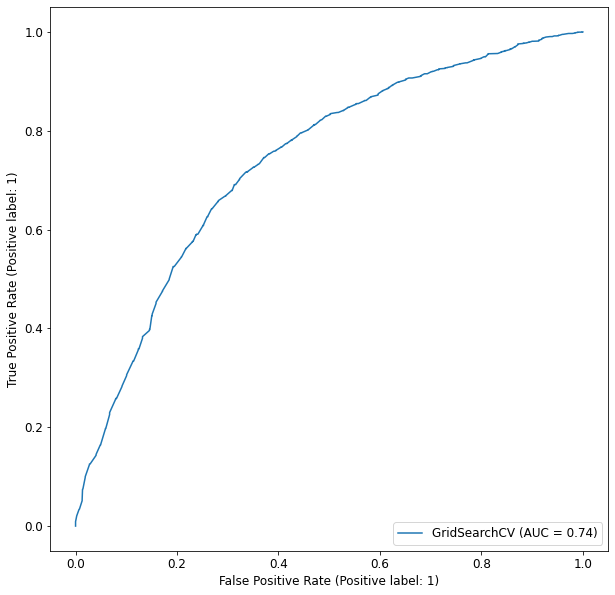

ROC curve - training set


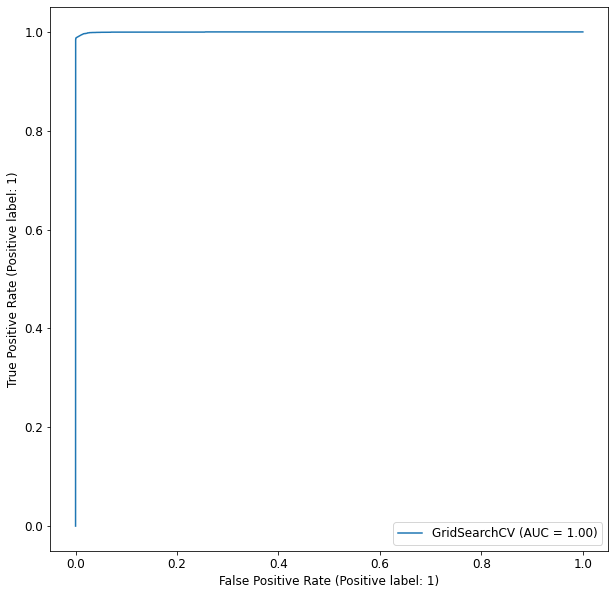

Classifier:  XGBClassifier
Best hyperparameters : {'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 1, 'tree_method': 'exact'}


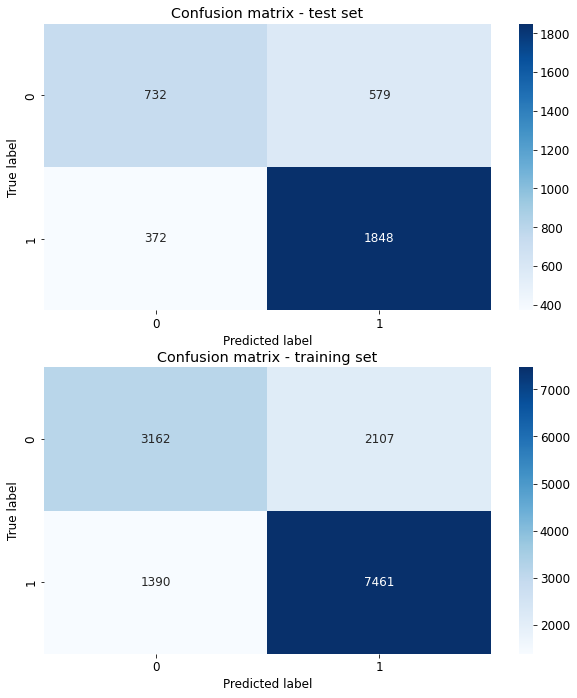

ROC curve - test set


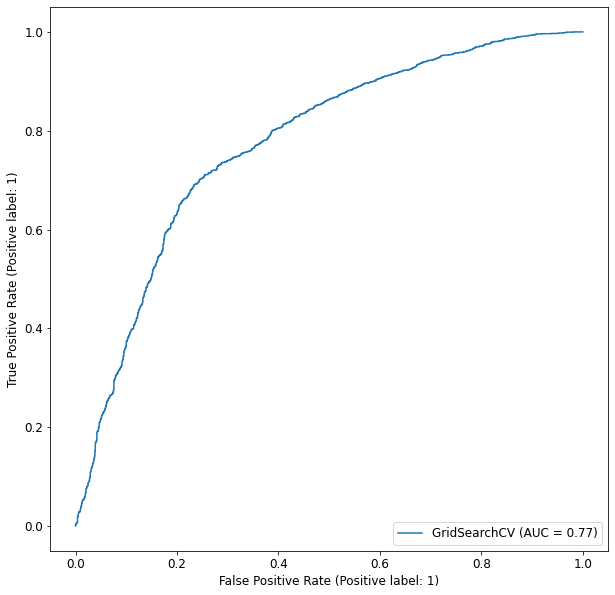

ROC curve - training set


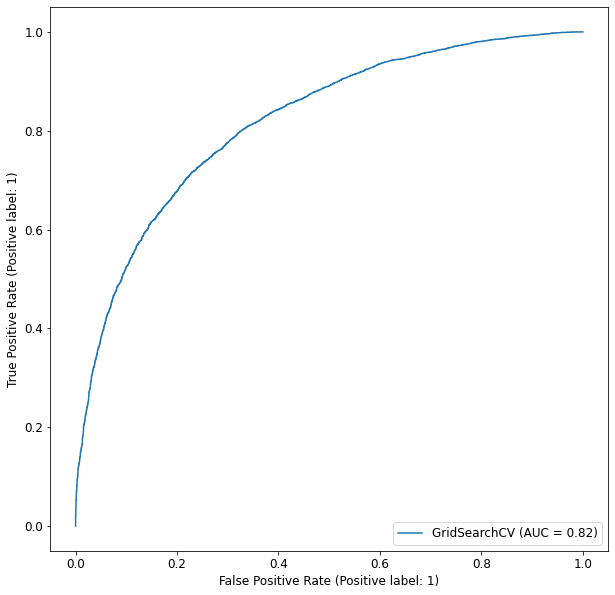

Classifier:  Nearest Neighbors
Best hyperparameters : {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'n_jobs': -1, 'algorithm': 'kd_tree'}


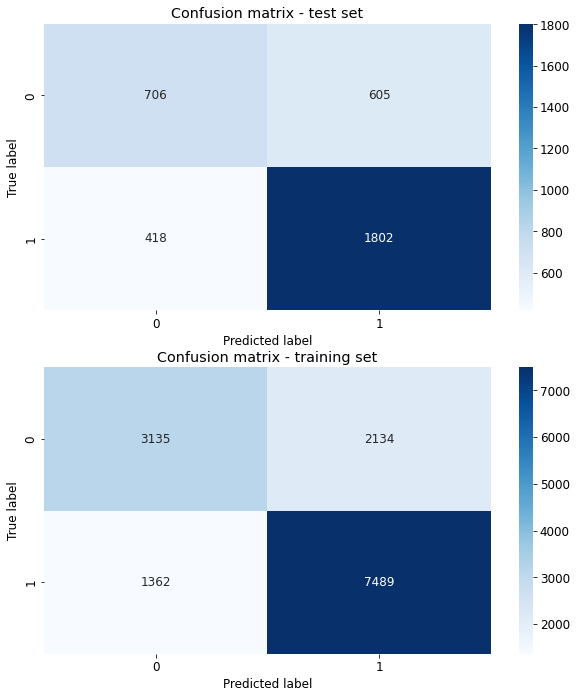

ROC curve - test set


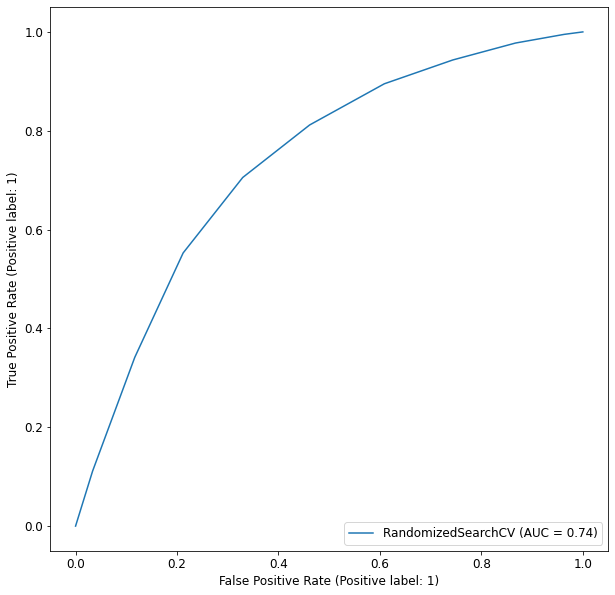

ROC curve - training set


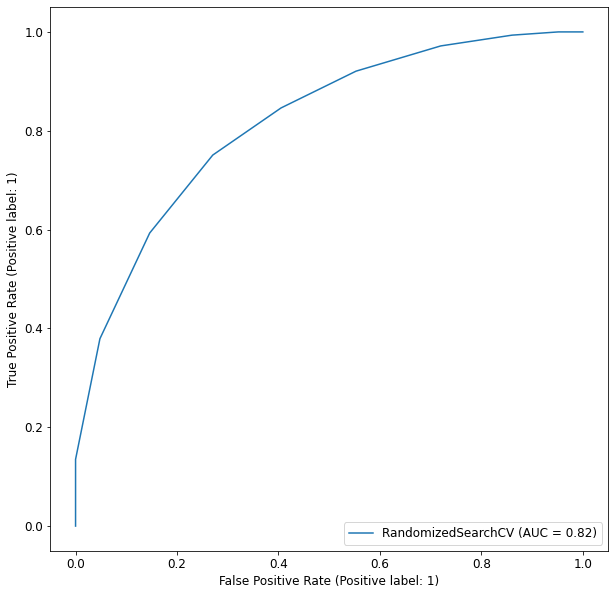

Classifier:  Logistic Regression
Best hyperparameters : {'solver': 'sag', 'random_state': 1, 'n_jobs': -1, 'max_iter': 400, 'C': 0.1}


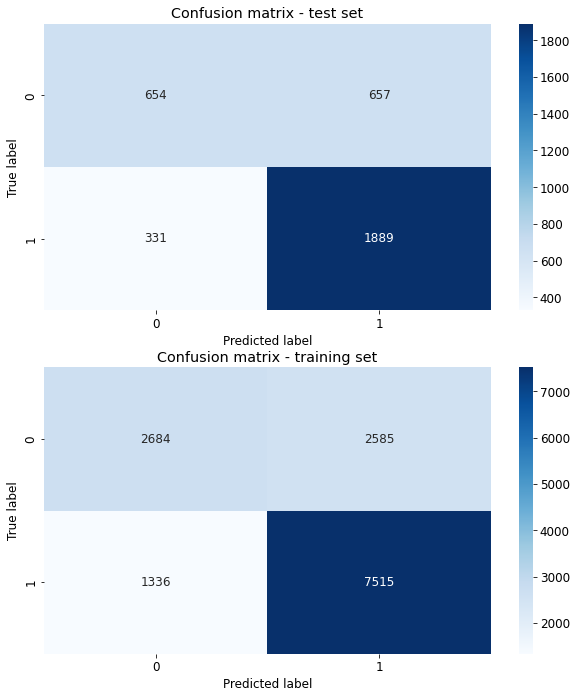

ROC curve - test set


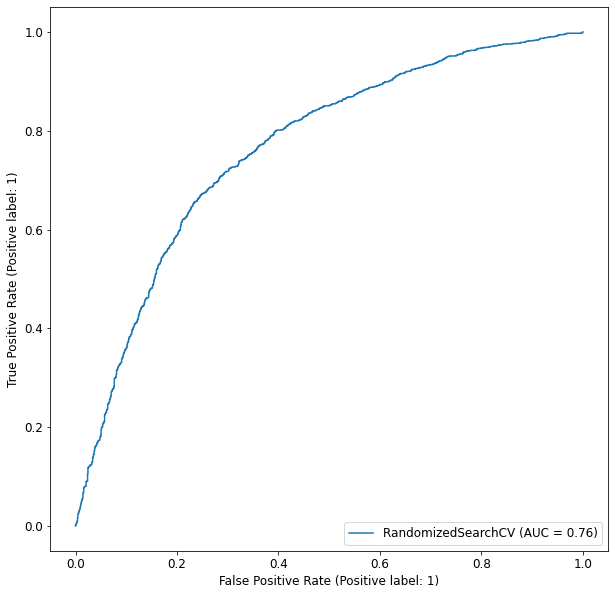

ROC curve - training set


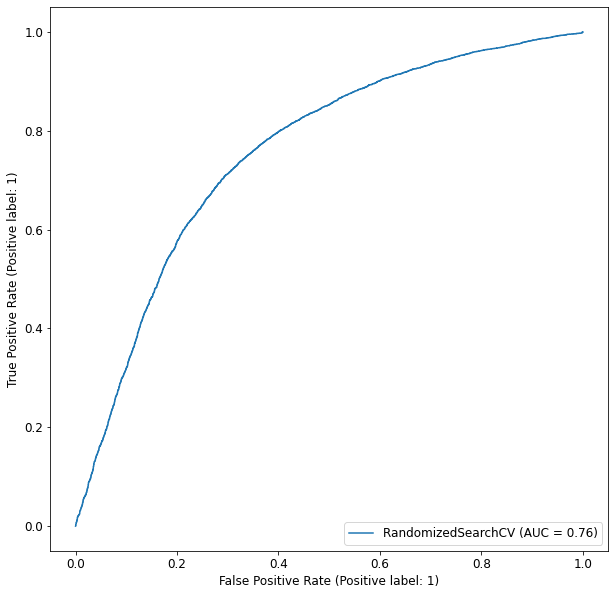

Classifier:  LinearSVC
Best hyperparameters : {'C': 0.01, 'max_iter': 3000, 'random_state': 1}


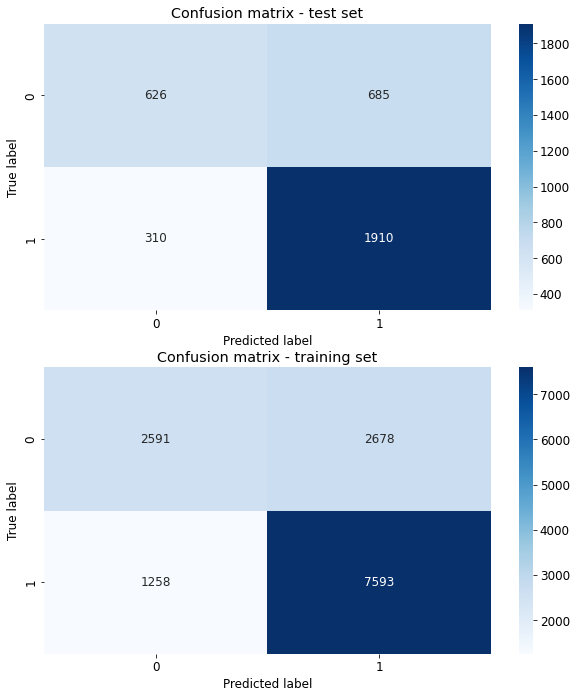

ROC curve - test set


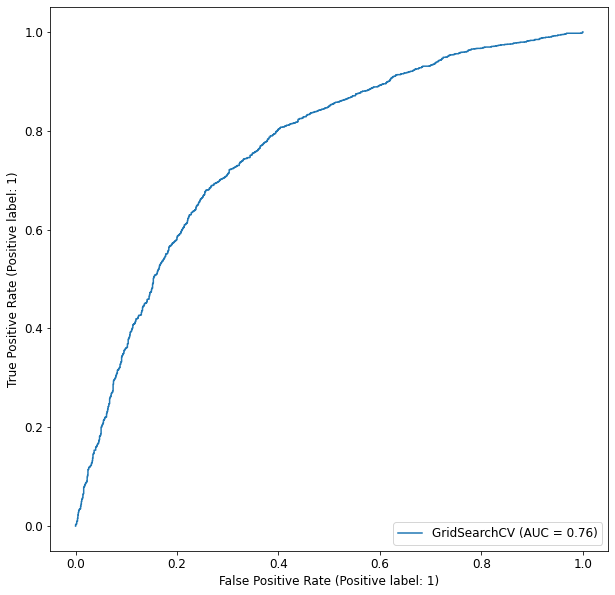

ROC curve - training set


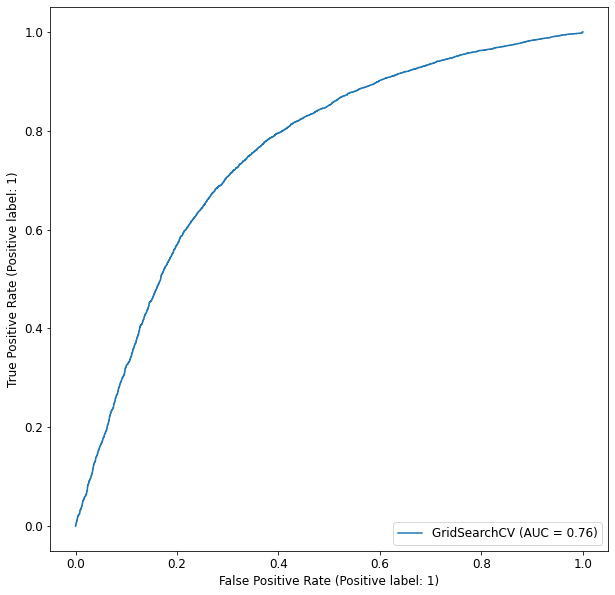

Classifier:  MLPClassifier
Best hyperparameters : {'random_state': 1, 'max_iter': 400, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (8, 4, 4), 'activation': 'relu'}


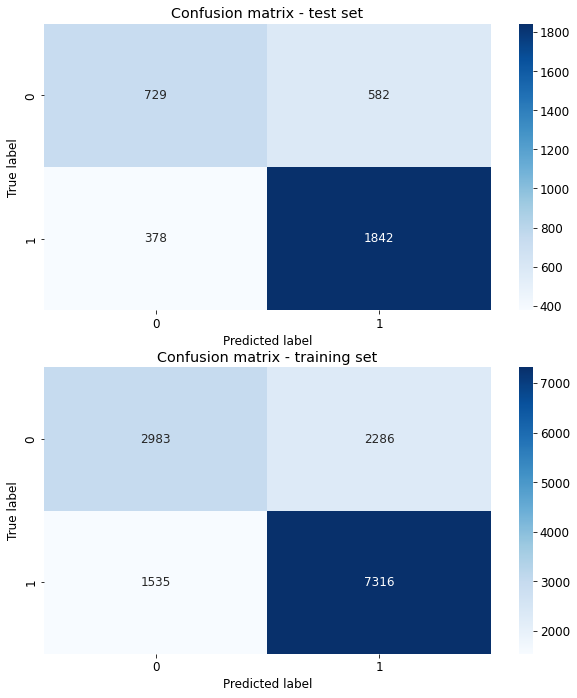

ROC curve - test set


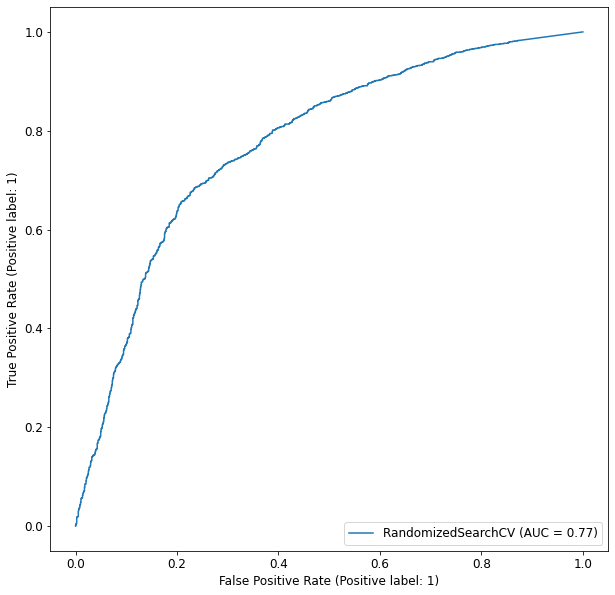

ROC curve - training set


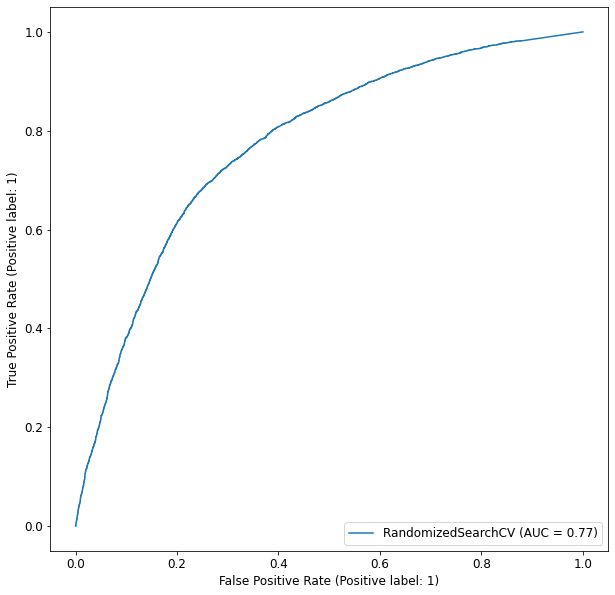

c:\Users\Giovanni\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7307          XGBClassifier           0.7523    0.7122            0.7372   
0.7281          MLPClassifier           0.7294    0.7092            0.7111   
0.7202    Logistic Regression           0.7223     0.703            0.7059   
0.7182              LinearSVC           0.7212    0.7024            0.7062   
0.7103      Nearest Neighbors           0.7524    0.6884            0.7377   
0.7080          Random Forest           0.9922    0.6862            0.9904   
0.6282          Decision Tree           0.9923    0.6009              0.99   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7307    0.6954         0.7215   0.7008            0.727  0.774723   
0.7281    0.6929         0.6964   0.6981           0.7013  0.774341   
0.7202    0.6749         0.6792   0.6812           0.6855  0.763622   
0.7182    0.6689         0.6748   0.6753           0.6812      None   
0.7103    0.6751         0.7206   0.6794           0.7264  0.737016   
0.7080    0.6685         0.9931   0.6734           0.9917  0.736492   
0.6282    0.6003         0.9937   0.6006           0.9918  0.600202   

         ROC AUC (train)  
Accuracy                  
0.7307          0.819058  
0.7281          0.772994  
0.7202          0.756633  
0.7182              None  
0.7103          0.816994  
0.7080          0.999735  
0.6282          0.999872

In [128]:
df_obese_cleaned = df_obese_cleaned[["age", "gender", "height", "weight", "BMI", "systolic_bp", "diastolic_bp", "cholesterol_1", "cholesterol_2", "cholesterol_3", "glucose_1", "glucose_2", "glucose_3", "cardio_disease"]]

X_train, X_test, y_train, y_test = tt_split(df_obese_cleaned)

result_matrixes["Cleaned dataset including only obese patients"] = classification(classifiers, X_train, y_train, X_test, y_test, n_iter=15)
display(result_matrixes["Cleaned dataset including only obese patients"])

### Final results

In [129]:
for data,result in result_matrixes.items():
    display(data, result)

'Plain dataset'

Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7287          XGBClassifier           0.7483    0.7297            0.7493   
0.7252          MLPClassifier            0.734    0.7268            0.7355   
0.7194    Logistic Regression           0.7228    0.7204            0.7238   
0.7008              LinearSVC           0.7066    0.7013            0.7073   
0.6955          Random Forest           0.9834    0.6953            0.9833   
0.6575      Nearest Neighbors           0.7365    0.6578            0.7367   
0.6259          Decision Tree           0.9834    0.6257            0.9836   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7287    0.7296         0.7489   0.7287           0.7482  0.796294   
0.7252    0.7263         0.7347   0.7252           0.7339  0.793367   
0.7194    0.7203         0.7234   0.7194           0.7228  0.782195   
0.7008    0.7014         0.7071   0.7008           0.7066      None   
0.6955    0.6954         0.9835   0.6953           0.9834  0.747861   
0.6575    0.6579         0.7368   0.6574           0.7365  0.710192   
0.6259    0.6258         0.9838   0.6257           0.9834  0.624746   

         ROC AUC (train)  
Accuracy                  
0.7287          0.824923  
0.7252          0.800333  
0.7194          0.786427  
0.7008              None  
0.6955           0.99942  
0.6575          0.811537  
0.6259          0.999449

'Cleaned dataset'

Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7276          MLPClassifier           0.7332    0.7307            0.7355   
0.7272          XGBClassifier           0.7424    0.7297            0.7443   
0.7196    Logistic Regression           0.7242    0.7216            0.7257   
0.7191              LinearSVC           0.7229    0.7214            0.7245   
0.7045      Nearest Neighbors           0.7592    0.7049            0.7595   
0.6882          Random Forest           0.9838    0.6884            0.9838   
0.6132          Decision Tree           0.9838    0.6131            0.9841   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7276    0.7287         0.7337   0.7272           0.7328   0.79295   
0.7272    0.7281         0.7428   0.7269           0.7421  0.793989   
0.7196    0.7205         0.7246   0.7194            0.724  0.781189   
0.7191    0.7201         0.7233   0.7189           0.7226      None   
0.7045    0.7048         0.7594   0.7045           0.7592  0.757036   
0.6882    0.6884         0.9838   0.6882           0.9838  0.743214   
0.6132    0.6131          0.984   0.6131           0.9838  0.612691   

         ROC AUC (train)  
Accuracy                  
0.7276          0.800408  
0.7272          0.817191  
0.7196          0.788357  
0.7191              None  
0.7045          0.840566  
0.6882          0.999439  
0.6132          0.999474

'Cleaned dataset without subjective features'

Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7246          XGBClassifier           0.7412    0.7268            0.7429   
0.7232          MLPClassifier           0.7317     0.725            0.7332   
0.7172    Logistic Regression            0.724    0.7194            0.7255   
0.7169              LinearSVC           0.7226    0.7194            0.7244   
0.6999      Nearest Neighbors            0.758    0.7003            0.7582   
0.6832          Random Forest           0.9753    0.6832            0.9753   
0.6132          Decision Tree           0.9753    0.6133            0.9759   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7246    0.7255         0.7417   0.7244            0.741  0.792146   
0.7232     0.724         0.7321    0.723           0.7315  0.790448   
0.7172    0.7181         0.7244    0.717           0.7237  0.779646   
0.7169    0.7179         0.7231   0.7166           0.7223      None   
0.6999    0.7003         0.7581   0.6999            0.758  0.756944   
0.6832    0.6833         0.9754   0.6832           0.9753  0.738267   
0.6132    0.6133         0.9755   0.6132           0.9753  0.613487   

         ROC AUC (train)  
Accuracy                  
0.7246          0.814453  
0.7232          0.798627  
0.7172          0.787066  
0.7169              None  
0.6999          0.839633  
0.6832          0.998321  
0.6132          0.998756

'Cleaned dataset including only obese patients'

Classifier Accuracy (train) Precision Precision (train)  \
Accuracy                                                                     
0.7307          XGBClassifier           0.7523    0.7122            0.7372   
0.7281          MLPClassifier           0.7294    0.7092            0.7111   
0.7202    Logistic Regression           0.7223     0.703            0.7059   
0.7182              LinearSVC           0.7212    0.7024            0.7062   
0.7103      Nearest Neighbors           0.7524    0.6884            0.7377   
0.7080          Random Forest           0.9922    0.6862            0.9904   
0.6282          Decision Tree           0.9923    0.6009              0.99   

          Recall Recall (train) F1-Score F1-Score (train)   ROC AUC  \
Accuracy                                                              
0.7307    0.6954         0.7215   0.7008            0.727  0.774723   
0.7281    0.6929         0.6964   0.6981           0.7013  0.774341   
0.7202    0.6749         0.6792   0.6812           0.6855  0.763622   
0.7182    0.6689         0.6748   0.6753           0.6812      None   
0.7103    0.6751         0.7206   0.6794           0.7264  0.737016   
0.7080    0.6685         0.9931   0.6734           0.9917  0.736492   
0.6282    0.6003         0.9937   0.6006           0.9918  0.600202   

         ROC AUC (train)  
Accuracy                  
0.7307          0.819058  
0.7281          0.772994  
0.7202          0.756633  
0.7182              None  
0.7103          0.816994  
0.7080          0.999735  
0.6282          0.999872